In [1]:
import time
import pickle
import numpy as np
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm 
import json
from dateutil.parser import parse

In [2]:
from rdbtools import RdbParser, RdbCallback
from rdbtools.encodehelpers import bytes_to_unicode

class PublishCallback(RdbCallback):

    def __init__(self, is_unicode=False, start_ts=float('-inf'), stop_ts=float('+inf')):
        super(PublishCallback, self).__init__(string_escape=None)
        self.ranges = {}
        self.start = start_ts
        self.stop = stop_ts
        self.is_unicode = is_unicode

    def encode_key(self, key):
        return bytes_to_unicode(key, self._escape, skip_printable=True)

    def encode_value(self, val):
        if self.is_unicode:
            return bytes_to_unicode(val, self._escape)
        return val

    def start_sorted_set(self, key, length, expiry, info):
        self.ranges[self.encode_key(key)] = []

    def zadd(self, key, score, member):
        if self.start <= score <= self.stop:
            self.ranges[self.encode_key(key)].append((self.encode_value(member), round(score)))

    def end_sorted_set(self, key):
        encoded_key = self.encode_key(key)
        self.ranges[encoded_key] = list(reversed(self.ranges[encoded_key]))


def parse_dump_file(dump_file, start_ts=float("-inf"), stop_ts=float("+inf")):
    """Parse a redis dump file (rdb) and return the data within.

    Only supports SortedSet.

    Args:
        dump_file (str): Rdb path
        start_ts (float): timestamp of the first value to publish
        stop_ts (float): timestamp of the last value to publish

    Returns:
        ranges (dict): {
                'keyA': [(FrameDataDump1A, Score1A), ..., (FrameDataDumpNA, ScoreNA)],
                'keyB': [(FrameDataDump1B, Score1B), ..., (FrameDataDumpNB, ScoreNB)],
                ...
            }
    """
    t0 = time.time()

    callback = PublishCallback(start_ts=start_ts, stop_ts=stop_ts)
    rdb_parser = RdbParser(callback)
    rdb_parser.parse(dump_file)
    print("Parsed {} in {:.2f} s.".format(dump_file, time.time() - t0))
    print("Contains keys:", callback.ranges.keys())
    for k in callback.ranges.keys():
        print(
            "[{}] start_ts: {} | stop_ts: {}".format(
                k, callback.ranges[k][0][1], callback.ranges[k][-1][1]
            )
        )
    return callback.ranges

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [4]:
tracks = parse_dump_file('../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb')
config = json.load(open('../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json', 'r'))

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 4.57 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
[left] start_ts: 1524318934512 | stop_ts: 1524319532312


In [5]:

fd, ts = tracks['left'][4000]


fd = pickle.loads(fd)
pprint.pprint(fd.__dict__.keys())
print([fd.player_detections[i].confidence for i in range(len(fd.player_detections))])

dict_keys(['player_detections', 'features', 'stream_ts', 'embeddings', 'packed_rects', 'mapping', 'last', 'ts', 'valid_frame', 'top_view_player_positions', 'bboxes', 'phase_state', 'ball_detections', 'top_view_ball_positions'])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
kickoff_1 = config['phase_events'][0]['ts']
kickoff_time = int(parse(kickoff_1).timestamp()*1000)

In [7]:
config['phase_events'] 

[{'kickoff_team_id': 13,
  'phase': 1,
  'ts': '2018-04-21T14:00:33.996000',
  'type': 'start_phase'},
 {'phase': 1, 'ts': '2018-04-21T14:45:33.074Z', 'type': 'end_phase'},
 {'kickoff_team_id': 12,
  'phase': 2,
  'ts': '2018-04-21T15:02:23.876000',
  'type': 'start_phase'},
 {'phase': 2, 'ts': '2018-04-21T15:50:24.649Z', 'type': 'end_phase'}]

In [8]:
pitch_size=config['pitch_size']
print(pitch_size)

[105, 68]


In [9]:
detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}

timestamps = set()

def ball_ok(ball_pos, ball_det):
    if ball_pos[0] < 0 or ball_pos[1] < 0:
        return False
    if ball_det.confidence < 0.7:
        return False
    return True

for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
    fd_left = pickle.loads(fd_left)
    fd_right = pickle.loads(fd_right)
    if np.abs(ts_left - ts_right) < 100:
        ts_left = ts_right
    timestamps.update({ts_left, ts_right})

    detections['players']['left'][ts_left] = fd_left.top_view_player_positions
    detections['players']['right'][ts_right] = fd_right.top_view_player_positions
    detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
    detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    

14940it [00:11, 1336.30it/s]


In [147]:
print(detections['players']['left'][1527429925546])

KeyError: 1527429925546

1524319233996 1524319233996


<IPython.core.display.Javascript object>


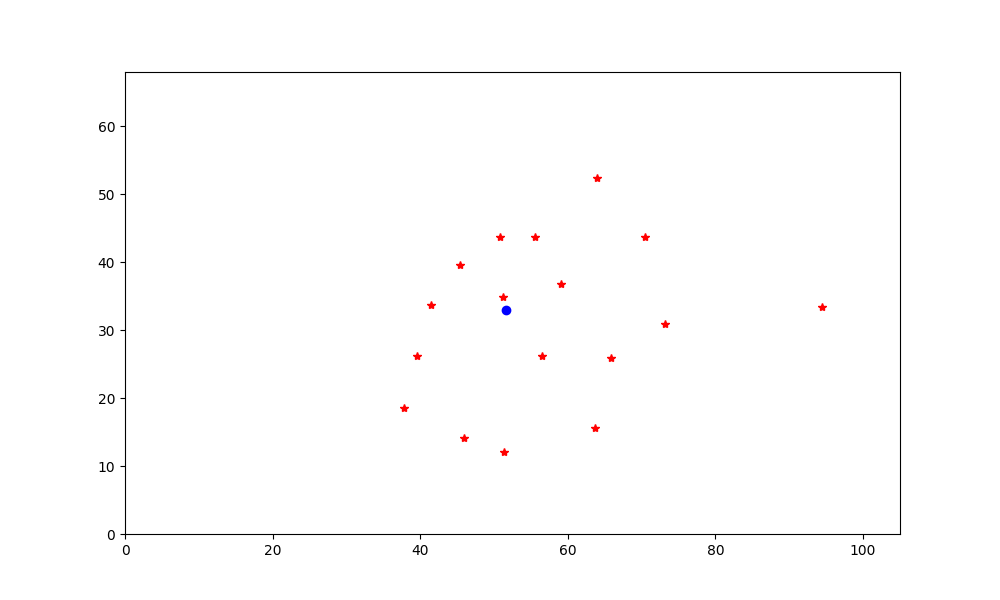

interactive(children=(SelectionSlider(description='ts', index=14956, options=(1524318934512, 1524318934552, 15…

In [10]:
timestamps_list = sorted(list(timestamps))
kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
kickoff_time_matched = timestamps_list[kickoff_time_ind]
print(kickoff_time, kickoff_time_matched)

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
left, = plt.plot([], '*r')
right, = plt.plot([], '*r')

left_b, = plt.plot([], 'ob')
right_b, = plt.plot([], 'ob')

plt.xlim([0, 105])
plt.ylim([0, 68])

def update(ts=kickoff_time_matched):
    if ts in detections['players']['left']:
        left.set_ydata(detections['players']['left'][ts][:, 1])
        left.set_xdata(detections['players']['left'][ts][:, 0])
    else:
        left.set_ydata([])
        left.set_xdata([])
        
    if ts in detections['players']['right']:
        right.set_ydata(detections['players']['right'][ts][:, 1])
        right.set_xdata(detections['players']['right'][ts][:, 0])
    else:
        right.set_ydata([])
        right.set_xdata([])

    if ts in detections['ball']['left'] and len(detections['ball']['left'][ts]):
        left_b.set_ydata(detections['ball']['left'][ts][:, 1])
        left_b.set_xdata(detections['ball']['left'][ts][:, 0])
    else:
        left_b.set_ydata([])
        left_b.set_xdata([])        
    if ts in detections['ball']['right'] and len(detections['ball']['right'][ts]):
        right_b.set_ydata(detections['ball']['right'][ts][:, 1])
        right_b.set_xdata(detections['ball']['right'][ts][:, 0])
    else:
        right_b.set_ydata([])
        right_b.set_xdata([])
    
    
wid = widgets.SelectionSlider(
    options=timestamps_list,
    value=kickoff_time_matched,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
    
interact(update, ts = wid);

In [ ]:
# {'id': 'd1a98e08-0f21-46fe-8457-01ff183ddbeb', 'calibration': {'views': ['left', 'right'], 'reference_landmarks': {'object': 'calibrations/tele2_landmarks.json', 'bucket': 'signality.ironfist.models'}}, 'replay_urls': ['//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase1.data', '//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase2.data'], 'camera_mode': 'static', 'away_team': {'colors': {'team': '#000000', 'goalkeeper': '#ffff00'}, 'logo_url': 'http://images.signality.com/team-logos/orebro.png', 'name': 'Örebro SK'}, 'phase_events': [{'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 0, 2, 362000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e4e0>), 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 47, 7, 92000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e518>), 'phase': 1}, {'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 4, 2, 891000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e630>), 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 52, 6, 565000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e6a0>), 'phase': 2}], 'start_time': datetime.datetime(2018, 5, 17, 19, 0, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e780>), 'state': 'Destroyed', 'external_data': {'smc': {'match_id': 3704, 'home_team_id': 11, 'league_id': 12, 'away_team_id': 12}}, 'streams': {'left': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/ca074983-09a2-451f-8730-90efa6701dc8/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9e8>)}, 'autofollow_render_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d890161e-59fa-4f39-9758-b9d5b10357af/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9b0>)}, 'virtual_panorama_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/b5e093f3-f8e7-4643-a87a-d9a76256a735/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ec88>)}, 'goal_south_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/c841f705-de34-4428-b56e-7c9803ab4eca/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 143000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61eac8>)}, 'right': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d8112841-7cf8-48ae-89ce-f327c282916c/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 124000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea20>)}, 'goal_north_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/9a7b8e83-dbc0-436b-a116-7f8d085057c2/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 141000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea58>)}}, 'pitch_size': [105, 68], 'home_team': {'colors': {'team': '#5a9dde', 'goalkeeper': '#ffffff'}, 'logo_url': 'http://images.signality.com/team-logos/djurgarden.png', 'name': 'Djurgårdens IF'}, 'referees': {'colors': '#000000'}, 'competition': 'Allsvenskan', 'redis': {'host': 'redis', 'port': 6379}, 'rethinkdb': {'host': 'db.signality.com', 'user': 'game_viewer', 'db': 'livetrack', 'ssl': {'ca_certs': '/home/ubuntu/workspace/ironfist/ironfist/utils/../applications/livetrack/config/db.signality.cert.pem'}, 'password': 'MmPHrqmXaVeu', 'port': 28015}, 'nchan': {'url': 'http://nchan:8080'}, 'arena': 'Tele2 Arena', 'stats': [{'home_team': {'failed_passes': 163, 'possessing_team': 0, 'passes': 181, 'distance': 62777.64480394193, 'possession': 25067, 'packing': 260}, 'source': 'signality', 'phase': 1, 'away_team': {'failed_passes': 163, 'possessing_team': 1, 'passes': 191, 'distance': 60097.76136929008, 'possession': 23934, 'packing': 252}, 'utc_time': 1526579225125, 'match_time': 2822763}, {'home_team': {'failed_passes': 157, 'possessing_team': 0, 'passes': 147, 'distance': 62576.815733754884, 'possession': 20009, 'packing': 196}, 'source': 'signality', 'phase': 2, 'away_team': {'failed_passes': 158, 'possessing_team': 1, 'passes': 206, 'distance': 57684.92804763888, 'possession': 28384, 'packing': 240}, 'utc_time': 1526583124565, 'match_time': 2881674}], 'video_shape': [2160, 3840, 3], 'rdb': [{'key': '20180517.djurgårdens-if-örebro-sk.2.rdb', 'bucket': 'signality.soccer.backup', 'phase': 2}]}

In [11]:
def select_time(time_list,detections):
    l=list()
    truth_list=list()
    for i in range(len(time_list)):
        truth_list.append(True)
        if time_list[i] in detections['players']['left'] and time_list[i] in detections['players']['right']:
            l.append([time_list[i],time_list[i]])
            truth_list[i]=False
        if i>0:
            if time_list[i-1] in detections['players']['left'] and time_list[i] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i-1],time_list[i]])
                truth_list[i]=False
            if time_list[i] in detections['players']['left'] and time_list[i-1] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i],time_list[i-1]])
                truth_list[i]=False
    return l

#l=select_time(timestamps_list,detections)

In [12]:
def players_grid(pitch_size,players):
    compteur=0
    grid=[0 for i in range(32)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/8
    width_edge=width/4
    for i in range(len(players)):
        k=0
        j=0
        if players[i][0]<=length and players[i][1]<=width and players[i][0]>=0 and players[i][1]>=0 :
            compteur+=1
            while players[i][0]>(k+1)*length_edge:
                k+=1
            while players[i][1]>(j+1)*width_edge:
                j+=1
            grid[8*j+k]+=1
    if compteur>0:
        new_grid=[float(grid[i])/float(compteur) for i in range(32)]
    else:
        new_grid=grid
    return new_grid

def ball_grid(pitch_size,ball):
    grid=[0 for i in range(35)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/7
    width_edge=width/5
    for i in range(len(ball)):
        k=0
        j=0
        if ball[i][0]<=length and ball[i][1]<=width and ball[i][0]>=0 and ball[i][1]>=0:
            while ball[i][0]>(k+1)*length_edge:
                k+=1
            while ball[i][1]>(j+1)*width_edge:
                j+=1
            grid[7*j+k]+=1
    return grid

In [13]:
def pitch_composition_t(time,detections,pitch_size):
    compo=list()
    if isinstance(detections['ball']['left'][time[0]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]])
    if isinstance(detections['ball']['left'][time[0]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]].tolist())
        
    if isinstance(detections['ball']['right'][time[1]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]])
    if isinstance(detections['ball']['right'][time[1]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]].tolist())
    
    if isinstance(detections['players']['left'][time[0]],list):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]])
    if isinstance(detections['players']['left'][time[0]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]].tolist())
        
    if isinstance(detections['players']['right'][time[1]],list):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]])
    if isinstance(detections['players']['right'][time[1]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]].tolist())
    return compo
    
def pitch_composition(time_list,detections,pitch_size):
    l=select_time(time_list,detections)
    seq=list()
    for i in range(len(l)):
        seq.append(pitch_composition_t(l[i],detections,pitch_size))
    return seq


In [14]:
def flip_player_pitch(pitch_grid):
    new_pitch_grid=[0 for i in range(32)]
    for j in range(4):
        for i in range(8):
            new_pitch_grid[8*j+i]=pitch_grid[8*j+7-i]
    return new_pitch_grid

def flip_ball_pitch(pitch_grid):
    new_pitch_grid=[0 for i in range(35)]
    for j in range(5):
        for i in range(7):
            new_pitch_grid[7*j+i]=pitch_grid[7*j+6-i]
    return new_pitch_grid

In [15]:
def flip_inputs(X):
    new_X=list()
    n=len(X)
    m=int(n/134)
    for i in range(m):
        new_X=new_X+flip_ball_pitch(X[35+i*134:70+i*134])
        new_X=new_X+flip_ball_pitch(X[i*134:35+i*134])
        new_X=new_X+flip_player_pitch(X[i*134+102:(i+1)*134])
        new_X=new_X+flip_player_pitch(X[i*134+70:i*134+102])
    return new_X

def flip_sequences(X):
    new_X=list()
    for j in range(len(X)):
        new_X.append(flip_inputs(X[j]))
    return new_X

In [17]:
X=sequence_composition(timestamps_list,detections,pitch_size,1,1)
X[1100][86:94]

NameError: name 'sequence_composition' is not defined

In [18]:
flip_sequences(X)[1100][118:126]

NameError: name 'X' is not defined

In [17]:
def movement_sequences(inputs,outputs,regression_output=[]):
    inputs=np.array(inputs)
    new_inputs=list()
    new_outputs=list()
    new_regression_output=list()
    for i in range(len(outputs)-2):
        new_inputs.append(inputs[i+1].tolist()+(inputs[i+2]-inputs[i]).tolist()+(inputs[i+1]-inputs[i]).tolist())
        new_outputs.append(outputs[i+1])
        if len(regression_output)>0:
            new_regression_output.append(regression_output[i+1])
    if len(regression_output)>0:
        return new_inputs,new_outputs,new_regression_output
    return new_inputs,new_outputs

def sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size):
    sequences=list()
    pitch_compo=pitch_composition(time_list,detections,pitch_size)
    for i in range(0,len(pitch_compo)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t=seq_t+pitch_compo[i+j]
        sequences.append(seq_t)
    return sequences



In [18]:
def labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-diminish_size+1):
        if l[i][0]<=kickoff_time and kickoff_time<=l[i+diminish_size][0]:
            y.append(1)
        else:
            y.append(0)
    return y

def labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    label_seq=labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time)
    sequences=list()
    for i in range(0,len(label_seq)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t.append(label_seq[i+j])
        sequences.append(seq_t)
    return sequences

def select_kickoff_sequences(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    X=sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size)
    Y=labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    y=labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    #X,Y,y=movement_sequences(X,Y,y)
    new_X=list()
    new_y=list()
    print(Y.count(1))
    if Y.count(1)>0:
        print(len(y),len(X))
        print(Y.index(1))
        print(Y.count(1))
        new_y=y[Y.index(1):Y.index(1)+Y.count(1)]
        new_X=X[Y.index(1):Y.index(1)+Y.count(1)]
    return new_X,new_y
    
def detect_kickofftime(outputs):
    new_outputs=list()
    for i in range(len(outputs)):
        new_outputs.append(len(outputs[i])-1-outputs[i].index(1))
    return new_outputs

#X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
#Y=labels(timestamps_list,detections,pitch_size,100,1,kickoff_time_matched)
#y=labels_regression(timestamps_list,detections,pitch_size,100,1,kickoff_time_matched)
#y=detect_kickofftime(y)
#X,y=select_kickoff_sequences(timestamps_list,detections,pitch_size,100,1,kickoff_time_matched)
#print(y)

In [19]:
y=detect_kickofftime(y)
print(y)

NameError: name 'y' is not defined

In [ ]:
len(y[0])

In [20]:
def labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-size_sequence+1,diminish_size):
        if max(l[i][0],l[i][1])+1000<=kickoff_time and kickoff_time+1500<=min(l[i+size_sequence-1][0],l[i+size_sequence-1][1]):
            y.append(1)
        else:
            y.append(-1)
    return y

def reduce_size(X,Y,reduc_size):
    compteur=0
    new_X=list()
    new_Y=list()
    for i in range(len(X)):
        if Y[i]==1:
            new_Y.append(1)
            new_X.append(X[i])
            compteur=0
        if Y[i]==-1:
            compteur+=1
        if compteur>=reduc_size:
            compteur=0
            new_Y.append(Y[i])
            new_X.append(X[i])
    return new_X,new_Y
#X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
#Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
#print(Y.count(1))
#X,Y=movement_sequences(X,Y)
#X,Y=reduce_size(X,Y,10)
#Y.index(1)


In [21]:
import pickle
import glob

In [22]:
import datetime 

wrong_kickofftimes=dict()
wrong_kickofftimes['../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2']=1527429926306
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1']=1523192430151
wrong_kickofftimes['../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2']=0
wrong_kickofftimes['../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2']=0
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2']=0
wrong_kickofftimes['../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1']=0
wrong_kickofftimes['../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1']=0
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1']=0
wrong_kickofftimes['../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1']=0
wrong_kickofftimes['../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1']=0
wrong_kickofftimes['../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1']=0
wrong_kickofftimes['../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2']=0

#Kickoff dataset 1
wrong_kickofftimes['../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1']=1522674004376
wrong_kickofftimes['../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2']=1523642663619
wrong_kickofftimes['../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2']=1523800915381
wrong_kickofftimes['../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1']=1526225401862
wrong_kickofftimes['../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2']=1524074585473
wrong_kickofftimes['../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1']=1523714421598
wrong_kickofftimes['../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1']=1524070829775
wrong_kickofftimes['../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2']=1523205262301
wrong_kickofftimes['../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1']=1524070811969
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1']=1522587657284
wrong_kickofftimes['../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2']=1526825556446
wrong_kickofftimes['../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2']=1523297060408
wrong_kickofftimes['../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1']=1523898097097
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2']=1523383385406
wrong_kickofftimes['../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1']=1523192632775
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1']=1523638801059
wrong_kickofftimes['../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2']=1522686812893
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2']=1523196155117
wrong_kickofftimes['../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2']=1522591530455
wrong_kickofftimes['../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2']=1523801069565
wrong_kickofftimes['../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1']=1527426007786
wrong_kickofftimes['../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2']=1524074540169
wrong_kickofftimes['../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1']=1523109744428
wrong_kickofftimes['../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2']=1523718158518
wrong_kickofftimes['../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1']=1523797259341
wrong_kickofftimes['../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2']=1523901771643
wrong_kickofftimes['../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1']=1522683146973
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2']=1523642441739
wrong_kickofftimes['../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2']=1523196316815
wrong_kickofftimes['../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2']=1523113379828
wrong_kickofftimes['../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2']=1522677722696
wrong_kickofftimes['../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1']=1523984448769

#Kickoff dataset2
wrong_kickofftimes['../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.2']=1526229123932
wrong_kickofftimes['../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1']=1526133604221
wrong_kickofftimes['../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.2']=1526137284821
wrong_kickofftimes['../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.1']=1527181201496
wrong_kickofftimes['../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.2']=1527184865776
wrong_kickofftimes['../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.1']=1525006817173
wrong_kickofftimes['../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.2']=1525010524413
wrong_kickofftimes['../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.1']=0
wrong_kickofftimes['../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.2']=0
wrong_kickofftimes['../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.1']=1526738424152
wrong_kickofftimes['../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.2']=1526742292912
wrong_kickofftimes['../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.2']=1526320888841
wrong_kickofftimes['../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.1']=1526216401726
wrong_kickofftimes['../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.2']=1526220162006
wrong_kickofftimes['../kickoff-data-corrected/456910d1-b523-4ff2-b60c-fcd1f016b96d.1']=0
wrong_kickofftimes['../kickoff-data-corrected/456910d1-b523-4ff2-b60c-fcd1f016b96d.2']=0
wrong_kickofftimes['../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.1']=0
wrong_kickofftimes['../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2']=0
wrong_kickofftimes['../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.1']=1525528805565
wrong_kickofftimes['../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.2']=1525532445205
wrong_kickofftimes['../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.1']=0
wrong_kickofftimes['../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.2']=0
wrong_kickofftimes['../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1']=1524319233996
wrong_kickofftimes['../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2']=1524322943876
wrong_kickofftimes['../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.1']=1526830215853
wrong_kickofftimes['../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.2']=1526833845173
wrong_kickofftimes['../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.1']=1525015804870
wrong_kickofftimes['../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.2']=0
wrong_kickofftimes['../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1']=1526922010970
wrong_kickofftimes['../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.2']=1526925714690
wrong_kickofftimes['../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.1']=0
wrong_kickofftimes['../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2']=0
wrong_kickofftimes['../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.1']=1525521648555
wrong_kickofftimes['../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.2']=1525525430875
wrong_kickofftimes['../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.1']=0
wrong_kickofftimes['../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.2']=1524506478280
wrong_kickofftimes['../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.1']=0
wrong_kickofftimes['../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.2']=0
wrong_kickofftimes['../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1']=1524157247522
wrong_kickofftimes['../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2']=1524160897282
wrong_kickofftimes['../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.1']=0
wrong_kickofftimes['../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.2']=1526749376859
wrong_kickofftimes['../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1']=0
wrong_kickofftimes['../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2']=1525624327130
wrong_kickofftimes['../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.1']=1526226336695
wrong_kickofftimes['../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.2']=1526230179615
wrong_kickofftimes['../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1']=1525712399329
wrong_kickofftimes['../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2']=1525716236609
wrong_kickofftimes['../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.1']=1526490130605
wrong_kickofftimes['../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.2']=1526493873725
wrong_kickofftimes['../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.1']=1525366842629
wrong_kickofftimes['../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.2']=1525370589789
wrong_kickofftimes['../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.1']=1527094802848
wrong_kickofftimes['../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.2']=1527098444168
wrong_kickofftimes['../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.1']=1524157203859
wrong_kickofftimes['../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.2']=0
wrong_kickofftimes['../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.1']=1526216410785
wrong_kickofftimes['../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.2']=1526220251863
wrong_kickofftimes['../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.1']=1524924021412
wrong_kickofftimes['../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.2']=1524927695852
wrong_kickofftimes['../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1']=1522596662151
wrong_kickofftimes['../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.2']=0
wrong_kickofftimes['../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.1']=1526317231615
wrong_kickofftimes['../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2']=1526320942775
wrong_kickofftimes['../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.2']=1523988054313
wrong_kickofftimes['../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.1']=1527350404565
wrong_kickofftimes['../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.2']=1527354087885
wrong_kickofftimes['../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1']=0
wrong_kickofftimes['../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2']=0
wrong_kickofftimes['../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.1']=1525104106885
wrong_kickofftimes['../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.2']=1525107884725
wrong_kickofftimes['../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1']=0
wrong_kickofftimes['../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.1']=1524402008860
wrong_kickofftimes['../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.2']=1524405674220
wrong_kickofftimes['../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1']=1525007095088
wrong_kickofftimes['../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.2']=1525010977368
wrong_kickofftimes['../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.1']=0
wrong_kickofftimes['../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.2']=1527346901702
wrong_kickofftimes['../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1']=1526576404205
wrong_kickofftimes['../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2']=1526580244725
wrong_kickofftimes['../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1']=1525620656823
wrong_kickofftimes['../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2']=1525624323343
wrong_kickofftimes['../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.1']=1524410993064
wrong_kickofftimes['../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.2']=1524414876848
wrong_kickofftimes['../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.1']=1527094804764
wrong_kickofftimes['../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.2']=1527098524404
wrong_kickofftimes['../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.1']=0
wrong_kickofftimes['../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.2']=0
wrong_kickofftimes['../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.1']=1524502806520
wrong_kickofftimes['../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.2']=1524506429680



def correct_kickoff_time(name_file,right_kickoff_time,phase):
    jsonFile = open(name_file, "r") # Open the JSON file for reading
    config = json.load(jsonFile) # Read the JSON into the buffer
    k=[i for i in range(4) if config['phase_events'][i]['type'] == 'start_phase' and config['phase_events'][i]['phase'] == int(phase)][0]
    jsonFile.close() # Close the JSON file

    ## Working with buffered content
    tmp = config["phase_events"][k]["ts"]
    config["phase_events"][k]["ts"]=datetime.datetime.fromtimestamp(right_kickoff_time/1000).isoformat()
    print("Json file edited")

    ## Save our changes to JSON file
    jsonFile = open(name_file, "w+")
    jsonFile.write(json.dumps(config))
    jsonFile.close()
    
def correct_json_files(name_file_rdb):
    if name_file_rdb in wrong_kickofftimes.keys():
        name_file_json=('..{}.json'.format(name_file_rdb.split('.')[-2]))
        phase=name_file_rdb.split('.')[-1]
        correct_kickoff_time(name_file_json,wrong_kickofftimes[name_file_rdb],phase)

In [23]:
def create_dataset(file_name,reduc_size,problem="classification"):
    compteur=0
    path_to_rdbs = '../kickoff-data-corrected/*.rdb'
    for rdb_file in glob.glob(path_to_rdbs):
        #Edit json file
        game_half = rdb_file.rstrip('.kickoff.rdb')
        phase = game_half.split('.')[-1]
        correct_json_files(game_half)
        
        #Import correct data
        tracks = parse_dump_file('{}.kickoff.rdb'.format(game_half))
        config = json.load(open('..{}.json'.format(game_half.split('.')[-2]), 'r'))
        print('..{}.json'.format(game_half.split('.')[-2]))
        print(config['phase_events'])
        kickoff_1 = [p_e['ts'] for p_e in config['phase_events'] if p_e['type'] == 'start_phase' and p_e['phase'] == int(phase)][0]
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        print(kickoff_time)
        if kickoff_time>0:
            pitch_size=config['pitch_size']
            detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
            timestamps = set()
            for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
                fd_left = pickle.loads(fd_left)
                fd_right = pickle.loads(fd_right)
                if np.abs(ts_left - ts_right) < 100:
                    ts_left = ts_right
                timestamps.update({ts_left, ts_right})
                detections['players']['left'][ts_left] = fd_left.top_view_player_positions
                detections['players']['right'][ts_right] = fd_right.top_view_player_positions
                detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
                detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
            timestamps_list = sorted(list(timestamps))
            kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
            kickoff_time_matched = timestamps_list[kickoff_time_ind]
        
            #Create inputs
        
            #Classification
            if problem=="classification":
                X=sequence_composition(timestamps_list,detections,pitch_size,200,1)
                Y=labels(timestamps_list,detections,pitch_size,200,1,kickoff_time_matched)
                print(len(X[0]))
                #X,Y=movement_sequences(X,Y)
                print(Y.count(1))
                X,Y=reduce_size(X,Y,reduc_size)
                print(len(X[0]),len(Y))
                print(Y.count(1))
            
                #Create file
                add_data=True
                if Y.count(1)>0 and compteur==0:
                    with open(file_name, 'wb') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([X,Y], f)
                        compteur+=1
                        add_data=False
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([flip_sequences(X),Y], f)
                        compteur+=1
                        add_data=False
                if Y.count(1)>0 and add_data:
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([X,Y], f)
                        compteur+=1
                        print(compteur)
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([flip_sequences(X),Y], f)
                        compteur+=1
                        print(compteur)
         
            #Regression
            if problem=="regression":
                X,y=select_kickoff_sequences(timestamps_list,detections,pitch_size,100,1,kickoff_time_matched)
                print(len(X),len(y))
                y=detect_kickofftime(y)
                print(y)
            #Create file
                add_data=True
                if len(y)>0 and compteur==0:
                    with open(file_name, 'wb') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([X,y], f)
                        compteur+=1
                        add_data=False
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([flip_sequences(X),y], f)
                        compteur+=1
                if len(y)>0 and add_data:
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([X,y], f)
                        compteur+=1
                        print(compteur)
                    with open(file_name, 'ab') as f:
                        # Pickle the 'data' dictionary using the highest protocol available.
                        pickle.dump([flip_sequences(X),y], f)
                        compteur+=1
#bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb

In [35]:
create_dataset('../kickoff-data-corrected/data.pickle.1.10.classif.1sym.8sec',250)

Json file edited


768it [00:00, 3880.57it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.2.kickoff.rdb in 2.72 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527184568814 | stop_ts: 1527185164734
[right] start_ts: 1527184564976 | stop_ts: 1527185164816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'type': 'start_phase', 'ts': '2018-05-24T17:00:01.496000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:45:58.124Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-24T18:01:05.776000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T18:49:34.388Z', 'phase': 2}]
1527184865776


14898it [00:05, 2837.46it/s]


26800
137
26800 194
137
Json file edited


725it [00:00, 3581.02it/s]

Parsed ../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524414578448 | stop_ts: 1524415174608
[right] start_ts: 1524414577904 | stop_ts: 1524415174304
../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'type': 'start_phase', 'ts': '2018-04-22T15:29:53.064000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-22T16:18:51.239Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-22T16:34:36.848000', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-22T17:22:35.491Z', 'phase': 2}]
1524414876848


14905it [00:06, 2463.78it/s]


26800
136
26800 193
136
3
4
Json file edited


413it [00:00, 4121.18it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'type': 'start_phase', 'ts': '2018-04-17T17:00:48.769000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-17T17:45:52.314Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-17T18:00:54.313000', 'kickoff_team_id': 3, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-17T18:51:00.072Z', 'phase': 2}]
1523984448769


14964it [00:07, 2014.86it/s]


26800
137
26800 195
137
5
6
Json file edited
Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 2.46 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:22.241Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:01:28.841000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:29.553Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.2.kickoff.rdb in 2.51 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524160591139 | stop_ts: 1524161189179
[right] start_ts: 1524160591665 | stop_ts: 1524161189465
../kickoff-data-corrected/aadecf3a-0d92-4a

484it [00:00, 2507.48it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.1.kickoff.rdb in 2.32 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527180904814 | stop_ts: 1527181500734
[right] start_ts: 1527180900976 | stop_ts: 1527181500816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'type': 'start_phase', 'ts': '2018-05-24T17:00:01.496000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:45:58.124Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-24T18:01:05.776000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T18:49:34.388Z', 'phase': 2}]
1527181201496


14898it [00:07, 2050.17it/s]


26800
137
26800 194
137
7
8
Json file edited


445it [00:00, 2213.37it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.66 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'type': 'start_phase', 'ts': '2018-04-02T13:00:04.376000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T13:47:02.983Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T14:02:02.696000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T14:50:07.639Z', 'phase': 2}]
1522674004376


14996it [00:07, 1898.16it/s]


26800
137
26800 195
137
9
10
Json file edited


217it [00:00, 1077.61it/s]

Parsed ../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.1.kickoff.rdb in 4.35 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527350105211 | stop_ts: 1527350703091
[right] start_ts: 1527350105245 | stop_ts: 1527350703085
../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'type': 'start_phase', 'ts': '2018-05-26T16:00:04.565000', 'kickoff_team_id': 5, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-26T16:46:00.357Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-26T17:01:27.885000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-26T17:49:27.835Z', 'phase': 2}]
1527350404565


14947it [00:10, 1394.26it/s]


26800
137
26800 195
137
11
12
Json file edited
Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620373398 | stop_ts: 1525620970238
[right] start_ts: 1525620373530 | stop_ts: 1525620970290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:18.200Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:07.130000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:20:08.236Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
../kickoff-data-corrected/6e26f66b-a921

166it [00:00, 1652.50it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 2.35 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'type': 'start_phase', 'ts': '2018-04-15T13:00:59.341000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T13:46:01.064Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-15T14:01:55.381000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T14:50:42.654Z', 'phase': 2}]
1523800915381


14983it [00:06, 2150.91it/s]


26800
137
26800 195
137
13
14
Json file edited


437it [00:00, 2190.40it/s]

Parsed ../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.1.kickoff.rdb in 2.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094503678 | stop_ts: 1527095102558
[right] start_ts: 1527094503764 | stop_ts: 1527095102564
../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.json
[{'type': 'start_phase', 'ts': '2018-05-23T17:00:04.764000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:45:05.284Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-23T18:02:04.404000', 'kickoff_team_id': 3, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:51:09.847Z', 'phase': 2}]
1527094804764


14972it [00:07, 1876.36it/s]


26800
137
26800 195
137
15
16
Json file edited


172it [00:00, 1715.65it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.2.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526833546311 | stop_ts: 1526834143111
[right] start_ts: 1526833546293 | stop_ts: 1526834143133
../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'type': 'start_phase', 'ts': '2018-05-20T15:30:15.853000', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-20T16:15:14.598Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-20T16:30:45.173000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-20T17:19:46.634Z', 'phase': 2}]
1526833845173


14921it [00:06, 2418.29it/s]


26800
137
26800 195
137
17
18


867it [00:00, 4513.32it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'type': 'start_phase', 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T12:45:30.997Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T13:50:58.493Z', 'phase': 2}]
1523707203074


14966it [00:05, 2584.59it/s]


26800
136
26800 193
136
19
20
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.1.kickoff.rdb in 0.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527181308818 | stop_ts: 1527181905738
[right] start_ts: 1527181308926 | stop_ts: 1527181905806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:52:47.009Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T19:02:55.588Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/456910d1-b523-4ff2-b60c-fcd1f016b96d.2.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506251416 | stop_ts: 1524506851016
[right] start_ts: 1524506250924 | stop_ts: 1524506850764
../kickoff-data-corrected/456910d1-b523-4ff2-b

531it [00:00, 2746.88it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.45 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:47:27.898Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:51:34.402Z', 'phase': 2}]
1523192430151


14966it [00:08, 1825.33it/s]


26800
136
26800 194
136
21
22
Json file edited
Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'type': 'start_phase', 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T12:45:30.997Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T13:50:58.493Z', 'phase': 2}]
0
Json file edited


305it [00:00, 1521.02it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1.kickoff.rdb in 3.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526576105405 | stop_ts: 1526576702165
[right] start_ts: 1526576105219 | stop_ts: 1526576702099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'type': 'start_phase', 'ts': '2018-05-17T17:00:04.205000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-17T17:47:07.092Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-17T18:04:04.725000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-17T18:52:06.565Z', 'phase': 2}]
1526576404205


14921it [00:09, 1577.91it/s]


26800
136
26800 194
136
23
24
Json file edited


357it [00:00, 3566.06it/s]

Parsed ../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.2.kickoff.rdb in 2.59 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526229880539 | stop_ts: 1526230477379
[right] start_ts: 1526229880495 | stop_ts: 1526230477335
../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:45:36.695000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:33:39.123Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:49:39.615000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:39:37.349Z', 'phase': 2}]
1526230179615


14922it [00:06, 2352.58it/s]


26800
137
26800 195
137
25
26
Json file edited
Parsed ../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098333205 | stop_ts: 1527098931045
[right] start_ts: 1527098333133 | stop_ts: 1527098931013
../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:48:32.142Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:54:13.202Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 2.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-a

408it [00:00, 4071.96it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2.kickoff.rdb in 1.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624022661 | stop_ts: 1525624619501
[right] start_ts: 1525624022583 | stop_ts: 1525624619463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'type': 'start_phase', 'ts': '2018-05-06T15:30:56.823000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:55.775Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:03.343000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:19:59.649Z', 'phase': 2}]
1525624323343


14923it [00:06, 2417.87it/s]


26800
137
26800 194
137
27
28
Json file edited


443it [00:00, 2183.88it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2.kickoff.rdb in 2.26 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524322642512 | stop_ts: 1524323242312
[right] start_ts: 1524322643076 | stop_ts: 1524323242636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'type': 'start_phase', 'ts': '2018-04-21T14:00:33.996000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-21T14:45:33.074Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-21T15:02:23.876000', 'kickoff_team_id': 12, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-21T15:50:24.649Z', 'phase': 2}]
1524322943876


14989it [00:07, 1934.53it/s]


26800
137
26800 195
137
29
30
Json file edited


147it [00:00, 1464.80it/s]

Parsed ../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.1.kickoff.rdb in 2.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525521349217 | stop_ts: 1525521946057
[right] start_ts: 1525521349195 | stop_ts: 1525521946035
../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'type': 'start_phase', 'ts': '2018-05-05T12:00:48.555000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-05T12:47:24.013Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-05T13:03:50.875000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-05T13:51:49.753Z', 'phase': 2}]
1525521648555


14921it [00:08, 1832.86it/s]


26800
137
26800 195
137
31
32
Json file edited


468it [00:00, 2439.15it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.48 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:30:01.862000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:16:59.553Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:32:03.932000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:20:33.812Z', 'phase': 2}]
1526225401862


14972it [00:07, 2038.43it/s]


26800
137
26800 195
137
33
34
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1.kickoff.rdb in 1.77 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525611301214 | stop_ts: 1525611898494
[right] start_ts: 1525611300264 | stop_ts: 1525611897984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T13:45:00.746Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T14:48:47.422Z', 'phase': 2}]
0
Json file edited


203it [00:00, 2022.28it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.17 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:46:35.647Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:52:04.739Z', 'phase': 2}]
1524074585473


14914it [00:07, 1974.78it/s]


26800
137
26800 195
137
35
36
Json file edited


318it [00:00, 3178.46it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'type': 'start_phase', 'ts': '2018-04-14T14:00:21.598000', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T14:46:37.899Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-14T15:02:38.518000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T15:51:35.702Z', 'phase': 2}]
1523714421598


14991it [00:07, 1885.22it/s]


26800
137
26800 195
137
37
38
Json file edited


270it [00:00, 2697.98it/s]

Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624025358 | stop_ts: 1525624625238
[right] start_ts: 1525624025530 | stop_ts: 1525624625290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:18.200Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:07.130000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:20:08.236Z', 'phase': 2}]
1525624327130


14996it [00:05, 2520.53it/s]


26800
137
26800 195
137
39
40
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 2.31 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
[right] start_ts: 1523638586979 | stop_ts: 1523639185819
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-13T17:48:25.115Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-13T18:52:23.632Z', 'phase': 2}]
0
Json file edited


234it [00:00, 1158.37it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:46:35.647Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:52:04.739Z', 'phase': 2}]
1524070829775


14939it [00:09, 1636.58it/s]


26800
136
26800 194
136
41
42
Json file edited


370it [00:00, 3687.92it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 2.11 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526921712782 | stop_ts: 1526922309662
[right] start_ts: 1526921712730 | stop_ts: 1526922309650
../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'type': 'start_phase', 'ts': '2018-05-21T17:00:10.970000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-21T17:46:11.855Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-21T18:01:54.690000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-21T18:51:25.546Z', 'phase': 2}]
1526922010970


14922it [00:06, 2464.27it/s]


26800
137
26800 195
137
43
44
Json file edited


243it [00:00, 2428.38it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 2.03 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T16:17:54.242Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T16:34:22.301000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T17:23:20.816Z', 'phase': 2}]
1523205262301


14949it [00:07, 1872.96it/s]


26800
136
26800 193
136
45
46
Json file edited


754it [00:00, 3693.24it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526133303595 | stop_ts: 1526133902435
[right] start_ts: 1526133303581 | stop_ts: 1526133902461
../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'type': 'start_phase', 'ts': '2018-05-12T14:00:04.221000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-12T14:46:02.666Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-12T15:01:24.821000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-12T15:48:40.504Z', 'phase': 2}]
1526133604221


14971it [00:06, 2364.36it/s]


26800
137
26800 195
137
47
48
Json file edited


403it [00:00, 1951.88it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:11.969000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:47:10.874Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:02:20.169000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:49:19.022Z', 'phase': 2}]
1524070811969


14996it [00:09, 1552.99it/s]


26800
137
26800 195
137
49
50
Json file edited


183it [00:00, 1821.86it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 2.92 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524156948162 | stop_ts: 1524157546082
[right] start_ts: 1524156948802 | stop_ts: 1524157546362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'type': 'start_phase', 'ts': '2018-04-19T17:00:47.522000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-19T17:45:47.791Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-19T18:01:37.282000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-19T18:51:07.597Z', 'phase': 2}]
1524157247522


14940it [00:09, 1640.17it/s]


26800
137
26800 195
137
51
52
Json file edited


130it [00:00, 1293.54it/s]

Parsed ../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
[right] start_ts: 1525006796888 | stop_ts: 1525007393688
../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'type': 'start_phase', 'ts': '2018-04-29T13:04:55.088000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T13:51:58.173Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-29T14:09:37.368000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T14:57:43.997Z', 'phase': 2}]
1525007095088


14921it [00:07, 1866.13it/s]


26800
137
26800 195
137
53
54
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.2.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527346602172 | stop_ts: 1527347199012
[right] start_ts: 1527346602142 | stop_ts: 1527347199022
../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-26T14:46:31.767Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-26T15:01:41.702000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-26T15:49:43.350Z', 'phase': 2}]
1527346901702


14922it [00:07, 2087.85it/s]


26800
137
26800 195
137
55
56
Json file edited


259it [00:00, 1329.31it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'type': 'start_phase', 'ts': '2018-04-01T13:00:57.284000', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:08.486Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:50:51.103Z', 'phase': 2}]
1522587657284


14908it [00:07, 1966.46it/s]


26800
137
26800 193
137
57
58
Json file edited


852it [00:00, 4140.57it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 2.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'type': 'start_phase', 'ts': '2018-05-20T13:10:06.054Z', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-20T13:55:08.940Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-20T14:12:36.446000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-20T15:02:18.183Z', 'phase': 2}]
1526825556446


14948it [00:06, 2466.51it/s]


26800
136
26800 193
136
59
60
Json file edited


1669it [00:00, 7545.72it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2.kickoff.rdb in 2.59 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524160596162 | stop_ts: 1524161195082
[right] start_ts: 1524160596802 | stop_ts: 1524161195362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'type': 'start_phase', 'ts': '2018-04-19T17:00:47.522000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-19T17:45:47.791Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-19T18:01:37.282000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-19T18:51:07.597Z', 'phase': 2}]
1524160897282


14965it [00:06, 2275.54it/s]


26800
137
26800 195
137
61
62
Json file edited
Parsed ../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2.kickoff.rdb in 2.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320594327 | stop_ts: 1526321192167
[right] start_ts: 1526320594243 | stop_ts: 1526321192163
../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:28.806Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:37.209Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.1.kickoff.rdb in 2.36 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526745302179 | stop_ts: 1526745901059
[right] start_ts: 1526745302339 | stop_ts: 1526745901139
../kickoff-data-corrected/916abbb2-57b9-4700-

158it [00:00, 781.84it/s]

Parsed ../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.92 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
[right] start_ts: 1522596366671 | stop_ts: 1522596965511
../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json
[{'type': 'start_phase', 'ts': '2018-04-01T15:31:02.151000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T16:16:08.759Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T17:20:20.880Z', 'phase': 2}]
1522596662151


14972it [00:06, 2232.71it/s]


26800
137
26800 194
137
63
64
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525614945214 | stop_ts: 1525615542494
[right] start_ts: 1525614944224 | stop_ts: 1525615541984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T13:45:00.746Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T14:48:47.422Z', 'phase': 2}]
0
Json file edited


342it [00:00, 3417.88it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.56 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-09T17:47:46.113Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-09T18:04:20.408000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-09T18:53:12.188Z', 'phase': 2}]
1523297060408


14906it [00:05, 2552.67it/s]


26800
136
26800 192
136
65
66
Json file edited


175it [00:00, 847.90it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524318934512 | stop_ts: 1524319532312
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'type': 'start_phase', 'ts': '2018-04-21T14:00:33.996000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-21T14:45:33.074Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-21T15:02:23.876000', 'kickoff_team_id': 12, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-21T15:50:24.649Z', 'phase': 2}]
1524319233996


14940it [00:13, 1146.19it/s]


26800
137
26800 195
137
67
68
Json file edited


135it [00:00, 1341.35it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.43 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'type': 'start_phase', 'ts': '2018-04-16T17:01:37.097000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-16T17:46:39.313Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-16T18:02:51.643000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-16T18:49:49.424Z', 'phase': 2}]
1523898097097


14991it [00:10, 1407.08it/s]


26800
137
26800 195
137
69
70
Json file edited


178it [00:00, 1778.74it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.10 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-10T17:47:16.674Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-10T18:03:05.406000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-10T18:51:05.058Z', 'phase': 2}]
1523383385406


14982it [00:06, 2161.29it/s]


26800
136
26800 193
136
71
72
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.2.kickoff.rdb in 1.61 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527185280818 | stop_ts: 1527185876738
[right] start_ts: 1527185276926 | stop_ts: 1527185876806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:52:47.009Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T19:02:55.588Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.06 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
../kickoff-data-corrected/3382a9d0-02ff-4f23-9

305it [00:00, 1479.17it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2.kickoff.rdb in 1.95 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525715936459 | stop_ts: 1525716534259
[right] start_ts: 1525715936409 | stop_ts: 1525716534249
../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'type': 'start_phase', 'ts': '2018-05-07T16:59:59.329000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-07T17:45:00.886Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-07T18:03:56.609000', 'kickoff_team_id': 6, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-07T18:53:43.859Z', 'phase': 2}]
1525716236609


14946it [00:07, 2054.10it/s]


26800
137
26800 195
137
73
74
Json file edited
Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 2.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:53.692Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:53:51.954Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.2.kickoff.rdb in 2.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522600030721 | stop_ts: 1522600628521
[right] start_ts: 1522600030671 | stop_ts: 1522600628511
../kickoff-data-corrected/ba34fc2e-bdba-

124it [00:00, 1237.78it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.66 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:03:52.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:48:52.077Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:05:16.815000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:53:40.200Z', 'phase': 2}]
1523192632775


14925it [00:08, 1688.44it/s]


26800
136
26800 193
136
75
76
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T16:16:00.459Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T17:19:35.565Z', 'phase': 2}]
0
Json file edited


567it [00:00, 2929.99it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.24 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'type': 'start_phase', 'ts': '2018-04-13T17:00:01.059000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-13T17:45:38.365Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-13T18:00:41.739000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-13T18:47:41.972Z', 'phase': 2}]
1523638801059


14940it [00:07, 2110.90it/s]


26800
137
26800 195
137
77
78
Json file edited


251it [00:00, 2504.73it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'type': 'start_phase', 'ts': '2018-04-02T15:32:26.973000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T16:17:34.362Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T16:33:32.893000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T17:22:39.373Z', 'phase': 2}]
1522686812893


14946it [00:06, 2315.66it/s]


26800
137
26800 195
137
79
80
Json file edited
Parsed ../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.1.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502497320 | stop_ts: 1524503096600
[right] start_ts: 1524502496828 | stop_ts: 1524503096348
../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-23T17:45:26.980Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-23T18:01:18.280000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-23T18:51:18.989Z', 'phase': 2}]
0
Json file edited


276it [00:00, 2758.95it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.2.kickoff.rdb in 1.60 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526741990412 | stop_ts: 1526742590252
[right] start_ts: 1526741990392 | stop_ts: 1526742590232
../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'type': 'start_phase', 'ts': '2018-05-19T14:00:24.152000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-19T14:48:34.080Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-19T15:04:52.912000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-19T15:53:26.441Z', 'phase': 2}]
1526742292912


14996it [00:06, 2441.44it/s]


26800
137
26800 195
137
81
82
Json file edited


278it [00:00, 2774.74it/s]

Parsed ../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2.kickoff.rdb in 1.60 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320642105 | stop_ts: 1526321241985
[right] start_ts: 1526320642055 | stop_ts: 1526321241935
../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'type': 'start_phase', 'ts': '2018-05-14T17:00:31.615000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:31.340Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:02:22.775000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:16.627Z', 'phase': 2}]
1526320942775


14997it [00:05, 2591.45it/s]


26800
137
26800 195
137
83
84
Json file edited


620it [00:00, 2773.00it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 2.14 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:47:27.898Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:51:34.402Z', 'phase': 2}]
1523196155117


14992it [00:07, 1941.62it/s]


26800
137
26800 195
137
85
86
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.2.kickoff.rdb in 2.20 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524927395556 | stop_ts: 1524927994436
[right] start_ts: 1524927395612 | stop_ts: 1524927994452
../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'type': 'start_phase', 'ts': '2018-04-28T14:00:21.412000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-28T14:45:26.494Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-28T15:01:35.852000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-28T15:49:36.913Z', 'phase': 2}]
1524927695852


14973it [00:07, 2005.97it/s]


26800
137
26800 195
137
87
88
Json file edited


281it [00:00, 1374.10it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1.kickoff.rdb in 2.33 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620358621 | stop_ts: 1525620955501
[right] start_ts: 1525620358583 | stop_ts: 1525620955463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'type': 'start_phase', 'ts': '2018-05-06T15:30:56.823000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:55.775Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:03.343000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:19:59.649Z', 'phase': 2}]
1525620656823


14922it [00:06, 2146.09it/s]


26800
137
26800 195
137
89
90
Json file edited


521it [00:00, 2592.17it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:53.692Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:53:51.954Z', 'phase': 2}]
1522591530455


14913it [00:06, 2303.99it/s]


26800
137
26800 194
137
91
92
Json file edited


323it [00:00, 3223.29it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526579945405 | stop_ts: 1526580542165
[right] start_ts: 1526579945259 | stop_ts: 1526580542099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'type': 'start_phase', 'ts': '2018-05-17T17:00:04.205000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-17T17:47:07.092Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-17T18:04:04.725000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-17T18:52:06.565Z', 'phase': 2}]
1526580244725


14921it [00:07, 2123.95it/s]


26800
136
26800 194
136
93
94
Json file edited


264it [00:00, 2632.70it/s]

Parsed ../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.2.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098145982 | stop_ts: 1527098742822
[right] start_ts: 1527098146008 | stop_ts: 1527098742848
../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.json
[{'type': 'start_phase', 'ts': '2018-05-23T17:00:02.848000', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:45:22.894Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-23T18:00:44.168000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:48:45.517Z', 'phase': 2}]
1527098444168


14921it [00:07, 2119.97it/s]


26800
137
26800 195
137
95
96
Json file edited


244it [00:00, 2436.52it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.2.kickoff.rdb in 1.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525010224949 | stop_ts: 1525010823789
[right] start_ts: 1525010224933 | stop_ts: 1525010823773
../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.json
[{'type': 'start_phase', 'ts': '2018-04-29T13:00:17.173000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T13:46:17.178Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-29T14:02:04.413000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T14:51:28.061Z', 'phase': 2}]
1525010524413


14973it [00:06, 2307.41it/s]


26800
137
26800 195
137
97
98
Json file edited
Parsed ../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.1.kickoff.rdb in 3.37 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524848141035 | stop_ts: 1524848738915
[right] start_ts: 1524848141057 | stop_ts: 1524848738937
../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-27T17:48:39.186Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-27T18:53:12.757Z', 'phase': 2}]
0
Json file edited


502it [00:00, 2441.49it/s]

Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 1.83 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': None, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T13:48:30.166Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-15T14:04:29.565000', 'kickoff_team_id': None, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T14:54:33.364Z', 'phase': 2}]
1523801069565


14984it [00:06, 2190.62it/s]


26800
137
26800 194
137
99
100
Json file edited


305it [00:00, 3048.77it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.2.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525532144705 | stop_ts: 1525532743545
[right] start_ts: 1525532144685 | stop_ts: 1525532743525
../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.json
[{'type': 'start_phase', 'ts': '2018-05-05T14:00:05.565000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-05T14:45:11.669Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-05T15:00:45.205000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-05T15:50:08.057Z', 'phase': 2}]
1525532445205


14972it [00:07, 2041.57it/s]


26800
137
26800 195
137
101
102
Json file edited
Parsed ../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525019311714 | stop_ts: 1525019910514
[right] start_ts: 1525019311670 | stop_ts: 1525019910510
../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.json
[{'type': 'start_phase', 'ts': '2018-04-29T15:30:04.870000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T16:17:03.667Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T17:24:05.565Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/456910d1-b523-4ff2-b60c-fcd1f016b96d.1.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502503416 | stop_ts: 1524503101016
[right] start_ts: 1524502502884 | stop_ts: 1524503100764
../kickoff-data-corrected/456910d1-b5

262it [00:00, 1326.38it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 3.50 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524923719596 | stop_ts: 1524924319436
[right] start_ts: 1524923719612 | stop_ts: 1524924319452
../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'type': 'start_phase', 'ts': '2018-04-28T14:00:21.412000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-28T14:45:26.494Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-28T15:01:35.852000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-28T15:49:36.913Z', 'phase': 2}]
1524924021412


14997it [00:10, 1484.95it/s]


26800
137
26800 195
137
103
104
Json file edited


208it [00:00, 2078.78it/s]

Parsed ../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.2.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525107583965 | stop_ts: 1525108183805
[right] start_ts: 1525107584005 | stop_ts: 1525108183845
../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.json
[{'type': 'start_phase', 'ts': '2018-04-30T16:01:46.885000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-30T16:48:14.773Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-30T17:04:44.725000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-30T17:54:48.605Z', 'phase': 2}]
1525107884725


14997it [00:07, 2065.46it/s]


26800
137
26800 195
137
105
106
Json file edited


146it [00:00, 1451.22it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 2.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527425706666 | stop_ts: 1527426305466
[right] start_ts: 1527425706526 | stop_ts: 1527426305406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'type': 'start_phase', 'ts': '2018-05-27T13:00:07.786000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-27T13:48:06.407Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-27T14:54:05.123Z', 'phase': 2}]
1527426007786


14971it [00:10, 1377.73it/s]


26800
137
26800 195
137
107
108
Json file edited


190it [00:00, 947.66it/s]

Parsed ../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.1.kickoff.rdb in 4.37 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094501982 | stop_ts: 1527095100822
[right] start_ts: 1527094502008 | stop_ts: 1527095100848
../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.json
[{'type': 'start_phase', 'ts': '2018-05-23T17:00:02.848000', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:45:22.894Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-23T18:00:44.168000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:48:45.517Z', 'phase': 2}]
1527094802848


14972it [00:13, 1120.85it/s]


26800
137
26800 195
137
109
110
Json file edited
Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1.kickoff.rdb in 0.64 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523797351725 | stop_ts: 1523797586045
[right] start_ts: 1523797351317 | stop_ts: 1523797585837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': None, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T13:48:30.166Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-15T14:04:29.565000', 'kickoff_team_id': None, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T14:54:33.364Z', 'phase': 2}]
0
Json file edited


436it [00:00, 4358.55it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526136983595 | stop_ts: 1526137583435
[right] start_ts: 1526136983581 | stop_ts: 1526137583461
../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'type': 'start_phase', 'ts': '2018-05-12T14:00:04.221000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-12T14:46:02.666Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-12T15:01:24.821000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-12T15:48:40.504Z', 'phase': 2}]
1526137284821


14996it [00:06, 2464.72it/s]


26800
137
26800 195
137
111
112
Json file edited


262it [00:00, 1355.65it/s]

Parsed ../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.1.kickoff.rdb in 3.22 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526216111023 | stop_ts: 1526216708903
[right] start_ts: 1526216111185 | stop_ts: 1526216708985
../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json
[{'type': 'start_phase', 'ts': '2018-05-13T13:00:10.785000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T13:47:11.419Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T14:04:11.863000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T14:54:45.215Z', 'phase': 2}]
1526216410785


14946it [00:09, 1648.83it/s]


26800
137
26800 195
137
113
114
Json file edited


108it [00:00, 1074.24it/s]

Parsed ../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.1.kickoff.rdb in 2.93 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526489830965 | stop_ts: 1526490429805
[right] start_ts: 1526489830925 | stop_ts: 1526490429805
../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.json
[{'type': 'start_phase', 'ts': '2018-05-16T17:02:10.605000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-16T17:48:11.998Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-16T18:04:33.725000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-16T18:53:55.743Z', 'phase': 2}]
1526490130605


14972it [00:09, 1628.05it/s]


26800
137
26800 195
137
115
116
Json file edited
Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2.kickoff.rdb in 1.68 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522591069484 | stop_ts: 1522591667404
[right] start_ts: 1522591069602 | stop_ts: 1522591667442
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'type': 'start_phase', 'ts': '2018-04-01T13:00:57.284000', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:08.486Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:50:51.103Z', 'phase': 2}]
0
Json file edited


172it [00:00, 1718.98it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 3.10 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:11.969000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:47:10.874Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:02:20.169000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:49:19.022Z', 'phase': 2}]
1524074540169


14996it [00:09, 1628.66it/s]


26800
137
26800 195
137
117
118
Json file edited
Parsed ../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.1.kickoff.rdb in 2.98 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094529245 | stop_ts: 1527095129045
[right] start_ts: 1527094529133 | stop_ts: 1527095129013
../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:48:32.142Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:54:13.202Z', 'phase': 2}]
0
Json file edited


244it [00:00, 1005.00it/s]

Parsed ../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.1.kickoff.rdb in 2.20 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524401707700 | stop_ts: 1524402307540
[right] start_ts: 1524401708282 | stop_ts: 1524402307842
../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json
[{'type': 'start_phase', 'ts': '2018-04-22T13:00:08.860000', 'kickoff_team_id': 5, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-22T13:45:17.115Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-22T14:01:14.220000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-22T14:51:12.617Z', 'phase': 2}]
1524402008860


14989it [00:08, 1871.94it/s]


26800
138
26800 196
138
119
120
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.1.kickoff.rdb in 2.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316934105 | stop_ts: 1526317530985
[right] start_ts: 1526316934055 | stop_ts: 1526317530935
../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'type': 'start_phase', 'ts': '2018-05-14T17:00:31.615000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:31.340Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:02:22.775000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:16.627Z', 'phase': 2}]
1526317231615


14922it [00:08, 1797.94it/s]


26800
137
26800 195
137
121
122
Json file edited


91it [00:00, 905.03it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 3.51 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'type': 'start_phase', 'ts': '2018-04-07T14:02:24.428000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-07T14:47:22.773Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-07T15:02:59.828000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-07T15:50:52.908Z', 'phase': 2}]
1523109744428


14963it [00:09, 1646.35it/s]


26800
137
26800 194
137
123
124
Json file edited


153it [00:00, 1525.77it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb in 2.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525712100459 | stop_ts: 1525712697259
[right] start_ts: 1525712100409 | stop_ts: 1525712697249
../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'type': 'start_phase', 'ts': '2018-05-07T16:59:59.329000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-07T17:45:00.886Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-07T18:03:56.609000', 'kickoff_team_id': 6, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-07T18:53:43.859Z', 'phase': 2}]
1525712399329


14922it [00:06, 2361.69it/s]


26800
137
26800 195
137
125
126
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 2.50 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'type': 'start_phase', 'ts': '2018-04-14T14:00:21.598000', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T14:46:37.899Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-14T15:02:38.518000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T15:51:35.702Z', 'phase': 2}]
1523718158518


14991it [00:06, 2290.31it/s]


26800
138
26800 196
138
127
128
Json file edited


777it [00:00, 4034.13it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526829914271 | stop_ts: 1526830513111
[right] start_ts: 1526829914293 | stop_ts: 1526830513133
../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'type': 'start_phase', 'ts': '2018-05-20T15:30:15.853000', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-20T16:15:14.598Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-20T16:30:45.173000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-20T17:19:46.634Z', 'phase': 2}]
1526830215853


14971it [00:06, 2454.63it/s]


26800
137
26800 195
137
129
130
Json file edited


124it [00:00, 1239.31it/s]

Parsed ../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.1.kickoff.rdb in 2.34 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525366542119 | stop_ts: 1525367140959
[right] start_ts: 1525366542109 | stop_ts: 1525367140949
../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json
[{'type': 'start_phase', 'ts': '2018-05-03T17:00:42.629000', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-03T17:45:43.538Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-03T18:03:09.789000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-03T18:54:18.463Z', 'phase': 2}]
1525366842629


14971it [00:07, 1992.27it/s]


26800
137
26800 195
137
131
132
Json file edited
Parsed ../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.1.kickoff.rdb in 1.41 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525611307047 | stop_ts: 1525611905607
[right] start_ts: 1525611307081 | stop_ts: 1525611905601
../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T14:10:37.292Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T15:14:11.682Z', 'phase': 2}]
0
Json file edited


834it [00:00, 4323.26it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 2.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006516949 | stop_ts: 1525007115789
[right] start_ts: 1525006516933 | stop_ts: 1525007115773
../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.json
[{'type': 'start_phase', 'ts': '2018-04-29T13:00:17.173000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T13:46:17.178Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-29T14:02:04.413000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T14:51:28.061Z', 'phase': 2}]
1525006817173


14972it [00:07, 2094.79it/s]


26800
137
26800 195
137
133
134
Json file edited


442it [00:00, 2191.90it/s]

Parsed ../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.2.kickoff.rdb in 2.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527353785251 | stop_ts: 1527354385091
[right] start_ts: 1527353785285 | stop_ts: 1527354385085
../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'type': 'start_phase', 'ts': '2018-05-26T16:00:04.565000', 'kickoff_team_id': 5, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-26T16:46:00.357Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-26T17:01:27.885000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-26T17:49:27.835Z', 'phase': 2}]
1527354087885


14997it [00:06, 2318.45it/s]


26800
137
26800 195
137
135
136
Json file edited


478it [00:00, 4769.23it/s]

Parsed ../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.2.kickoff.rdb in 2.56 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525525129257 | stop_ts: 1525525729057
[right] start_ts: 1525525129235 | stop_ts: 1525525729035
../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'type': 'start_phase', 'ts': '2018-05-05T12:00:48.555000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-05T12:47:24.013Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-05T13:03:50.875000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-05T13:51:49.753Z', 'phase': 2}]
1525525430875


14996it [00:06, 2496.36it/s]


26800
137
26800 195
137
137
138
Json file edited
Parsed ../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.1.kickoff.rdb in 3.48 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316926287 | stop_ts: 1526317525167
[right] start_ts: 1526316926243 | stop_ts: 1526317525163
../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:28.806Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:37.209Z', 'phase': 2}]
0
Json file edited


288it [00:00, 2875.38it/s]

Parsed ../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.2.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506128932 | stop_ts: 1524506727732
[right] start_ts: 1524506129560 | stop_ts: 1524506728040
../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.json
[{'type': 'start_phase', 'ts': '2018-04-23T17:00:06.520000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-23T17:45:08.015Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-23T18:00:29.680000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-23T18:49:31.614Z', 'phase': 2}]
1524506429680


14964it [00:06, 2278.28it/s]


26800
136
26800 194
136
139
140
Json file edited


480it [00:00, 2366.78it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 2.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'type': 'start_phase', 'ts': '2018-04-15T13:00:59.341000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T13:46:01.064Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-15T14:01:55.381000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T14:50:42.654Z', 'phase': 2}]
1523797259341


14984it [00:07, 1956.29it/s]


26800
137
26800 195
137
141
142
Json file edited


264it [00:00, 2633.98it/s]

Parsed ../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526749078219 | stop_ts: 1526749675059
[right] start_ts: 1526749078339 | stop_ts: 1526749675139
../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-19T16:46:01.609Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-19T17:02:56.859000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-19T17:51:06.302Z', 'phase': 2}]
1526749376859


14920it [00:06, 2483.99it/s]


26800
137
26800 195
137
143
144
Json file edited


570it [00:00, 2743.97it/s]

Parsed ../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.2.kickoff.rdb in 2.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526493574965 | stop_ts: 1526494171805
[right] start_ts: 1526493574965 | stop_ts: 1526494171805
../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.json
[{'type': 'start_phase', 'ts': '2018-05-16T17:02:10.605000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-16T17:48:11.998Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-16T18:04:33.725000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-16T18:53:55.743Z', 'phase': 2}]
1526493873725


14922it [00:06, 2154.24it/s]


26800
137
26800 195
137
145
146
Json file edited


346it [00:00, 1765.18it/s]

Parsed ../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.1.kickoff.rdb in 3.17 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524410694448 | stop_ts: 1524411291608
[right] start_ts: 1524410693864 | stop_ts: 1524411291304
../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'type': 'start_phase', 'ts': '2018-04-22T15:29:53.064000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-22T16:18:51.239Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-22T16:34:36.848000', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-22T17:22:35.491Z', 'phase': 2}]
1524410993064


14930it [00:07, 1887.59it/s]


26800
137
26800 195
137
147
148
Json file edited


166it [00:00, 1656.81it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 3.02 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527429626666 | stop_ts: 1527430225466
[right] start_ts: 1527429626566 | stop_ts: 1527430225406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'type': 'start_phase', 'ts': '2018-05-27T13:00:07.786000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-27T13:48:06.407Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-27T14:54:05.123Z', 'phase': 2}]
1527429926306


14971it [00:08, 1764.75it/s]


26800
137
26800 195
137
149
150
Json file edited


311it [00:00, 3105.63it/s]

Parsed ../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.2.kickoff.rdb in 2.44 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524405375740 | stop_ts: 1524405972540
[right] start_ts: 1524405376322 | stop_ts: 1524405972842
../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json
[{'type': 'start_phase', 'ts': '2018-04-22T13:00:08.860000', 'kickoff_team_id': 5, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-22T13:45:17.115Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-22T14:01:14.220000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-22T14:51:12.617Z', 'phase': 2}]
1524405674220


14914it [00:06, 2430.60it/s]


26800
137
26800 195
137
151
152
Json file edited


377it [00:00, 3769.34it/s]

Parsed ../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.1.kickoff.rdb in 2.55 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524156903139 | stop_ts: 1524157501179
[right] start_ts: 1524156903665 | stop_ts: 1524157501465
../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.json
[{'type': 'start_phase', 'ts': '2018-04-19T17:00:03.859000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-19T17:46:04.420Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-19T18:49:42.844Z', 'phase': 2}]
1524157203859


14945it [00:05, 2542.47it/s]


26800
136
26800 193
136
153
154
Json file edited


653it [00:00, 3220.39it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.2.kickoff.rdb in 2.07 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526219862518 | stop_ts: 1526220459398
[right] start_ts: 1526219862566 | stop_ts: 1526220459406
../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.json
[{'type': 'start_phase', 'ts': '2018-05-13T13:00:01.726000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T13:46:56.480Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T14:02:42.006000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T14:52:58.982Z', 'phase': 2}]
1526220162006


14922it [00:07, 2131.52it/s]


26800
137
26800 195
137
155
156
Json file edited


262it [00:00, 2614.73it/s]

Parsed ../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.2.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506177320 | stop_ts: 1524506776600
[right] start_ts: 1524506176788 | stop_ts: 1524506776348
../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-23T17:45:26.980Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-23T18:01:18.280000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-23T18:51:18.989Z', 'phase': 2}]
1524506478280


14982it [00:06, 2324.60it/s]


26800
137
26800 195
137
157
158
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.1.kickoff.rdb in 2.87 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525015503674 | stop_ts: 1525016102514
[right] start_ts: 1525015503710 | stop_ts: 1525016102510
../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.json
[{'type': 'start_phase', 'ts': '2018-04-29T15:30:04.870000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T16:17:03.667Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T17:24:05.565Z', 'phase': 2}]
1525015804870


14971it [00:08, 1763.84it/s]


26800
137
26800 195
137
159
160
Json file edited


182it [00:00, 1817.58it/s]

Parsed ../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.1.kickoff.rdb in 2.60 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526226036499 | stop_ts: 1526226634379
[right] start_ts: 1526226036455 | stop_ts: 1526226634335
../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:45:36.695000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:33:39.123Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:49:39.615000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:39:37.349Z', 'phase': 2}]
1526226336695


14948it [00:08, 1721.08it/s]


26800
137
26800 195
137
161
162
Json file edited


354it [00:00, 3537.41it/s]

Parsed ../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098223718 | stop_ts: 1527098822558
[right] start_ts: 1527098223764 | stop_ts: 1527098822564
../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.json
[{'type': 'start_phase', 'ts': '2018-05-23T17:00:04.764000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:45:05.284Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-23T18:02:04.404000', 'kickoff_team_id': 3, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:51:09.847Z', 'phase': 2}]
1527098524404


14946it [00:05, 2560.70it/s]


26800
137
26800 194
137
163
164
Json file edited


130it [00:00, 1290.96it/s]

Parsed ../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.1.kickoff.rdb in 2.43 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502504892 | stop_ts: 1524503104732
[right] start_ts: 1524502505560 | stop_ts: 1524503105040
../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.json
[{'type': 'start_phase', 'ts': '2018-04-23T17:00:06.520000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-23T17:45:08.015Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-23T18:00:29.680000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-23T18:49:31.614Z', 'phase': 2}]
1524502806520


14988it [00:07, 2045.43it/s]


26800
136
26800 194
136
165
166
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.2.kickoff.rdb in 1.70 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526925412782 | stop_ts: 1526926012662
[right] start_ts: 1526925412770 | stop_ts: 1526926012650
../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'type': 'start_phase', 'ts': '2018-05-21T17:00:10.970000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-21T17:46:11.855Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-21T18:01:54.690000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-21T18:51:25.546Z', 'phase': 2}]
1526925714690


14997it [00:05, 2506.77it/s]


26800
138
26800 196
138
167
168
Json file edited


641it [00:00, 3156.65it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523987756393 | stop_ts: 1523988353873
[right] start_ts: 1523987755569 | stop_ts: 1523988353449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'type': 'start_phase', 'ts': '2018-04-17T17:00:48.769000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-17T17:45:52.314Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-17T18:00:54.313000', 'kickoff_team_id': 3, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-17T18:51:00.072Z', 'phase': 2}]
1523988054313


14938it [00:06, 2246.55it/s]


26800
136
26800 194
136
169
170
Json file edited


433it [00:00, 2141.62it/s]

Parsed ../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.2.kickoff.rdb in 1.83 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525370290159 | stop_ts: 1525370887959
[right] start_ts: 1525370290109 | stop_ts: 1525370887949
../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json
[{'type': 'start_phase', 'ts': '2018-05-03T17:00:42.629000', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-03T17:45:43.538Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-03T18:03:09.789000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-03T18:54:18.463Z', 'phase': 2}]
1525370589789


14946it [00:07, 2109.13it/s]


26800
137
26800 195
137
171
172
Json file edited


317it [00:00, 3163.43it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 1.64 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'type': 'start_phase', 'ts': '2018-04-16T17:01:37.097000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-16T17:46:39.313Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-16T18:02:51.643000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-16T18:49:49.424Z', 'phase': 2}]
1523901771643


14967it [00:05, 2506.50it/s]


26800
136
26800 194
136
173
174
Json file edited
Parsed ../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.2.kickoff.rdb in 1.55 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525616443047 | stop_ts: 1525617042607
[right] start_ts: 1525616443081 | stop_ts: 1525617042601
../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T14:10:37.292Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T15:14:11.682Z', 'phase': 2}]
0
Json file edited


574it [00:00, 2790.19it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'type': 'start_phase', 'ts': '2018-04-02T15:32:26.973000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T16:17:34.362Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T16:33:32.893000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T17:22:39.373Z', 'phase': 2}]
1522683146973


14997it [00:05, 2574.93it/s]


26800
137
26800 195
137
175
176
Json file edited


566it [00:00, 5657.73it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.2.kickoff.rdb in 1.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526228825102 | stop_ts: 1526229422022
[right] start_ts: 1526228825172 | stop_ts: 1526229422052
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:30:01.862000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:16:59.553Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:32:03.932000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:20:33.812Z', 'phase': 2}]
1526229123932


14922it [00:05, 2770.93it/s]


26800
137
26800 195
137
177
178
Json file edited


748it [00:00, 3849.17it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526738122412 | stop_ts: 1526738722252
[right] start_ts: 1526738122432 | stop_ts: 1526738722232
../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'type': 'start_phase', 'ts': '2018-05-19T14:00:24.152000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-19T14:48:34.080Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-19T15:04:52.912000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-19T15:53:26.441Z', 'phase': 2}]
1526738424152


14996it [00:07, 2040.25it/s]


26800
137
26800 195
137
179
180
Json file edited
Parsed ../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524852013035 | stop_ts: 1524852612915
[right] start_ts: 1524852013097 | stop_ts: 1524852612937
../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-27T17:48:39.186Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-27T18:53:12.757Z', 'phase': 2}]
0
Json file edited


992it [00:00, 4822.61it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2.kickoff.rdb in 1.61 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642141699 | stop_ts: 1523642740539
[right] start_ts: 1523642142209 | stop_ts: 1523642740769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'type': 'start_phase', 'ts': '2018-04-13T17:00:01.059000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-13T17:45:38.365Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-13T18:00:41.739000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-13T18:47:41.972Z', 'phase': 2}]
1523642441739


14965it [00:05, 2874.89it/s]


26800
137
26800 195
137
181
182
Json file edited
Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-10T17:47:16.674Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-10T18:03:05.406000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-10T18:51:05.058Z', 'phase': 2}]
0
Json file edited


562it [00:00, 2796.92it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 2.87 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:03:52.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:48:52.077Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:05:16.815000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:53:40.200Z', 'phase': 2}]
1523196316815


14949it [00:07, 1952.82it/s]


26800
136
26800 194
136
183
184
Json file edited


219it [00:00, 2186.34it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 2.77 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'type': 'start_phase', 'ts': '2018-04-07T14:02:24.428000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-07T14:47:22.773Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-07T15:02:59.828000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-07T15:50:52.908Z', 'phase': 2}]
1523113379828


14913it [00:07, 2009.55it/s]


26800
137
26800 194
137
185
186
Json file edited
Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.56 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-09T17:47:46.113Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-09T18:04:20.408000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-09T18:53:12.188Z', 'phase': 2}]
0
Json file edited


599it [00:00, 2975.34it/s]

Parsed ../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.2.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526219951023 | stop_ts: 1526220548903
[right] start_ts: 1526219951185 | stop_ts: 1526220548985
../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json
[{'type': 'start_phase', 'ts': '2018-05-13T13:00:10.785000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T13:47:11.419Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T14:04:11.863000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T14:54:45.215Z', 'phase': 2}]
1526220251863


14946it [00:06, 2339.14it/s]


26800
136
26800 193
136
187
188
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.2.kickoff.rdb in 2.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525010676874 | stop_ts: 1525011275674
[right] start_ts: 1525010676848 | stop_ts: 1525011275688
../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'type': 'start_phase', 'ts': '2018-04-29T13:04:55.088000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T13:51:58.173Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-29T14:09:37.368000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T14:57:43.997Z', 'phase': 2}]
1525010977368


14971it [00:06, 2210.41it/s]


26800
137
26800 195
137
189
190
Json file edited


280it [00:00, 1384.30it/s]

Parsed ../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.1.kickoff.rdb in 3.22 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525103807965 | stop_ts: 1525104404805
[right] start_ts: 1525103808005 | stop_ts: 1525104404845
../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.json
[{'type': 'start_phase', 'ts': '2018-04-30T16:01:46.885000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-30T16:48:14.773Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-30T17:04:44.725000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-30T17:54:48.605Z', 'phase': 2}]
1525104106885


14922it [00:07, 1874.10it/s]


26800
137
26800 195
137
191
192
Json file edited


146it [00:00, 1452.01it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb in 4.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526216102558 | stop_ts: 1526216702398
[right] start_ts: 1526216102566 | stop_ts: 1526216702406
../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.json
[{'type': 'start_phase', 'ts': '2018-05-13T13:00:01.726000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T13:46:56.480Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T14:02:42.006000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T14:52:58.982Z', 'phase': 2}]
1526216401726


14997it [00:09, 1523.08it/s]


26800
137
26800 195
137
193
194
Json file edited


760it [00:00, 3643.77it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 2.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522677422334 | stop_ts: 1522678021134
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'type': 'start_phase', 'ts': '2018-04-02T13:00:04.376000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T13:47:02.983Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T14:02:02.696000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T14:50:07.639Z', 'phase': 2}]
1522677722696


14971it [00:05, 2615.59it/s]


26800
137
26800 195
137
195
196
Json file edited


231it [00:00, 2304.41it/s]

Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.2.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320586615 | stop_ts: 1526321186455
[right] start_ts: 1526320586601 | stop_ts: 1526321186441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:22.241Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:01:28.841000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:29.553Z', 'phase': 2}]
1526320888841


14997it [00:07, 2097.92it/s]


26800
137
26800 195
137
197
198
Json file edited
Parsed ../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2.kickoff.rdb in 1.56 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523297008806 | stop_ts: 1523297605726
[right] start_ts: 1523297009328 | stop_ts: 1523297605968
../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.json
[{'type': 'start_phase', 'ts': '2018-04-09T17:00:56.973Z', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-09T17:47:19.651Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-09T18:57:31.075Z', 'phase': 2}]
0
Json file edited


178it [00:00, 879.56it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb in 5.26 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525528504705 | stop_ts: 1525529102545
[right] start_ts: 1525528504685 | stop_ts: 1525529102525
../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.json
[{'type': 'start_phase', 'ts': '2018-05-05T14:00:05.565000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-05T14:45:11.669Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-05T15:00:45.205000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-05T15:50:08.057Z', 'phase': 2}]
1525528805565


14947it [00:11, 1256.53it/s]


26800
137
26800 194
137
199
200


In [39]:
create_dataset('../kickoff-data-corrected/data.pickle.regression.1',250,"regression")

Json file edited


779it [00:00, 3933.68it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.2.kickoff.rdb in 1.37 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527184568814 | stop_ts: 1527185164734
[right] start_ts: 1527184564976 | stop_ts: 1527185164816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'ts': '2018-05-24T17:00:01.496000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-24T17:45:58.124Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-24T18:01:05.776000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 15}, {'ts': '2018-05-24T18:49:34.388Z', 'type': 'end_phase', 'phase': 2}]
1527184865776


14898it [00:05, 2808.65it/s]


61
14690 14690
7344
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
Json file edited


742it [00:00, 3657.01it/s]

Parsed ../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.2.kickoff.rdb in 1.59 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524414578448 | stop_ts: 1524415174608
[right] start_ts: 1524414577904 | stop_ts: 1524415174304
../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'ts': '2018-04-22T15:29:53.064000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-22T16:18:51.239Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-22T16:34:36.848000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 10}, {'ts': '2018-04-22T17:22:35.491Z', 'type': 'end_phase', 'phase': 2}]
1524414876848


14905it [00:06, 2310.45it/s]


62
14780 14780
7382
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
2
Json file edited


786it [00:00, 4063.55it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'ts': '2018-04-17T17:00:48.769000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-04-17T17:45:52.314Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-17T18:00:54.313000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 3}, {'ts': '2018-04-17T18:51:00.072Z', 'type': 'end_phase', 'phase': 2}]
1523984448769


14964it [00:07, 1990.56it/s]


61
14835 14835
7431
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
3
Json file edited
Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 3.48 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 9}, {'ts': '2018-05-14T17:46:22.241Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-14T18:01:28.841000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 1}, {'ts': '2018-05-14T18:49:29.553Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/aadecf3a-0d92

475it [00:00, 2441.55it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.1.kickoff.rdb in 2.31 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527180904814 | stop_ts: 1527181500734
[right] start_ts: 1527180900976 | stop_ts: 1527181500816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'ts': '2018-05-24T17:00:01.496000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-24T17:45:58.124Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-24T18:01:05.776000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 15}, {'ts': '2018-05-24T18:49:34.388Z', 'type': 'end_phase', 'phase': 2}]
1527181201496


14898it [00:07, 2076.23it/s]


61
14693 14693
7339
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
4
Json file edited


437it [00:00, 2165.68it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'ts': '2018-04-02T13:00:04.376000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-02T14:02:02.696000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase', 'phase': 2}]
1522674004376


14996it [00:08, 1860.60it/s]


62
14867 14867
7459
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
5
Json file edited


220it [00:00, 1076.79it/s]

Parsed ../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.1.kickoff.rdb in 7.51 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527350105211 | stop_ts: 1527350703091
[right] start_ts: 1527350105245 | stop_ts: 1527350703085
../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'ts': '2018-05-26T16:00:04.565000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 5}, {'ts': '2018-05-26T16:46:00.357Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-26T17:01:27.885000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-26T17:49:27.835Z', 'type': 'end_phase', 'phase': 2}]
1527350404565


14947it [00:10, 1433.72it/s]


62
14841 14841
7406
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
6
Json file edited
Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620373398 | stop_ts: 1525620970238
[right] start_ts: 1525620373530 | stop_ts: 1525620970290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-06T16:16:18.200Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-06T16:32:07.130000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-05-06T17:20:08.236Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b

163it [00:00, 1624.48it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 4.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'ts': '2018-04-15T13:00:59.341000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-15T14:01:55.381000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase', 'phase': 2}]
1523800915381


14983it [00:07, 2090.75it/s]


61
14859 14859
7445
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
7
Json file edited


216it [00:00, 2156.12it/s]

Parsed ../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.1.kickoff.rdb in 3.83 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094503678 | stop_ts: 1527095102558
[right] start_ts: 1527094503764 | stop_ts: 1527095102564
../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.json
[{'ts': '2018-05-23T17:00:04.764000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-05-23T17:45:05.284Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-23T18:02:04.404000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 3}, {'ts': '2018-05-23T18:51:09.847Z', 'type': 'end_phase', 'phase': 2}]
1527094804764


14972it [00:07, 1925.73it/s]


62
14864 14864
7447
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
8
Json file edited


185it [00:00, 1840.33it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.2.kickoff.rdb in 1.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526833546311 | stop_ts: 1526834143111
[right] start_ts: 1526833546293 | stop_ts: 1526834143133
../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'ts': '2018-05-20T15:30:15.853000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 8}, {'ts': '2018-05-20T16:15:14.598Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-20T16:30:45.173000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-20T17:19:46.634Z', 'type': 'end_phase', 'phase': 2}]
1526833845173


14921it [00:05, 2500.46it/s]


62
14817 14817
7395
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
9


832it [00:00, 4332.70it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'ts': '2018-04-14T12:00:03.074Z', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-14T12:45:30.997Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-04-14T13:50:58.493Z', 'type': 'end_phase', 'phase': 2}]
1523707203074


14966it [00:05, 2667.44it/s]


62
14665 14665
7196
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
10
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.1.kickoff.rdb in 0.83 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527181308818 | stop_ts: 1527181905738
[right] start_ts: 1527181308926 | stop_ts: 1527181905806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-24T17:52:47.009Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-24T19:02:55.588Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/456910d1-b523-

518it [00:00, 2677.94it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.46 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'ts': '2018-04-08T13:00:30.151000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-08T14:02:35.117000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase', 'phase': 2}]
1523192430151


14966it [00:08, 1832.78it/s]


62
14844 14844
7435
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
11
Json file edited
Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'ts': '2018-04-14T12:00:03.074Z', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-14T12:45:30.997Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-04-14T13:50:58.493Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


308it [00:00, 1547.83it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1.kickoff.rdb in 4.20 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526576105405 | stop_ts: 1526576702165
[right] start_ts: 1526576105219 | stop_ts: 1526576702099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'ts': '2018-05-17T17:00:04.205000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-05-17T17:47:07.092Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-17T18:04:04.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-17T18:52:06.565Z', 'type': 'end_phase', 'phase': 2}]
1526576404205


14921it [00:09, 1628.42it/s]


62
14801 14801
7389
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
12
Json file edited


360it [00:00, 3593.48it/s]

Parsed ../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.2.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526229880539 | stop_ts: 1526230477379
[right] start_ts: 1526229880495 | stop_ts: 1526230477335
../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'ts': '2018-05-13T15:45:36.695000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-05-13T16:33:39.123Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T16:49:39.615000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-05-13T17:39:37.349Z', 'type': 'end_phase', 'phase': 2}]
1526230179615


14922it [00:06, 2382.31it/s]


62
14817 14817
7401
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
13
Json file edited
Parsed ../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098333205 | stop_ts: 1527098931045
[right] start_ts: 1527098333133 | stop_ts: 1527098931013
../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-23T17:48:32.142Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-23T18:54:13.202Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-

418it [00:00, 4174.14it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624022661 | stop_ts: 1525624619501
[right] start_ts: 1525624022583 | stop_ts: 1525624619463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'ts': '2018-05-06T15:30:56.823000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-06T16:16:55.775Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-06T16:32:03.343000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-06T17:19:59.649Z', 'type': 'end_phase', 'phase': 2}]
1525624323343


14923it [00:06, 2474.87it/s]


62
14810 14810
7438
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
14
Json file edited


203it [00:00, 2027.70it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2.kickoff.rdb in 3.39 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524322642512 | stop_ts: 1524323242312
[right] start_ts: 1524322643076 | stop_ts: 1524323242636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'ts': '2018-04-21T14:00:33.996000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-04-21T14:45:33.074Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-21T15:02:23.876000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 12}, {'ts': '2018-04-21T15:50:24.649Z', 'type': 'end_phase', 'phase': 2}]
1524322943876


14989it [00:07, 2030.51it/s]


61
14860 14860
7439
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
15
Json file edited


145it [00:00, 1442.30it/s]

Parsed ../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.1.kickoff.rdb in 2.72 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525521349217 | stop_ts: 1525521946057
[right] start_ts: 1525521349195 | stop_ts: 1525521946035
../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'ts': '2018-05-05T12:00:48.555000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-05T12:47:24.013Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-05T13:03:50.875000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-05-05T13:51:49.753Z', 'type': 'end_phase', 'phase': 2}]
1525521648555


14921it [00:07, 1879.34it/s]


62
14816 14816
7408
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
16
Json file edited


465it [00:00, 2417.22it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'ts': '2018-05-13T15:30:01.862000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-13T16:16:59.553Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T16:32:03.932000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-05-13T17:20:33.812Z', 'type': 'end_phase', 'phase': 2}]
1526225401862


14972it [00:07, 2071.30it/s]


61
14860 14860
7437
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
17
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525611301214 | stop_ts: 1525611898494
[right] start_ts: 1525611300264 | stop_ts: 1525611897984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 16}, {'ts': '2018-05-06T13:45:00.746Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-05-06T14:48:47.422Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


419it [00:00, 2094.79it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'ts': '2018-04-18T17:00:29.775000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-18T18:03:05.473000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase', 'phase': 2}]
1524074585473


14914it [00:07, 2051.36it/s]


61
14787 14787
7387
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
18
Json file edited


292it [00:00, 2919.71it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.99 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'ts': '2018-04-14T14:00:21.598000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 16}, {'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-14T15:02:38.518000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase', 'phase': 2}]
1523714421598


14991it [00:07, 1918.80it/s]


62
14887 14887
7437
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
19
Json file edited


258it [00:00, 2578.77it/s]

Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2.kickoff.rdb in 1.66 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624025358 | stop_ts: 1525624625238
[right] start_ts: 1525624025530 | stop_ts: 1525624625290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-06T16:16:18.200Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-06T16:32:07.130000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-05-06T17:20:08.236Z', 'type': 'end_phase', 'phase': 2}]
1525624327130


14996it [00:05, 2575.95it/s]


61
14875 14875
7459
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
20
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 2.29 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
[right] start_ts: 1523638586979 | stop_ts: 1523639185819
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-04-13T17:48:25.115Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-13T18:52:23.632Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


111it [00:00, 1109.23it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.91 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'ts': '2018-04-18T17:00:29.775000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-18T18:03:05.473000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase', 'phase': 2}]
1524070829775


14939it [00:08, 1745.04it/s]


62
14811 14811
7394
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
21
Json file edited


601it [00:00, 3125.15it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 3.12 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526921712782 | stop_ts: 1526922309662
[right] start_ts: 1526921712730 | stop_ts: 1526922309650
../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'ts': '2018-05-21T17:00:10.970000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-21T17:46:11.855Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-21T18:01:54.690000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-05-21T18:51:25.546Z', 'type': 'end_phase', 'phase': 2}]
1526922010970


14922it [00:05, 2580.47it/s]


62
14818 14818
7379
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
22
Json file edited


466it [00:00, 2305.37it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 2.02 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-04-08T16:17:54.242Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-08T16:34:22.301000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 16}, {'ts': '2018-04-08T17:23:20.816Z', 'type': 'end_phase', 'phase': 2}]
1523205262301


14949it [00:07, 1920.55it/s]


62
14816 14816
7431
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
23
Json file edited


769it [00:00, 3712.30it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 1.95 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526133303595 | stop_ts: 1526133902435
[right] start_ts: 1526133303581 | stop_ts: 1526133902461
../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'ts': '2018-05-12T14:00:04.221000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-12T14:46:02.666Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-12T15:01:24.821000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 15}, {'ts': '2018-05-12T15:48:40.504Z', 'type': 'end_phase', 'phase': 2}]
1526133604221


14971it [00:06, 2472.89it/s]


62
14865 14865
7438
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
24
Json file edited


394it [00:00, 1873.59it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'ts': '2018-04-18T17:00:11.969000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-18T18:02:20.169000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase', 'phase': 2}]
1524070811969


14996it [00:09, 1637.97it/s]


62
14892 14892
7450
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
25
Json file edited


172it [00:00, 1712.29it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 3.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524156948162 | stop_ts: 1524157546082
[right] start_ts: 1524156948802 | stop_ts: 1524157546362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'ts': '2018-04-19T17:00:47.522000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-19T17:45:47.791Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-19T18:01:37.282000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-19T18:51:07.597Z', 'type': 'end_phase', 'phase': 2}]
1524157247522


14940it [00:08, 1730.32it/s]


62
14815 14815
7389
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
26
Json file edited


272it [00:00, 1338.18it/s]

Parsed ../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
[right] start_ts: 1525006796888 | stop_ts: 1525007393688
../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'ts': '2018-04-29T13:04:55.088000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-04-29T13:51:58.173Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-29T14:09:37.368000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-04-29T14:57:43.997Z', 'type': 'end_phase', 'phase': 2}]
1525007095088


14921it [00:07, 1981.61it/s]


62
14818 14818
7379
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
27
Json file edited


226it [00:00, 2256.13it/s]

Parsed ../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.2.kickoff.rdb in 1.91 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527346602172 | stop_ts: 1527347199012
[right] start_ts: 1527346602142 | stop_ts: 1527347199022
../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-26T14:46:31.767Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-26T15:01:41.702000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-26T15:49:43.350Z', 'type': 'end_phase', 'phase': 2}]
1527346901702


14922it [00:06, 2182.28it/s]


62
14817 14817
7412
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
28
Json file edited


242it [00:00, 1242.25it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'ts': '2018-04-01T13:00:57.284000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 9}, {'ts': '2018-04-01T13:47:08.486Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-01T14:50:51.103Z', 'type': 'end_phase', 'phase': 2}]
1522587657284


14908it [00:07, 1966.26it/s]


61
14701 14701
7311
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
29
Json file edited


419it [00:00, 4186.90it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 3.09 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'ts': '2018-05-20T13:10:06.054Z', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-20T13:55:08.940Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-20T14:12:36.446000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-05-20T15:02:18.183Z', 'type': 'end_phase', 'phase': 2}]
1526825556446


14948it [00:06, 2246.87it/s]


62
14825 14825
7432
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
30
Json file edited


1724it [00:00, 7812.54it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524160596162 | stop_ts: 1524161195082
[right] start_ts: 1524160596802 | stop_ts: 1524161195362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'ts': '2018-04-19T17:00:47.522000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-19T17:45:47.791Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-19T18:01:37.282000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-19T18:51:07.597Z', 'type': 'end_phase', 'phase': 2}]
1524160897282


14965it [00:06, 2371.20it/s]


62
14837 14837
7432
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
31
Json file edited
Parsed ../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320594327 | stop_ts: 1526321192167
[right] start_ts: 1526320594243 | stop_ts: 1526321192163
../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-14T17:46:28.806Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-14T18:49:37.209Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/916abbb2-57b9

164it [00:00, 818.08it/s]

Parsed ../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
[right] start_ts: 1522596366671 | stop_ts: 1522596965511
../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json
[{'ts': '2018-04-01T15:31:02.151000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-04-01T16:16:08.759Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-04-01T17:20:20.880Z', 'type': 'end_phase', 'phase': 2}]
1522596662151


14972it [00:06, 2349.97it/s]


62
14868 14868
7310
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
32
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2.kickoff.rdb in 2.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525614945214 | stop_ts: 1525615542494
[right] start_ts: 1525614944224 | stop_ts: 1525615541984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 16}, {'ts': '2018-05-06T13:45:00.746Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-05-06T14:48:47.422Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


732it [00:00, 3659.15it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.51 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-09T18:04:20.408000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase', 'phase': 2}]
1523297060408


14906it [00:05, 2530.59it/s]


62
14514 14514
7435
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
33
Json file edited


182it [00:00, 888.19it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 4.56 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524318934512 | stop_ts: 1524319532312
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'ts': '2018-04-21T14:00:33.996000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-04-21T14:45:33.074Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-21T15:02:23.876000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 12}, {'ts': '2018-04-21T15:50:24.649Z', 'type': 'end_phase', 'phase': 2}]
1524319233996


14940it [00:11, 1279.64it/s]


61
14818 14818
7395
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
34
Json file edited


246it [00:00, 1184.46it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 4.41 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'ts': '2018-04-16T17:01:37.097000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-16T17:46:39.313Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-16T18:02:51.643000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-16T18:49:49.424Z', 'type': 'end_phase', 'phase': 2}]
1523898097097


14991it [00:10, 1432.36it/s]


61
14866 14866
7456
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
35
Json file edited


390it [00:00, 1840.27it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-10T18:03:05.406000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase', 'phase': 2}]
1523383385406


14982it [00:07, 2040.41it/s]


62
14858 14858
7460
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
36
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.2.kickoff.rdb in 1.55 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527185280818 | stop_ts: 1527185876738
[right] start_ts: 1527185276926 | stop_ts: 1527185876806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-24T17:52:47.009Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-24T19:02:55.588Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-

149it [00:00, 1488.83it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2.kickoff.rdb in 1.95 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525715936459 | stop_ts: 1525716534259
[right] start_ts: 1525715936409 | stop_ts: 1525716534249
../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'ts': '2018-05-07T16:59:59.329000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-07T17:45:00.886Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-07T18:03:56.609000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 6}, {'ts': '2018-05-07T18:53:43.859Z', 'type': 'end_phase', 'phase': 2}]
1525716236609


14946it [00:06, 2181.39it/s]


62
14842 14842
7428
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
37
Json file edited
Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 3.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-01T13:47:53.692Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-01T14:05:30.455000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-01T14:53:51.954Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/ba34fc2e

256it [00:00, 1226.31it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.68 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'ts': '2018-04-08T13:03:52.775000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-08T14:05:16.815000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 14}, {'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase', 'phase': 2}]
1523192632775


14925it [00:08, 1686.38it/s]


62
14798 14798
7420
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
38
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-15T16:16:00.459Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-04-15T17:19:35.565Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


578it [00:00, 2979.31it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.22 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'ts': '2018-04-13T17:00:01.059000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-13T17:45:38.365Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-13T18:00:41.739000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 14}, {'ts': '2018-04-13T18:47:41.972Z', 'type': 'end_phase', 'phase': 2}]
1523638801059


14940it [00:07, 2125.74it/s]


61
14820 14820
7394
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
39
Json file edited


211it [00:00, 2106.40it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 2.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'ts': '2018-04-02T15:32:26.973000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-02T16:33:32.893000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase', 'phase': 2}]
1522686812893


14946it [00:06, 2366.67it/s]


62
14831 14831
7392
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
40
Json file edited
Parsed ../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.1.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502497320 | stop_ts: 1524503096600
[right] start_ts: 1524502496828 | stop_ts: 1524503096348
../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-23T17:45:26.980Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-23T18:01:18.280000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 1}, {'ts': '2018-04-23T18:51:18.989Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


598it [00:00, 2883.80it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.2.kickoff.rdb in 1.60 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526741990412 | stop_ts: 1526742590252
[right] start_ts: 1526741990392 | stop_ts: 1526742590232
../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'ts': '2018-05-19T14:00:24.152000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-19T14:48:34.080Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-19T15:04:52.912000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-19T15:53:26.441Z', 'type': 'end_phase', 'phase': 2}]
1526742292912


14996it [00:06, 2465.20it/s]


62
14893 14893
7486
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
41
Json file edited


521it [00:00, 2537.03it/s]

Parsed ../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2.kickoff.rdb in 1.50 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320642105 | stop_ts: 1526321241985
[right] start_ts: 1526320642055 | stop_ts: 1526321241935
../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'ts': '2018-05-14T17:00:31.615000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-05-14T17:46:31.340Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-14T18:02:22.775000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-14T18:49:16.627Z', 'type': 'end_phase', 'phase': 2}]
1526320942775


14997it [00:05, 2639.21it/s]


62
14893 14893
7441
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
42
Json file edited


256it [00:00, 2556.47it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 3.25 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'ts': '2018-04-08T13:00:30.151000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-08T14:02:35.117000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase', 'phase': 2}]
1523196155117


14992it [00:07, 1931.88it/s]


61
14872 14872
7461
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
43
Json file edited


205it [00:00, 2047.10it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.2.kickoff.rdb in 2.19 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524927395556 | stop_ts: 1524927994436
[right] start_ts: 1524927395612 | stop_ts: 1524927994452
../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'ts': '2018-04-28T14:00:21.412000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-28T14:45:26.494Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-28T15:01:35.852000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-28T15:49:36.913Z', 'type': 'end_phase', 'phase': 2}]
1524927695852


14973it [00:07, 2028.50it/s]


62
14865 14865
7428
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
44
Json file edited


140it [00:00, 1396.03it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1.kickoff.rdb in 2.33 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620358621 | stop_ts: 1525620955501
[right] start_ts: 1525620358583 | stop_ts: 1525620955463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'ts': '2018-05-06T15:30:56.823000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-06T16:16:55.775Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-06T16:32:03.343000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-06T17:19:59.649Z', 'type': 'end_phase', 'phase': 2}]
1525620656823


14922it [00:06, 2218.73it/s]


62
14801 14801
7368
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
45
Json file edited


243it [00:00, 2427.00it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.72 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-01T13:47:53.692Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-01T14:05:30.455000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-01T14:53:51.954Z', 'type': 'end_phase', 'phase': 2}]
1522591530455


14913it [00:06, 2257.60it/s]


61
14791 14791
7292
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
46
Json file edited


641it [00:00, 3115.71it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2.kickoff.rdb in 3.04 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526579945405 | stop_ts: 1526580542165
[right] start_ts: 1526579945259 | stop_ts: 1526580542099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'ts': '2018-05-17T17:00:04.205000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-05-17T17:47:07.092Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-17T18:04:04.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-17T18:52:06.565Z', 'type': 'end_phase', 'phase': 2}]
1526580244725


14921it [00:06, 2153.34it/s]


62
14805 14805
7403
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
47
Json file edited


270it [00:00, 2696.25it/s]

Parsed ../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098145982 | stop_ts: 1527098742822
[right] start_ts: 1527098146008 | stop_ts: 1527098742848
../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.json
[{'ts': '2018-05-23T17:00:02.848000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-05-23T17:45:22.894Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-23T18:00:44.168000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-23T18:48:45.517Z', 'type': 'end_phase', 'phase': 2}]
1527098444168


14921it [00:06, 2209.90it/s]


62
14792 14792
7363
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
48
Json file edited


497it [00:00, 2413.09it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.2.kickoff.rdb in 1.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525010224949 | stop_ts: 1525010823789
[right] start_ts: 1525010224933 | stop_ts: 1525010823773
../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.json
[{'ts': '2018-04-29T13:00:17.173000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-04-29T13:46:17.178Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-29T14:02:04.413000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-04-29T14:51:28.061Z', 'type': 'end_phase', 'phase': 2}]
1525010524413


14973it [00:06, 2330.77it/s]


62
14868 14868
7412
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
49
Json file edited
Parsed ../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.1.kickoff.rdb in 2.57 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524848141035 | stop_ts: 1524848738915
[right] start_ts: 1524848141057 | stop_ts: 1524848738937
../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-27T17:48:39.186Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 10}, {'ts': '2018-04-27T18:53:12.757Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


475it [00:00, 2313.95it/s]

Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 2.92 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': None}, {'ts': '2018-04-15T13:48:30.166Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-15T14:04:29.565000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': None}, {'ts': '2018-04-15T14:54:33.364Z', 'type': 'end_phase', 'phase': 2}]
1523801069565


14984it [00:06, 2189.66it/s]


61
14865 14865
7469
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
50
Json file edited


278it [00:00, 2776.41it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.2.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525532144705 | stop_ts: 1525532743545
[right] start_ts: 1525532144685 | stop_ts: 1525532743525
../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.json
[{'ts': '2018-05-05T14:00:05.565000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-05-05T14:45:11.669Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-05T15:00:45.205000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-05T15:50:08.057Z', 'type': 'end_phase', 'phase': 2}]
1525532445205


14972it [00:07, 2100.76it/s]


62
14867 14867
7436
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
51
Json file edited
Parsed ../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525019311714 | stop_ts: 1525019910514
[right] start_ts: 1525019311670 | stop_ts: 1525019910510
../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.json
[{'ts': '2018-04-29T15:30:04.870000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-04-29T16:17:03.667Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-29T17:24:05.565Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/456910d

126it [00:00, 1251.81it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 3.50 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524923719596 | stop_ts: 1524924319436
[right] start_ts: 1524923719612 | stop_ts: 1524924319452
../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'ts': '2018-04-28T14:00:21.412000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-28T14:45:26.494Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-28T15:01:35.852000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-28T15:49:36.913Z', 'type': 'end_phase', 'phase': 2}]
1524924021412


14997it [00:09, 1520.74it/s]


62
14891 14891
7467
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
52
Json file edited


445it [00:00, 2159.99it/s]

Parsed ../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.2.kickoff.rdb in 2.99 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525107583965 | stop_ts: 1525108183805
[right] start_ts: 1525107584005 | stop_ts: 1525108183845
../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.json
[{'ts': '2018-04-30T16:01:46.885000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-30T16:48:14.773Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-30T17:04:44.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 16}, {'ts': '2018-04-30T17:54:48.605Z', 'type': 'end_phase', 'phase': 2}]
1525107884725


14997it [00:07, 2084.93it/s]


62
14891 14891
7441
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
53
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 2.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527425706666 | stop_ts: 1527426305466
[right] start_ts: 1527425706526 | stop_ts: 1527426305406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'ts': '2018-05-27T13:00:07.786000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-27T14:05:26.306000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase', 'phase': 2}]
1527426007786


14971it [00:10, 1398.15it/s]


61
14850 14850
7445
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
54
Json file edited


194it [00:00, 957.99it/s]

Parsed ../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.1.kickoff.rdb in 4.37 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094501982 | stop_ts: 1527095100822
[right] start_ts: 1527094502008 | stop_ts: 1527095100848
../kickoff-data-corrected/a881fc70-93e4-43d9-b0c5-036f72eaa980.json
[{'ts': '2018-05-23T17:00:02.848000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-05-23T17:45:22.894Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-23T18:00:44.168000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-23T18:48:45.517Z', 'type': 'end_phase', 'phase': 2}]
1527094802848


14972it [00:13, 1116.53it/s]


62
14857 14857
7440
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
55
Json file edited
Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1.kickoff.rdb in 0.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523797351725 | stop_ts: 1523797586045
[right] start_ts: 1523797351317 | stop_ts: 1523797585837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': None}, {'ts': '2018-04-15T13:48:30.166Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-15T14:04:29.565000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': None}, {'ts': '2018-04-15T14:54:33.364Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


442it [00:00, 4419.87it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.2.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526136983595 | stop_ts: 1526137583435
[right] start_ts: 1526136983581 | stop_ts: 1526137583461
../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'ts': '2018-05-12T14:00:04.221000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-12T14:46:02.666Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-12T15:01:24.821000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 15}, {'ts': '2018-05-12T15:48:40.504Z', 'type': 'end_phase', 'phase': 2}]
1526137284821


14996it [00:05, 2523.00it/s]


62
14893 14893
7454
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
56
Json file edited


271it [00:00, 1407.50it/s]

Parsed ../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.1.kickoff.rdb in 3.21 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526216111023 | stop_ts: 1526216708903
[right] start_ts: 1526216111185 | stop_ts: 1526216708985
../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json
[{'ts': '2018-05-13T13:00:10.785000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-05-13T13:47:11.419Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T14:04:11.863000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 16}, {'ts': '2018-05-13T14:54:45.215Z', 'type': 'end_phase', 'phase': 2}]
1526216410785


14946it [00:08, 1678.77it/s]


61
14831 14831
7411
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
57
Json file edited


226it [00:00, 1119.96it/s]

Parsed ../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.1.kickoff.rdb in 2.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526489830965 | stop_ts: 1526490429805
[right] start_ts: 1526489830925 | stop_ts: 1526490429805
../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.json
[{'ts': '2018-05-16T17:02:10.605000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-05-16T17:48:11.998Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-16T18:04:33.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-05-16T18:53:55.743Z', 'type': 'end_phase', 'phase': 2}]
1526490130605


14972it [00:09, 1660.24it/s]


62
14867 14867
7413
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
58
Json file edited
Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522591069484 | stop_ts: 1522591667404
[right] start_ts: 1522591069602 | stop_ts: 1522591667442
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'ts': '2018-04-01T13:00:57.284000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 9}, {'ts': '2018-04-01T13:47:08.486Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-01T14:50:51.103Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


341it [00:00, 1687.53it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 3.40 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'ts': '2018-04-18T17:00:11.969000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-18T18:02:20.169000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase', 'phase': 2}]
1524074540169


14996it [00:09, 1636.76it/s]


62
14893 14893
7455
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
59
Json file edited
Parsed ../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.1.kickoff.rdb in 2.18 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527094529245 | stop_ts: 1527095129045
[right] start_ts: 1527094529133 | stop_ts: 1527095129013
../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-23T17:48:32.142Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-23T18:54:13.202Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


476it [00:00, 2425.80it/s]

Parsed ../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.1.kickoff.rdb in 2.18 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524401707700 | stop_ts: 1524402307540
[right] start_ts: 1524401708282 | stop_ts: 1524402307842
../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json
[{'ts': '2018-04-22T13:00:08.860000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 5}, {'ts': '2018-04-22T13:45:17.115Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-22T14:01:14.220000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-22T14:51:12.617Z', 'type': 'end_phase', 'phase': 2}]
1524402008860


14989it [00:07, 2005.47it/s]


62
14863 14863
7435
62
62 62
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
60
Json file edited


767it [00:00, 3697.12it/s]

Parsed ../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.1.kickoff.rdb in 2.07 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316934105 | stop_ts: 1526317530985
[right] start_ts: 1526316934055 | stop_ts: 1526317530935
../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'ts': '2018-05-14T17:00:31.615000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-05-14T17:46:31.340Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-14T18:02:22.775000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-14T18:49:16.627Z', 'type': 'end_phase', 'phase': 2}]
1526317231615


14922it [00:07, 1866.14it/s]


62
14817 14817
7361
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
61
Json file edited


198it [00:00, 968.14it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 3.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'ts': '2018-04-07T14:02:24.428000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-07T15:02:59.828000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase', 'phase': 2}]
1523109744428


14963it [00:08, 1711.28it/s]


62
14861 14861
7468
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
62
Json file edited


150it [00:00, 1488.14it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb in 1.99 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525712100459 | stop_ts: 1525712697259
[right] start_ts: 1525712100409 | stop_ts: 1525712697249
../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'ts': '2018-05-07T16:59:59.329000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-07T17:45:00.886Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-07T18:03:56.609000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 6}, {'ts': '2018-05-07T18:53:43.859Z', 'type': 'end_phase', 'phase': 2}]
1525712399329


14922it [00:06, 2383.53it/s]


62
14818 14818
7396
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
63
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'ts': '2018-04-14T14:00:21.598000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 16}, {'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-14T15:02:38.518000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase', 'phase': 2}]
1523718158518


14991it [00:06, 2248.53it/s]


62
14886 14886
7458
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
64
Json file edited


418it [00:00, 4173.32it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb in 1.93 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526829914271 | stop_ts: 1526830513111
[right] start_ts: 1526829914293 | stop_ts: 1526830513133
../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'ts': '2018-05-20T15:30:15.853000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 8}, {'ts': '2018-05-20T16:15:14.598Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-20T16:30:45.173000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-05-20T17:19:46.634Z', 'type': 'end_phase', 'phase': 2}]
1526830215853


14971it [00:06, 2354.62it/s]


62
14868 14868
7462
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
65
Json file edited


132it [00:00, 1313.01it/s]

Parsed ../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.1.kickoff.rdb in 3.29 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525366542119 | stop_ts: 1525367140959
[right] start_ts: 1525366542109 | stop_ts: 1525367140949
../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json
[{'ts': '2018-05-03T17:00:42.629000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 8}, {'ts': '2018-05-03T17:45:43.538Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-03T18:03:09.789000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-03T18:54:18.463Z', 'type': 'end_phase', 'phase': 2}]
1525366842629


14971it [00:07, 2020.66it/s]


62
14867 14867
7436
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
66
Json file edited
Parsed ../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.1.kickoff.rdb in 1.38 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525611307047 | stop_ts: 1525611905607
[right] start_ts: 1525611307081 | stop_ts: 1525611905601
../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-05-06T14:10:37.292Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-06T15:14:11.682Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


831it [00:00, 4302.82it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 2.01 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006516949 | stop_ts: 1525007115789
[right] start_ts: 1525006516933 | stop_ts: 1525007115773
../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.json
[{'ts': '2018-04-29T13:00:17.173000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-04-29T13:46:17.178Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-29T14:02:04.413000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-04-29T14:51:28.061Z', 'type': 'end_phase', 'phase': 2}]
1525006817173


14972it [00:07, 2102.58it/s]


62
14867 14867
7428
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
67
Json file edited


416it [00:00, 2009.33it/s]

Parsed ../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527353785251 | stop_ts: 1527354385091
[right] start_ts: 1527353785285 | stop_ts: 1527354385085
../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'ts': '2018-05-26T16:00:04.565000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 5}, {'ts': '2018-05-26T16:46:00.357Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-26T17:01:27.885000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-26T17:49:27.835Z', 'type': 'end_phase', 'phase': 2}]
1527354087885


14997it [00:06, 2369.95it/s]


62
14893 14893
7490
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
68
Json file edited


462it [00:00, 4612.61it/s]

Parsed ../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.2.kickoff.rdb in 2.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525525129257 | stop_ts: 1525525729057
[right] start_ts: 1525525129235 | stop_ts: 1525525729035
../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'ts': '2018-05-05T12:00:48.555000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-05T12:47:24.013Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-05T13:03:50.875000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-05-05T13:51:49.753Z', 'type': 'end_phase', 'phase': 2}]
1525525430875


14996it [00:05, 2561.44it/s]


62
14892 14892
7464
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
69
Json file edited
Parsed ../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.1.kickoff.rdb in 2.71 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316926287 | stop_ts: 1526317525167
[right] start_ts: 1526316926243 | stop_ts: 1526317525163
../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 10}, {'ts': '2018-05-14T17:46:28.806Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-14T18:49:37.209Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


607it [00:00, 2990.85it/s]

Parsed ../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.2.kickoff.rdb in 1.66 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506128932 | stop_ts: 1524506727732
[right] start_ts: 1524506129560 | stop_ts: 1524506728040
../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.json
[{'ts': '2018-04-23T17:00:06.520000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-23T17:45:08.015Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-23T18:00:29.680000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-23T18:49:31.614Z', 'type': 'end_phase', 'phase': 2}]
1524506429680


14964it [00:06, 2312.61it/s]


62
14836 14836
7423
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
70
Json file edited


452it [00:00, 2202.59it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 2.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'ts': '2018-04-15T13:00:59.341000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-15T14:01:55.381000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase', 'phase': 2}]
1523797259341


14984it [00:08, 1822.59it/s]


61
14863 14863
7446
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
71
Json file edited


217it [00:00, 2161.44it/s]

Parsed ../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.2.kickoff.rdb in 2.91 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526749078219 | stop_ts: 1526749675059
[right] start_ts: 1526749078339 | stop_ts: 1526749675139
../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 16}, {'ts': '2018-05-19T16:46:01.609Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-19T17:02:56.859000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-19T17:51:06.302Z', 'type': 'end_phase', 'phase': 2}]
1526749376859


14920it [00:06, 2475.57it/s]


62
14800 14800
7380
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
72
Json file edited


257it [00:00, 2569.90it/s]

Parsed ../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526493574965 | stop_ts: 1526494171805
[right] start_ts: 1526493574965 | stop_ts: 1526494171805
../kickoff-data-corrected/a01d4b8a-cffb-4778-99c6-d0a53016e129.json
[{'ts': '2018-05-16T17:02:10.605000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-05-16T17:48:11.998Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-16T18:04:33.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-05-16T18:53:55.743Z', 'type': 'end_phase', 'phase': 2}]
1526493873725


14922it [00:06, 2210.85it/s]


62
14815 14815
7391
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
73
Json file edited


344it [00:00, 1742.62it/s]

Parsed ../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524410694448 | stop_ts: 1524411291608
[right] start_ts: 1524410693864 | stop_ts: 1524411291304
../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'ts': '2018-04-22T15:29:53.064000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-22T16:18:51.239Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-22T16:34:36.848000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 10}, {'ts': '2018-04-22T17:22:35.491Z', 'type': 'end_phase', 'phase': 2}]
1524410993064


14930it [00:07, 1944.91it/s]


61
14803 14803
7385
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
74
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 2.28 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527429626666 | stop_ts: 1527430225466
[right] start_ts: 1527429626566 | stop_ts: 1527430225406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'ts': '2018-05-27T13:00:07.786000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-27T14:05:26.306000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 9}, {'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase', 'phase': 2}]
1527429926306


14971it [00:08, 1747.87it/s]


61
14852 14852
7409
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
75
Json file edited


256it [00:00, 2553.82it/s]

Parsed ../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.2.kickoff.rdb in 2.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524405375740 | stop_ts: 1524405972540
[right] start_ts: 1524405376322 | stop_ts: 1524405972842
../kickoff-data-corrected/cec6034a-7fbf-483f-8d74-3e24fd6c0bcf.json
[{'ts': '2018-04-22T13:00:08.860000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 5}, {'ts': '2018-04-22T13:45:17.115Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-22T14:01:14.220000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-22T14:51:12.617Z', 'type': 'end_phase', 'phase': 2}]
1524405674220


14914it [00:06, 2433.39it/s]


61
14785 14785
7369
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
76
Json file edited


296it [00:00, 2955.84it/s]

Parsed ../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.1.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524156903139 | stop_ts: 1524157501179
[right] start_ts: 1524156903665 | stop_ts: 1524157501465
../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.json
[{'ts': '2018-04-19T17:00:03.859000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-19T17:46:04.420Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-04-19T18:49:42.844Z', 'type': 'end_phase', 'phase': 2}]
1524157203859


14945it [00:06, 2272.35it/s]


62
14811 14811
7419
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
77
Json file edited


631it [00:00, 3098.77it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.2.kickoff.rdb in 2.06 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526219862518 | stop_ts: 1526220459398
[right] start_ts: 1526219862566 | stop_ts: 1526220459406
../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.json
[{'ts': '2018-05-13T13:00:01.726000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-13T13:46:56.480Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T14:02:42.006000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-13T14:52:58.982Z', 'type': 'end_phase', 'phase': 2}]
1526220162006


14922it [00:07, 2111.93it/s]


62
14817 14817
7408
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
78
Json file edited


255it [00:00, 2547.15it/s]

Parsed ../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.2.kickoff.rdb in 3.07 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506177320 | stop_ts: 1524506776600
[right] start_ts: 1524506176788 | stop_ts: 1524506776348
../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-04-23T17:45:26.980Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-23T18:01:18.280000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 1}, {'ts': '2018-04-23T18:51:18.989Z', 'type': 'end_phase', 'phase': 2}]
1524506478280


14982it [00:05, 2581.71it/s]


61
14857 14857
7443
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
79
Json file edited


406it [00:00, 1997.59it/s]

Parsed ../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.1.kickoff.rdb in 4.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525015503674 | stop_ts: 1525016102514
[right] start_ts: 1525015503710 | stop_ts: 1525016102510
../kickoff-data-corrected/5dcb4696-281c-4bff-9ec7-02322c1b4a67.json
[{'ts': '2018-04-29T15:30:04.870000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-04-29T16:17:03.667Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-29T17:24:05.565Z', 'type': 'end_phase', 'phase': 2}]
1525015804870


14971it [00:08, 1763.35it/s]


62
14859 14859
7451
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
80
Json file edited


177it [00:00, 1769.40it/s]

Parsed ../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.1.kickoff.rdb in 2.59 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526226036499 | stop_ts: 1526226634379
[right] start_ts: 1526226036455 | stop_ts: 1526226634335
../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'ts': '2018-05-13T15:45:36.695000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-05-13T16:33:39.123Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T16:49:39.615000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-05-13T17:39:37.349Z', 'type': 'end_phase', 'phase': 2}]
1526226336695


14948it [00:08, 1753.12it/s]


62
14842 14842
7428
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
81
Json file edited


310it [00:00, 3098.61it/s]

Parsed ../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.2.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098223718 | stop_ts: 1527098822558
[right] start_ts: 1527098223764 | stop_ts: 1527098822564
../kickoff-data-corrected/e40014f3-5c63-4869-94af-75c4e0547de4.json
[{'ts': '2018-05-23T17:00:04.764000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 4}, {'ts': '2018-05-23T17:45:05.284Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-23T18:02:04.404000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 3}, {'ts': '2018-05-23T18:51:09.847Z', 'type': 'end_phase', 'phase': 2}]
1527098524404


14946it [00:05, 2598.76it/s]


62
14811 14811
7437
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
82
Json file edited


276it [00:00, 1349.23it/s]

Parsed ../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.1.kickoff.rdb in 3.40 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502504892 | stop_ts: 1524503104732
[right] start_ts: 1524502505560 | stop_ts: 1524503105040
../kickoff-data-corrected/e773ac8c-dd65-419c-a734-3bd077a165b6.json
[{'ts': '2018-04-23T17:00:06.520000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-23T17:45:08.015Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-23T18:00:29.680000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-23T18:49:31.614Z', 'type': 'end_phase', 'phase': 2}]
1524502806520


14988it [00:07, 1924.59it/s]


62
14860 14860
7444
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
83
Json file edited


302it [00:00, 3013.07it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.2.kickoff.rdb in 1.64 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526925412782 | stop_ts: 1526926012662
[right] start_ts: 1526925412770 | stop_ts: 1526926012650
../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'ts': '2018-05-21T17:00:10.970000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-21T17:46:11.855Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-21T18:01:54.690000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 7}, {'ts': '2018-05-21T18:51:25.546Z', 'type': 'end_phase', 'phase': 2}]
1526925714690


14997it [00:06, 2499.34it/s]


62
14894 14894
7473
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
84
Json file edited


624it [00:00, 3016.47it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.2.kickoff.rdb in 1.83 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523987756393 | stop_ts: 1523988353873
[right] start_ts: 1523987755569 | stop_ts: 1523988353449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'ts': '2018-04-17T17:00:48.769000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-04-17T17:45:52.314Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-17T18:00:54.313000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 3}, {'ts': '2018-04-17T18:51:00.072Z', 'type': 'end_phase', 'phase': 2}]
1523988054313


14938it [00:06, 2226.49it/s]


62
14806 14806
7368
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
85
Json file edited


448it [00:00, 2210.75it/s]

Parsed ../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.2.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525370290159 | stop_ts: 1525370887959
[right] start_ts: 1525370290109 | stop_ts: 1525370887949
../kickoff-data-corrected/a5763b80-c4a7-4b45-9c78-4f1c8f72bf60.json
[{'ts': '2018-05-03T17:00:42.629000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 8}, {'ts': '2018-05-03T17:45:43.538Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-03T18:03:09.789000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-03T18:54:18.463Z', 'type': 'end_phase', 'phase': 2}]
1525370589789


14946it [00:06, 2141.83it/s]


62
14840 14840
7414
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
86
Json file edited


293it [00:00, 2928.91it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 2.68 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'ts': '2018-04-16T17:01:37.097000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-16T17:46:39.313Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-16T18:02:51.643000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-16T18:49:49.424Z', 'type': 'end_phase', 'phase': 2}]
1523901771643


14967it [00:05, 2555.88it/s]


62
14843 14843
7420
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
87
Json file edited
Parsed ../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.2.kickoff.rdb in 1.52 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525616443047 | stop_ts: 1525617042607
[right] start_ts: 1525616443081 | stop_ts: 1525617042601
../kickoff-data-corrected/e4a4d658-8d02-4336-9fa6-b0b1dfcc95ee.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-05-06T14:10:37.292Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-05-06T15:14:11.682Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


571it [00:00, 2799.01it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'ts': '2018-04-02T15:32:26.973000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 7}, {'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-02T16:33:32.893000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase', 'phase': 2}]
1522683146973


14997it [00:05, 2649.20it/s]


62
14882 14882
7445
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
88
Json file edited


1038it [00:00, 5199.15it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.2.kickoff.rdb in 1.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526228825102 | stop_ts: 1526229422022
[right] start_ts: 1526228825172 | stop_ts: 1526229422052
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'ts': '2018-05-13T15:30:01.862000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 14}, {'ts': '2018-05-13T16:16:59.553Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T16:32:03.932000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 8}, {'ts': '2018-05-13T17:20:33.812Z', 'type': 'end_phase', 'phase': 2}]
1526229123932


14922it [00:05, 2733.93it/s]


62
14812 14812
7389
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
89
Json file edited


391it [00:00, 3904.12it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb in 3.13 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526738122412 | stop_ts: 1526738722252
[right] start_ts: 1526738122432 | stop_ts: 1526738722232
../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'ts': '2018-05-19T14:00:24.152000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 3}, {'ts': '2018-05-19T14:48:34.080Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-19T15:04:52.912000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 13}, {'ts': '2018-05-19T15:53:26.441Z', 'type': 'end_phase', 'phase': 2}]
1526738424152


14996it [00:07, 2057.96it/s]


62
14892 14892
7467
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
90
Json file edited
Parsed ../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524852013035 | stop_ts: 1524852612915
[right] start_ts: 1524852013097 | stop_ts: 1524852612937
../kickoff-data-corrected/4b5dc786-7219-46eb-bc5f-722a77011092.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 1}, {'ts': '2018-04-27T17:48:39.186Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 10}, {'ts': '2018-04-27T18:53:12.757Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


1020it [00:00, 5031.21it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642141699 | stop_ts: 1523642740539
[right] start_ts: 1523642142209 | stop_ts: 1523642740769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'ts': '2018-04-13T17:00:01.059000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-13T17:45:38.365Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-13T18:00:41.739000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 14}, {'ts': '2018-04-13T18:47:41.972Z', 'type': 'end_phase', 'phase': 2}]
1523642441739


14965it [00:05, 2874.09it/s]


61
14844 14844
7411
61
61 61
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
91
Json file edited
Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-10T18:03:05.406000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 2}, {'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


565it [00:00, 2828.75it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'ts': '2018-04-08T13:03:52.775000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-08T14:05:16.815000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 14}, {'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase', 'phase': 2}]
1523196316815


14949it [00:07, 2090.82it/s]


62
14821 14821
7420
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
92
Json file edited


399it [00:00, 1935.32it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 3.03 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'ts': '2018-04-07T14:02:24.428000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-07T15:02:59.828000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase', 'phase': 2}]
1523113379828


14913it [00:07, 2053.23it/s]


62
14810 14810
7454
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
93
Json file edited
Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-09T18:04:20.408000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 5}, {'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


623it [00:00, 3103.58it/s]

Parsed ../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.2.kickoff.rdb in 1.92 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526219951023 | stop_ts: 1526220548903
[right] start_ts: 1526219951185 | stop_ts: 1526220548985
../kickoff-data-corrected/adffa69d-f1aa-4aa1-9b15-fab3aa629e4f.json
[{'ts': '2018-05-13T13:00:10.785000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 11}, {'ts': '2018-05-13T13:47:11.419Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T14:04:11.863000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 16}, {'ts': '2018-05-13T14:54:45.215Z', 'type': 'end_phase', 'phase': 2}]
1526220251863


14946it [00:06, 2419.23it/s]


62
14832 14832
7437
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
94
Json file edited


579it [00:00, 2826.51it/s]

Parsed ../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.2.kickoff.rdb in 2.02 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525010676874 | stop_ts: 1525011275674
[right] start_ts: 1525010676848 | stop_ts: 1525011275688
../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'ts': '2018-04-29T13:04:55.088000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 2}, {'ts': '2018-04-29T13:51:58.173Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-29T14:09:37.368000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 11}, {'ts': '2018-04-29T14:57:43.997Z', 'type': 'end_phase', 'phase': 2}]
1525010977368


14971it [00:06, 2202.64it/s]


62
14866 14866
7436
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
95
Json file edited


134it [00:00, 1330.51it/s]

Parsed ../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.1.kickoff.rdb in 3.55 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525103807965 | stop_ts: 1525104404805
[right] start_ts: 1525103808005 | stop_ts: 1525104404845
../kickoff-data-corrected/c79d79f1-5f51-4595-b931-4719f91a4575.json
[{'ts': '2018-04-30T16:01:46.885000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 12}, {'ts': '2018-04-30T16:48:14.773Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-30T17:04:44.725000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 16}, {'ts': '2018-04-30T17:54:48.605Z', 'type': 'end_phase', 'phase': 2}]
1525104106885


14922it [00:07, 1868.63it/s]


62
14800 14800
7378
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
96
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb in 3.43 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526216102558 | stop_ts: 1526216702398
[right] start_ts: 1526216102566 | stop_ts: 1526216702406
../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.json
[{'ts': '2018-05-13T13:00:01.726000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 6}, {'ts': '2018-05-13T13:46:56.480Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-13T14:02:42.006000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-13T14:52:58.982Z', 'type': 'end_phase', 'phase': 2}]
1526216401726


14997it [00:09, 1535.15it/s]


62
14891 14891
7403
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
97
Json file edited


779it [00:00, 3677.55it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 1.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522677422334 | stop_ts: 1522678021134
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'ts': '2018-04-02T13:00:04.376000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 15}, {'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-04-02T14:02:02.696000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase', 'phase': 2}]
1522677722696


14971it [00:05, 2634.43it/s]


61
14846 14846
7428
61
61 61
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
98
Json file edited


218it [00:00, 2177.10it/s]

Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.2.kickoff.rdb in 2.11 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320586615 | stop_ts: 1526321186455
[right] start_ts: 1526320586601 | stop_ts: 1526321186441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 9}, {'ts': '2018-05-14T17:46:22.241Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-14T18:01:28.841000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 1}, {'ts': '2018-05-14T18:49:29.553Z', 'type': 'end_phase', 'phase': 2}]
1526320888841


14997it [00:07, 2099.20it/s]


62
14892 14892
7480
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
99
Json file edited
Parsed ../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2.kickoff.rdb in 2.71 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523297008806 | stop_ts: 1523297605726
[right] start_ts: 1523297009328 | stop_ts: 1523297605968
../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.json
[{'ts': '2018-04-09T17:00:56.973Z', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 8}, {'ts': '2018-04-09T17:47:19.651Z', 'type': 'end_phase', 'phase': 1}, {'ts': '1970-01-01T00:00:00', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 10}, {'ts': '2018-04-09T18:57:31.075Z', 'type': 'end_phase', 'phase': 2}]
0
Json file edited


178it [00:00, 883.30it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb in 4.50 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525528504705 | stop_ts: 1525529102545
[right] start_ts: 1525528504685 | stop_ts: 1525529102525
../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.json
[{'ts': '2018-05-05T14:00:05.565000', 'type': 'start_phase', 'phase': 1, 'kickoff_team_id': 13}, {'ts': '2018-05-05T14:45:11.669Z', 'type': 'end_phase', 'phase': 1}, {'ts': '2018-05-05T15:00:45.205000', 'type': 'start_phase', 'phase': 2, 'kickoff_team_id': 4}, {'ts': '2018-05-05T15:50:08.057Z', 'type': 'end_phase', 'phase': 2}]
1525528805565


14947it [00:11, 1265.21it/s]


62
14839 14839
7443
62
62 62
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
100


In [24]:
import random

def shuffle_data(X,Y):
    shuffle_list=list()
    shuffle_X=list()
    shuffle_Y=list()
    for i in range(len(Y)):
        shuffle_list.append([X[i],Y[i]])
    random.shuffle(shuffle_list)
    for i in range(len(Y)):
        shuffle_X.append(shuffle_list[i][0])
        shuffle_Y.append(shuffle_list[i][1])
    return shuffle_X,shuffle_Y

def sequence_kickoff_time(Y):
    kickoff_match_i=list()
    kickoff_periods=list()
    for i in range(len(Y)):
        if Y[i]==-1 and len(kickoff_match_i)>0:
            kickoff_periods.append(kickoff_match_i)
            kickoff_match_i=list()
        if Y[i]==1:
            kickoff_match_i.append(i)
    if len(kickoff_match_i)>0:
        kickoff_periods.append(kickoff_match_i)
    return kickoff_periods



In [25]:
import sklearn
def Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches):    
    %matplotlib inline
    predict = clf.predict_proba(x_test)
    fpr, tpr, thresholds= sklearn.metrics.roc_curve(y_test,predict[:, 1])
    auc = sklearn.metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, label="{1} classifier: area({0})".format(auc,name_classifier))
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("Receiver operating characteristic")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    

In [26]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
import datetime
def cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve,nbre_trees,depth):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Cross_validation kickoff
        if type_cross=="kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                y_test2=y_test2+y_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
                x_test2=x_test2+x_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
            y_test=y_test2
            x_test=x_test2
        
        if type_cross=="no kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                if j==0:
                    y_test2=y_test1[:kickoff_indices[j][0]]
                    x_test2=x_test1[:kickoff_indices[j][0]]
                if j>0:
                    y_test2=y_test2+y_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                    x_test2=x_test2+x_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                if j==len(kickoff_indices)-1:
                    y_test2=y_test2+y_test1[kickoff_indices[j][-1]+1:]
                    x_test2=x_test2+x_test1[kickoff_indices[j][-1]+1:]
            y_test=y_test2
            x_test=x_test2
            
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Training classifier
        if name_classifier=='adaboost':
            clf=AdaBoostClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='gradaboost':
            clf=GradientBoostingClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='svm':
            clf=SVC()
            clf.fit(x_train,y_train)
        if name_classifier=='linear_svm':
            clf=LinearSVC()
            clf.fit(x_train,y_train)
        if name_classifier=='knn':
            clf=NearestNeighbors()
            clf.fit(x_train,y_train)
        if name_classifier=='tree':
            clf=DecisionTreeClassifier(max_depth=3)
            clf.fit(x_train,y_train)
        if name_classifier=='forest':
            clf=RandomForestClassifier(n_estimators=nbre_trees,max_depth=depth)
            clf.fit(x_train,y_train)
        end_i=datetime.datetime.now()
        #Test
        #print(clf.predict(x_test)*np.array(y_test))
        if roc_curve=="":
            score_test+=clf.score(x_test,y_test)
            score_train+=clf.score(x_train,y_train)
            print("Score for training for iteration {0} is {1}".format(i,clf.score(x_train,y_train)))
            print("Score for testing for iteration {0} is {1}".format(i,clf.score(x_test,y_test)))
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
        
        #Roc_curves
        if roc_curve=="roc":
            print("Roc curve for testing for iteration {0}".format(i))
            Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches)
            print("Roc curve for training for iteration {0}".format(i))
            Roc_curves(clf,x_train,y_train,name_classifier,nbre_matches)
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
    
    end=datetime.datetime.now()
    if roc_curve=="":
        print("Final Score train: {0}".format(score_train/nbre_matches))
        print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
    return score_test/nbre_matches
        
        
        
def Classification(dataset,percentage_train,name_classifier,nbre_matches,nbre_trees,depth,type_cross="",roc_curve=""):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    return cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve,nbre_trees,depth)

    



In [58]:
optimal_values=list()
score_max=0
for k in range(3,10):
    for dep in range(7,25):
        new_score=Classification('../kickoff-data-corrected/data.pickle.1.10.acc.classif3',0.99,'forest',35,k,dep,"kickoff")
        print(k,dep,new_score)
        if new_score>score_max:
            score_max=new_score
            optimal_values=[k,dep]
            

Final Score train: 0.9626302500738453
Final Score test: 0.573469387755102
Cross validation time: 0:00:06.755823
3 7 0.573469387755102
Final Score train: 0.9690251891915238
Final Score test: 0.6244897959183674
Cross validation time: 0:00:06.823646
3 8 0.6244897959183674
Final Score train: 0.9735411005862153
Final Score test: 0.6414965986394559
Cross validation time: 0:00:06.654025
3 9 0.6414965986394559
Final Score train: 0.9780331126301284
Final Score test: 0.5884353741496599
Cross validation time: 0:00:06.702003
3 10 0.5884353741496599
Final Score train: 0.9811323499409288
Final Score test: 0.5585034013605441
Cross validation time: 0:00:06.586648
3 11 0.5585034013605441
Final Score train: 0.9817915867573549
Final Score test: 0.6183673469387755
Cross validation time: 0:00:06.755612
3 12 0.6183673469387755
Final Score train: 0.9815231118261112
Final Score test: 0.6129251700680273
Cross validation time: 0:00:06.794126
3 13 0.6129251700680273
Final Score train: 0.9832319091967943
Final Sc

Final Score train: 0.991993922826501
Final Score test: 0.4727891156462585
Cross validation time: 0:00:07.410378
6 13 0.4727891156462585
Final Score train: 0.9916765041814368
Final Score test: 0.4272108843537414
Cross validation time: 0:00:07.741947
6 14 0.4272108843537414
Final Score train: 0.9909930354891486
Final Score test: 0.4741496598639456
Cross validation time: 0:00:07.618854
6 15 0.4741496598639456
Final Score train: 0.9918232536862803
Final Score test: 0.4591836734693878
Cross validation time: 0:00:07.303271
6 16 0.4591836734693878
Final Score train: 0.9931412885668022
Final Score test: 0.42925170068027213
Cross validation time: 0:00:07.411159
6 17 0.42925170068027213
Final Score train: 0.9917746431025244
Final Score test: 0.4734693877551021
Cross validation time: 0:00:07.386417
6 18 0.4734693877551021
Final Score train: 0.99189632635831
Final Score test: 0.44693877551020406
Cross validation time: 0:00:07.599496
6 19 0.44693877551020406
Final Score train: 0.9920185930276487
Fi

Final Score train: 0.9979983921216439
Final Score test: 0.5353741496598641
Cross validation time: 0:00:08.165179
9 19 0.5353741496598641
Final Score train: 0.9984134282668252
Final Score test: 0.5326530612244897
Cross validation time: 0:00:08.085104
9 20 0.5326530612244897
Final Score train: 0.9985355909153136
Final Score test: 0.5319727891156462
Cross validation time: 0:00:08.120862
9 21 0.5319727891156462
Final Score train: 0.9983159149299053
Final Score test: 0.5761904761904761
Cross validation time: 0:00:07.911419
9 22 0.5761904761904761
Final Score train: 0.9980716104869203
Final Score test: 0.5278911564625851
Cross validation time: 0:00:07.932974
9 23 0.5278911564625851
Final Score train: 0.9980960722193237
Final Score test: 0.5965986394557825
Cross validation time: 0:00:07.849408
9 24 0.5965986394557825


In [60]:
score_max


0.6639455782312925

In [24]:
Classification'../kickoff-data-corrected/data.pickle.1.10.classif.1sym',0.998,'forest',,7,7,"kickoff")

FileNotFoundError: [Errno 2] No such file or directory: '../kickoff-data-corrected/data.pickle.1.10.classif.3'

In [33]:
Classification('../kickoff-data-corrected/data.pickle.1.10.classif.1sym',0.998,'forest',200,7,7,"kickoff")

Score for training for iteration 0 is 0.955514520731912
Score for testing for iteration 0 is 1.0
Training time: 0:00:21.966064


Score for training for iteration 1 is 0.957908430903521
Score for testing for iteration 1 is 1.0
Training time: 0:00:22.063969


Score for training for iteration 2 is 0.9557262159553486
Score for testing for iteration 2 is 1.0
Training time: 0:00:27.349971


Score for training for iteration 3 is 0.9559341950646298
Score for testing for iteration 3 is 1.0
Training time: 0:00:22.015755




KeyboardInterrupt: 

In [42]:
Classification('../kickoff-data-corrected/data.pickle.1.10.mov.classif.5',0.99,'forest',35,6,7,"kickoff")

Score for training for iteration 0 is 0.9862040133779264
Score for testing for iteration 0 is 0.0
Training time: 0:00:01.099293


Score for training for iteration 1 is 0.9761705685618729
Score for testing for iteration 1 is 0.3333333333333333
Training time: 0:00:01.273504


Score for training for iteration 2 is 0.9866164784608951
Score for testing for iteration 2 is 0.8461538461538461
Training time: 0:00:01.054933


Score for training for iteration 3 is 0.9832775919732442
Score for testing for iteration 3 is 1.0
Training time: 0:00:01.129378


Score for training for iteration 4 is 0.9828523630280217
Score for testing for iteration 4 is 0.7692307692307693
Training time: 0:00:01.131181


Score for training for iteration 5 is 0.9874634350188048
Score for testing for iteration 5 is 0.4166666666666667
Training time: 0:00:01.032053


Score for training for iteration 6 is 0.9845253032204099
Score for testing for iteration 6 is 0.07692307692307693
Training time: 0:00:01.024257


Score for trai

0.5320512820512819

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
def cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices,nbre_trees,depth):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Train regressor
        if name_regressor=="forest":
            regr=RandomForestRegressor(n_estimators=nbre_trees,max_depth=depth)
        if name_regressor=="svm":
            regr=SVR()
        regr.fit(x_train,y_train)
        end_i=datetime.datetime.now()
        
        #Test
        score_test+=regr.score(x_test,y_test)
        score_train+=regr.score(x_train,y_train)
        print((np.array(regr.predict(x_test))-np.array(y_test))/25)
        print("Score for training for iteration {0} is {1}".format(i,regr.score(x_train,y_train)))
        print("Score for testing for iteration {0} is {1}".format(i,regr.score(x_test,y_test)))
        print("Training time: {0}".format(end_i-start_i))
        print("\n")
        
    end=datetime.datetime.now()
    print("Final Score train: {0}".format(score_train/nbre_matches))
    print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
    return score_test/nbre_matches
        
def Regression(dataset,percentage_train,name_regressor,nbre_matches,nbre_trees,depth):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    return cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices,nbre_trees,depth)

In [41]:
np.array([1,2,3,4])/4

array([0.25, 0.5 , 0.75, 1.  ])

In [45]:
Regression('../kickoff-data-corrected/data.pickle.regression.1',0.995,"forest",100,7,7)

[-0.13261442 -0.15543188 -0.6523949  -0.50863244 -0.92668061  0.04362275
 -0.58863244 -0.05479114 -0.12147259 -0.54863244 -0.9323949  -0.04132677
  0.09681365  0.02979128 -1.05820118 -0.66863244 -0.65383332 -0.80440794
 -0.50839219 -0.62863244 -0.58839219 -0.46863244  0.23867323 -0.94353673
 -0.25119448 -0.25810771 -0.54839219 -0.7723949   0.31867323 -1.01820118
 -0.76935269 -0.18730503 -0.37972008 -0.08147259 -0.00396867 -0.8923949
 -0.6923949  -1.08149686 -0.70012053 -0.61985    -0.7323949   0.1128172
 -0.19619474 -0.42863244 -0.51346316 -0.89391072 -0.41765818 -0.04147259
  0.13334327  0.27867323 -1.04900232 -0.2143547  -0.8523949  -0.65096805
  0.08761478  0.19867323  0.0774088  -0.46898281  0.0551337   0.05564638
 -0.27271016 -0.43861057]
Score for training for iteration 0 is 0.8620936171878331
Score for testing for iteration 0 is 0.39712273291532907
Training time: 0:00:52.829843


[-0.25771436  0.1492418  -0.60680379 -1.11665368  0.21557724  0.14923904
  0.1749476   0.1666013   0

[-0.47990674 -0.43990674 -0.84311562  0.85236696 -2.01206171 -0.7622144
 -0.63990674 -0.35990674 -0.3067209  -1.66814026  0.68009326  0.660374
 -0.72897802 -0.51990674 -1.86105864  0.67816727  0.72009326 -0.95111719
 -1.11111719  0.65286986 -0.31990674 -0.64224875  0.60009326 -2.05206171
 -1.07111719  0.69482527 -0.59990674  0.77482527  0.24203174 -0.95269823
  0.42174671  0.06168054 -0.99111719  0.64009326 -0.06407365  0.76008897
  0.73922224 -1.90012204 -0.55990674 -0.05749526  0.08302335  0.0600995
 -1.18556846 -1.09140222 -1.15111719 -0.61483101 -0.39990674  0.46729544
  0.73482527  0.20215964 -1.58243108 -0.87111719  0.68888281 -1.6356537
  0.81482527 -1.03111719 -0.27990674 -2.06923915 -0.11746956 -0.91111719
 -1.97206171 -0.93669162]
Score for training for iteration 10 is 0.8667680285986904
Score for testing for iteration 10 is -0.8025765990238096
Training time: 0:00:51.763742


[-0.24772249 -0.31091139 -0.19920213 -0.27163775  0.0276758   0.46038712
 -0.27091139 -0.20772249 -0.

[-0.67737431  0.12872491  0.31511625  0.08955506  0.0896873   0.18254371
  0.17989952  0.04872245  0.25817078  0.18419113  0.14007387  0.04092454
  0.11140128  0.14767858  0.50869113  0.71342981  0.05477263  0.41865649
  0.40536565  0.17539812  0.65633821 -0.38555048 -0.46748224 -0.14039488
 -0.1709823   0.14254371  0.01945468 -0.53137929 -0.05520182  0.58257189
  0.12908297  0.16006173 -0.18039488  0.41677454 -0.48838997  0.57006519
  0.0123959   0.17733339  0.04970189  0.13989952  0.03714267  0.70395726
  0.3220086   0.18007387 -0.85228898 -0.23767953  0.19007281  0.11854808
  0.21989952  0.59979109  0.22218159  0.24453632  0.19678779  0.46163917
 -0.31767953  0.11558945  0.36425691  0.20957316  0.19418028 -0.20830657
  0.12801023]
Score for training for iteration 20 is 0.8505840645840982
Score for testing for iteration 20 is 0.770699898999808
Training time: 0:00:51.068537


[-0.15341675 -0.09813636 -0.22640393 -0.34030608 -0.18640393 -0.05813636
 -0.30640393 -0.3332906  -0.26034854 

[-0.05124415 -0.17213391 -0.12610017 -0.05542709  0.0579534  -0.05840374
  0.71945393 -0.1147615  -0.06876699 -0.04610017 -0.11206786  0.46185746
 -0.05826093 -0.08943277 -0.01826093 -0.24410704 -0.00670334 -0.02929752
 -0.06929752 -0.0362953  -0.10929752 -0.03031396 -0.38294656 -0.08610017
 -0.09542709 -0.25542709  0.06875585  0.43534581  0.36105967 -0.13542709
 -0.14496193 -0.08984122 -0.05586811 -0.02335986 -0.04780037 -0.04324798
 -0.32410704 -0.00780037 -0.013327   -0.09124415 -0.28410704 -0.11970027
 -0.01840374 -0.019524   -0.13826093  0.01070248 -0.16610017 -0.13586811
 -0.01124415  0.02875585  0.04267431 -0.21542709  0.38220571  0.02173907
 -0.06837832 -0.09784136 -0.41542709 -0.09586811  0.03329666 -0.09826093
 -0.17542709]
Score for training for iteration 29 is 0.864752574122097
Score for testing for iteration 29 is 0.9263307906092784
Training time: 0:00:52.059982


[-0.40043027 -0.24486941 -0.25909379 -0.36465335 -0.37764475 -0.05744152
  0.33695221 -0.04511566 -0.11077978 

[-1.12472201 -0.06628975 -0.67677218 -1.29825497 -1.62906124 -0.63677218
 -1.10117071 -0.60134544 -0.74682021  0.10738372 -1.55859293 -1.08472201
  0.58391847 -0.48592824 -0.66875418 -0.85363018 -0.13076545 -0.26377929
 -1.51264832 -0.59426172  0.35527799 -0.47426172 -0.29698324 -0.69489184
  0.50510816 -0.71677218 -0.43426172 -0.78060612  0.43418063 -0.01261628
 -0.89489184  0.05371025 -0.95699004 -0.74060612 -0.55426172 -0.88605394
 -1.04472201  0.3778106  -0.63426172 -0.83730796 -1.09371593 -1.06117071
 -0.22377929 -0.97442406 -0.39426172 -1.22949563 -0.54681588 -0.31426172
 -0.35426172 -0.68472201 -1.31390735 -1.172056   -0.73489184 -1.01371593
 -0.81363018 -0.77489184 -0.61283105 -0.51426172 -1.47264832 -0.05381338
 -0.33698324]
Score for training for iteration 39 is 0.8607919317276709
Score for testing for iteration 39 is -0.31922665263827543
Training time: 0:00:52.267352


[ 0.05616169 -0.08072531  0.10108011 -0.06991121 -0.42991121 -0.02991121
 -0.26991121 -0.03935585 -0.349911

[ 0.30331921  0.0432618   0.03645576  0.10685784 -0.07585773 -0.23585773
  0.09468829  0.31075627  0.678607    0.42331921  0.43860758  0.53209044
  0.37702869  0.07645576  0.04414227  0.31107801  0.57209044  0.0032618
  0.09514073  0.3787166   0.06685784  0.03568847  0.32410419  0.00449006
  0.14685784  0.18685784  0.3049385  -0.43585773  0.00414227  0.46331921
  0.37304571 -0.10400278 -0.0367382   0.47860758  0.49304571 -0.05680713
  0.0323597   0.19514192 -0.15585773 -0.03585773  0.34331921  0.47811848
  0.02685784 -0.27585773  0.08682626 -0.09680713 -0.31585773 -0.39585773
  0.12682626 -0.00567559 -0.35585773  0.16171485 -0.19585773  0.23446088
 -0.11585773  0.56458726 -0.14400278  0.15849871  0.20171485  0.39498353
  0.08414227  0.62697102]
Score for training for iteration 49 is 0.8621915891763194
Score for testing for iteration 49 is 0.8298519277623919
Training time: 0:00:52.060522


[ 0.16508101 -1.22124685  0.20508101  0.27834928  0.29438344  0.22389376
  0.23834928  0.20837853 

[-0.0576946  -0.00908568 -0.26253156 -0.0176946   0.06259426  0.01909008
 -0.0674333   0.12487873 -0.13045473  0.08787457  0.12787457  0.02999222
 -0.06047381 -0.01275858  0.73419717  0.09240612  0.42573172  0.02777323
 -0.02332798  0.02051318 -0.01045473  0.41673863  0.29270775 -0.01740574
 -0.04943773  0.02954527  0.00524151 -0.09785507 -0.01948682  0.06207091
  0.10207091 -0.05045473  0.3872005  -0.09045473  0.29738928 -0.34253156
  0.01667202 -0.05785507  0.41789028  0.09909008  0.04527952  0.11355281
 -0.14253156 -0.18253156  0.05240612  0.00106314  0.13240612 -0.38253156
  0.60315798  0.20709719  0.00856005 -0.30253156  0.01240612  0.22180211
  0.07355281 -0.22253156  0.04905768  0.05909008  0.22362163  0.03386501
 -0.02047381  0.02259426]
Score for training for iteration 59 is 0.8546879733860094
Score for testing for iteration 59 is 0.9178119321717179
Training time: 0:00:52.959687


[-0.26942815 -0.01799903 -0.08421686  0.20717049 -0.05546591 -0.01399162
  0.34422404 -0.03253809

[ 0.33332921 -0.10819976  0.13180024  0.03543553  0.37426179  0.57569064
  0.52944052  0.48750933 -0.05717112 -0.06819976 -0.34819976  0.54914073
 -0.10468164  0.10445486  0.21820314  0.17128946 -0.42819976  0.03955719
 -0.02819976  0.35254168 -0.26819976  0.00815546  0.57081056  0.36485589
  0.57857942 -0.38819976  0.22022922 -0.00990905  0.33228583  0.36494023
 -0.18819976  0.01180024  0.41378939  0.05180024  0.44377892  0.31995638
  0.53434057  0.22619921 -0.13712937  0.10657283  0.09180024  0.09531836
  0.54105439  0.01909574 -0.14090426  0.03579129  0.22351056 -0.03322676
 -0.14819976  0.20971324  0.54968625 -0.30819976  0.0681018   0.06649687
 -0.22819976  0.38338188  0.17249049  0.24483379  0.28886369  0.13749631
 -0.05143802  0.18468459]
Score for training for iteration 69 is 0.8509842871023344
Score for testing for iteration 69 is 0.8288423381116232
Training time: 0:00:52.469520


[ 0.37285669  0.68789807  0.11830322  0.30959524  0.28652159  0.31408778
 -0.28591222 -0.3861093 

[ 0.53567883 -1.03762928  0.00245628  0.62548281  0.18636066  0.48441233
 -0.90536652  0.77022147  0.60586324  0.64268572  0.20578506 -0.81759949
  0.1953921   0.4395899  -0.88617625 -0.40125504  0.45595498  0.56999761
 -0.07133871  0.76247555 -0.74229796 -0.86402641 -0.86664124  1.11400189
  0.05559441  0.40579981  0.36294134  0.73461641  0.48999761  0.44818525
 -0.7675635   0.19132305  0.68728033  0.26803124 -1.00660219  0.03286414
  0.72827296 -0.50051233 -0.05923575 -0.96660219  0.43328013  0.39865757
 -0.86536652  0.92254017 -0.72388741 -0.20688753 -0.95762928 -0.52932445
  0.18899151  0.6320489   0.52999761  0.59541536 -0.07589349 -0.97093554
 -0.9481979  -0.92660219 -0.63597686  0.03301583 -0.99762928 -1.04660219
 -0.69254088]
Score for training for iteration 79 is 0.8527893026494248
Score for testing for iteration 79 is 0.13534313669491072
Training time: 0:00:52.684603


[-0.19827293 -0.54689638 -0.0644634  -0.68802017 -0.45183251 -0.56975352
  0.16172707 -0.98783436 -0.9280201

[ 0.08146919 -0.07196747  0.10234738 -0.16978825 -0.33853497 -0.36786424
 -0.08660861 -0.68432364 -0.64627322  0.04146919 -0.05855603 -0.12339913
  0.87827193 -0.25141614 -0.1796325  -0.04808456 -0.29872366 -0.06988556
 -0.15759909  0.57503384 -0.37270164 -0.02514654 -0.13645765 -0.15148394
 -0.0996325  -0.40456887 -0.16893954 -0.27955148 -0.1396325  -0.18607649
 -0.06405787  0.0873274   0.71636717 -0.31293512  0.0203675  -0.10988556
 -0.42030331 -0.58887156 -0.13241942  0.57809108 -0.09645765 -0.0196325
 -0.41009557 -0.16339913 -0.41155048 -0.51430689  0.58712602 -0.34423145
 -0.0596325  -0.14988556 -0.12554449 -0.22045077 -0.76767954 -0.0677335
 -0.60563945 -0.26680406 -0.15841423 -0.05645765 -0.11765475 -0.71823062
 -0.31458588 -0.49577208]
Score for training for iteration 88 is 0.8513678267962398
Score for testing for iteration 88 is 0.758053477280887
Training time: 0:00:52.407582


[ 0.00996747  0.12913152 -0.19955347  0.24913152 -0.15752423 -0.24626513
 -0.17811879 -0.32005311 -0

[-0.00899549 -0.14417802 -0.18634062 -0.22463069  0.13452358 -0.19124729
 -0.10634062  0.21911956 -0.06634062 -0.14634062  0.09452358  0.49359221
 -0.22417324  0.17452358 -0.10547642 -0.10556896  0.04403472 -0.55524102
 -0.30634062 -0.18265257  0.01365938  0.34641389 -0.24523457  0.19230841
  0.21506598  0.64840997  0.01254546 -0.08152004 -0.12580455 -0.19807206
 -0.04769159  0.74099712 -0.02547642  0.13911956 -0.24826519 -0.2933055
  0.06311619 -0.00769159  0.05734743 -0.26508417 -0.12769159  0.0178997
  0.03230841  0.23759056  0.00875271  0.25506598 -0.09090506 -0.14463069
 -0.14547642  0.05365938  0.05452358  0.07230841 -0.15807206  0.11230841
  0.00340396 -0.52406376  0.04317379 -0.1051132  -0.09059566 -0.03795555
  0.02468646]
Score for training for iteration 98 is 0.8522615847260903
Score for testing for iteration 98 is 0.8969647182258002
Training time: 0:00:50.833503


[-0.18384042  0.2311549   0.16473223  0.22089312  0.41705028  0.01265691
 -0.08300669  0.07753916 -0.06384042 -

0.6373930695557545

In [29]:
def kickofftime_detection(regr,x):
    n=len(x)
    somme=0
    y_predict=regr.predict(x)
    for j in range(n):
        somme+=y_predict[j]+(n-j-1)
    return float(somme)/float(n)

In [28]:
def cross_validation_kickoff_detector(X_classif,Y_classif,X_regr,Y_regr,percentage_train,nbre_matches,indices_classif,indices_regr,nbre_trees_class,depth_class,nbre_trees_regr,depth_regr):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets classification
        x_train1_classif=X_classif[indices_classif[i]:indices_classif[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X_classif[:indices_classif[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1_classif=Y_classif[indices_classif[i]:indices_classif[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y_classif[:indices_classif[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test_classif=X_classif[indices_classif[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X_classif[indices_classif[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices_classif[i]] 
        y_test1_classif=Y_classif[indices_classif[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y_classif[indices_classif[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices_classif[i]]
        
        #Create training datasets regression
        x_train1_regr=X_regr[indices_regr[i]:indices_regr[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X_regr[:indices_regr[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1_regr=Y_regr[indices_regr[i]:indices_regr[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y_regr[:indices_regr[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_test_regr=Y_regr[indices_regr[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y_regr[indices_regr[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices_regr[i]]
        #Shuffle data
        x_train_classif,y_train_classif=shuffle_data(x_train1_classif,y_train1_classif)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Shuffle data
        x_train_regr,y_train_regr=shuffle_data(x_train1_regr,y_train1_regr)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Train classifier
        clf=RandomForestClassifier(n_estimators=nbre_trees_class,max_depth=depth_class)
        clf.fit(x_train_classif,y_train_classif)
        
        #Train regressor
        regr=RandomForestRegressor(n_estimators=nbre_trees_regr,max_depth=depth_regr)
        regr.fit(x_train_regr,y_train_regr)
        end_i=datetime.datetime.now()
        
        #Classification
        
            #Predict
        y_predict_classif=clf.predict(x_test_classif)
        
            #Find kickoff_sequence
        i=0
        kickoff_not_detected=True
        indices_classif_list=[0 for j in range(100)]
        while i<len(y_predict_classif) and kickoff_not_detected:
            indices_classif_list=indices_classif_list[1:]
            indices_classif_list.append(y_predict_classif[i])
            if indices_classif_list.count(1)>=40:
                kickoff_not_detected=False
                i-=1
            i+=1
        kickoff_seq=x_test_classif[max(0,i-99):max(100,i+1)]
        
        #Regression
        kickofftime=kickofftime_detection(regr,kickoff_seq)
        print(i)
        print(y_test1_classif.index(1))
        print("Estimated kickoff time: {0}".format(kickofftime))
        print("Real kickoff time: {0}".format(i-y_test1_classif.index(1)+y_test_regr[y_test1_classif.index(1)]))
        #Test
        #score_test+=regr.score(x_test,y_test)
        #score_train+=regr.score(x_train,y_train)
        #print(np.array(regr.predict(x_test))-np.array(y_test))
        #print("Score for training for iteration {0} is {1}".format(i,regr.score(x_train,y_train)))
        #print("Score for testing for iteration {0} is {1}".format(i,regr.score(x_test,y_test)))
        #print("Training time: {0}".format(end_i-start_i))
        #print("\n")
        
    #end=datetime.datetime.now()
    #print("Final Score train: {0}".format(score_train/nbre_matches))
    #print("Final Score test: {0}".format(score_test/nbre_matches))
    #print("Cross validation time: {0}".format(end-start))
    return score_test/nbre_matches

def Kickoff_detector(dataset_classif,dataset_regr,percentage_train,nbre_matches,nbre_trees_class,depth_class,nbre_trees_regr,depth_regr):
    #Create inputs
    X_classif=list()
    Y_classif=list()
    indices_classif=[0]
    X_regr=list()
    Y_regr=list()
    indices_regr=[0]
    with open(dataset_classif, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X_classif=X_classif+data[0]
            Y_classif=Y_classif+data[1]
            indices_classif.append(len(Y_classif))
    with open(dataset_regr, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X_regr=X_regr+data[0]
            Y_regr=Y_regr+data[1]
            indices_regr.append(len(Y_regr))
    return cross_validation_kickoff_detector(X_classif,Y_classif,X_regr,Y_regr,percentage_train,nbre_matches,indices_classif,indices_regr,nbre_trees_class,depth_class,nbre_trees_regr,depth_regr)

In [50]:
Kickoff_detector('../kickoff-data-corrected/data.pickle.1.10.classif.1','../kickoff-data-corrected/data.pickle.regression.1',0.995,100,7,7,7,7)

70
29
Estimated kickoff time: 101.64114563629872
Real kickoff time: 96
69
29
Estimated kickoff time: 105.69352597338938
Real kickoff time: 95
70
29
Estimated kickoff time: 102.65268322742803
Real kickoff time: 96
69
29
Estimated kickoff time: 104.11549778738834
Real kickoff time: 95
69
29
Estimated kickoff time: 105.15531730144535
Real kickoff time: 95
70
29
Estimated kickoff time: 99.53477927564359
Real kickoff time: 96
70
29
Estimated kickoff time: 104.45585463349053
Real kickoff time: 96
69
29
Estimated kickoff time: 99.95616624626103
Real kickoff time: 96
70
29
Estimated kickoff time: 101.28022273113834
Real kickoff time: 96
70
29
Estimated kickoff time: 104.69193991298216
Real kickoff time: 96
69
28
Estimated kickoff time: 99.71971002453098
Real kickoff time: 95
70
29
Estimated kickoff time: 104.24021186100975
Real kickoff time: 96
70
29
Estimated kickoff time: 105.265406824117
Real kickoff time: 96
70
29
Estimated kickoff time: 105.42595444612637
Real kickoff time: 96


KeyboardInterrupt: 

In [58]:
tracks_name=['23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb','3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb',
             '4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb','4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb',
             '4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb','4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb',
             '536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb','66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb',
             '8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb','9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb',
             'af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb']
config_name=['23fb8811-638e-4be8-a01d-76cad0f5a5bf.json','3c7f617c-c839-4e5a-9e80-52017fa85d93.json',
             '4176c56a-b0df-4e64-aaeb-09150829ba15.json','4501652f-d7e6-4e3e-9ad2-e01198278688.json',
             '4903143c-68be-45f0-9746-e29547b7fa94.json','4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json',
             '536b68b9-507f-408a-9a91-f994667b1d16.json','66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json',
             '8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json','9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json',
             'af42c9ca-ae8f-4d69-a671-15950883ecac.json']

496it [00:00, 4950.13it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 1.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526133303581 | stop_ts: 1526133902461
[left] start_ts: 1526133303595 | stop_ts: 1526133902435


14971it [00:06, 2384.68it/s]


7511


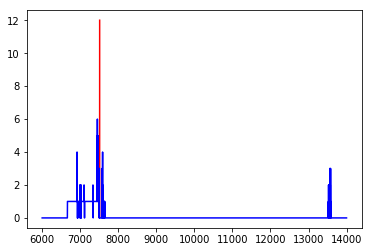

Distance between real kickoff time and estimated time: 60 


784it [00:00, 3983.99it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 1.48 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525006516933 | stop_ts: 1525007115773
[left] start_ts: 1525006516949 | stop_ts: 1525007115789


14972it [00:07, 2089.31it/s]


7501


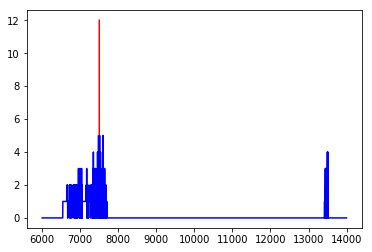

Distance between real kickoff time and estimated time: 19 


667it [00:00, 3243.23it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb in 1.53 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526738122432 | stop_ts: 1526738722232
[left] start_ts: 1526738122412 | stop_ts: 1526738722252


14996it [00:07, 2025.75it/s]


7540


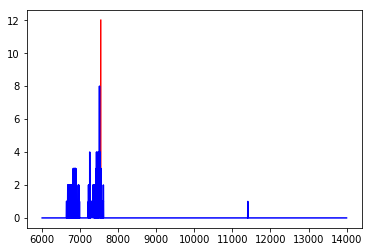

Distance between real kickoff time and estimated time: 34 


124it [00:00, 1233.95it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526216102566 | stop_ts: 1526216702406
[left] start_ts: 1526216102558 | stop_ts: 1526216702398


14997it [00:10, 1498.33it/s]


7476


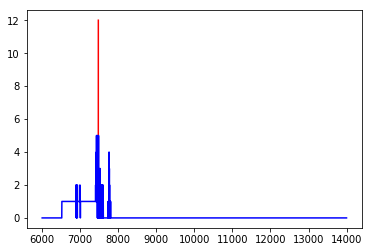

Distance between real kickoff time and estimated time: 48 


156it [00:00, 695.20it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525528504685 | stop_ts: 1525529102525
[left] start_ts: 1525528504705 | stop_ts: 1525529102545


14947it [00:12, 1236.40it/s]


7516


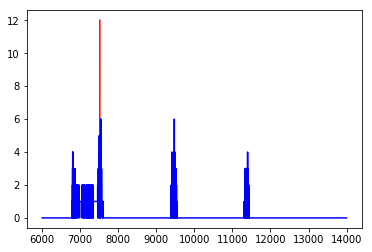

Distance between real kickoff time and estimated time: -20 


68it [00:00, 672.73it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 2.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
[left] start_ts: 1524318934512 | stop_ts: 1524319532312


14940it [00:12, 1207.56it/s]


7468


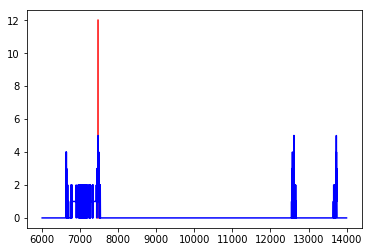

Distance between real kickoff time and estimated time: -1 


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb in 1.41 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526829914293 | stop_ts: 1526830513133
[left] start_ts: 1526829914271 | stop_ts: 1526830513111


14971it [00:06, 2330.42it/s]


7535


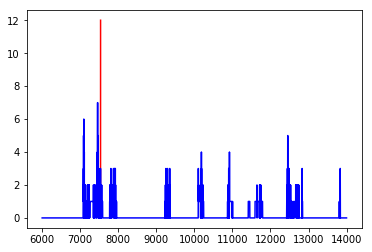

Distance between real kickoff time and estimated time: 78 


581it [00:00, 3026.81it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526921712730 | stop_ts: 1526922309650
[left] start_ts: 1526921712782 | stop_ts: 1526922309662


14922it [00:06, 2433.57it/s]


7452


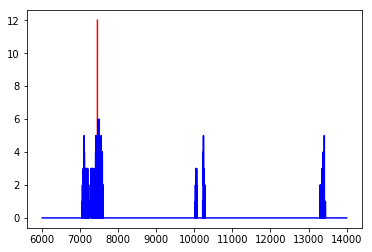

Distance between real kickoff time and estimated time: -12 


331it [00:00, 1584.09it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 1.88 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156948802 | stop_ts: 1524157546362
[left] start_ts: 1524156948162 | stop_ts: 1524157546082


14940it [00:09, 1614.40it/s]


7462


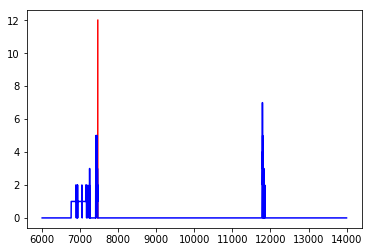

Distance between real kickoff time and estimated time: -4327 


149it [00:00, 1486.14it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb in 1.47 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525712100409 | stop_ts: 1525712697249
[left] start_ts: 1525712100459 | stop_ts: 1525712697259


14922it [00:06, 2330.99it/s]


7469


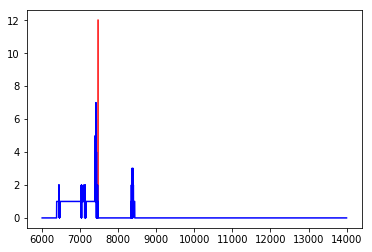

Distance between real kickoff time and estimated time: 55 


124it [00:00, 1233.01it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 2.15 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524923719612 | stop_ts: 1524924319452
[left] start_ts: 1524923719596 | stop_ts: 1524924319436


14997it [00:10, 1482.54it/s]


7540


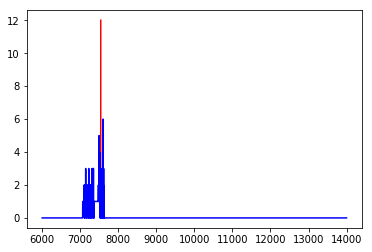

Distance between real kickoff time and estimated time: -63 


In [85]:
X=[]
Y=[]
for i in range(len(config_name)):
    tracks = parse_dump_file('../kickoff-data-corrected/'+tracks_name[i])
    config = json.load(open('../kickoff-data-corrected/'+config_name[i], 'r'))
    kickoff_1 = config['phase_events'][0]['ts']
    kickoff_time = int(parse(kickoff_1).timestamp()*1000)
    pitch_size=config['pitch_size']
    detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
    timestamps = set()
    for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
        fd_left = pickle.loads(fd_left)
        fd_right = pickle.loads(fd_right)
        if np.abs(ts_left - ts_right) < 100:
            ts_left = ts_right
        timestamps.update({ts_left, ts_right})

        detections['players']['left'][ts_left] = fd_left.top_view_player_positions
        detections['players']['right'][ts_right] = fd_right.top_view_player_positions
        detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
        detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    timestamps_list = sorted(list(timestamps))
    kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
    kickoff_time_matched = timestamps_list[kickoff_time_ind]    
    X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
    Y=labels_seq_regression(timestamps_list,detections,pitch_size,1,kickoff_time_matched)
    kickoff_indice=Y.index(1)
    l_classif=list()
    l_regr=list()
    l_regr1=list()
    inputs=list()
    outputs=list()
    kickoff_not_detected=True
    indices_classif_list=[0 for j in range(100)]
    #X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
    for j in range(len(X)):
        X_test=X[j]
        #Classification
        y_predict_classif=clf.predict([X_test])[0]
        if clf.predict([X_test])[0]>0:
            l_classif=l_classif+[j+i for i in range(100)]
        #Find kickoff_sequence
        if l_classif.count(j)>=50:
            l_regr1.append(j-50+int(regr1.predict([X[j-50]])[0]))
            #l_regr1.append(j-50+int(regr1.predict([X[j-50]])[0]))
    X=list()
    Y=list()
    x=[]
    y=[]
    y1=[]
    for j in range(6000,14000):
        x.append(j)
        y.append(l_regr1.count(j))
        #y1.append(l_regr1.count(j))
    print(kickoff_indice)
    #plt.subplot(211)
    plt.plot([kickoff_indice,kickoff_indice-1],[12,0],'r')
    plt.plot(x,y,'b')
    #plt.subplot(212)
    #plt.plot([kickoff_indice,kickoff_indice-1],[12,0],'r')
    #plt.plot(x,y1,'b')
    plt.show()
    max_x=search_kickoff_time(x,y)
    print("Distance between real kickoff time and estimated time: {0} ".format(kickoff_indice-max_x))

734it [00:00, 3615.12it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526133303581 | stop_ts: 1526133902461
[left] start_ts: 1526133303595 | stop_ts: 1526133902435


14971it [00:06, 2403.49it/s]


7511


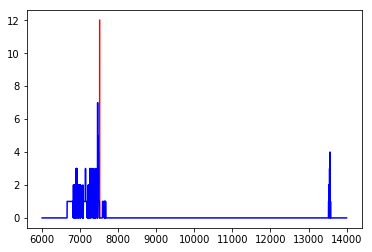

Distance between real kickoff time and estimated time: 55 


798it [00:00, 4148.73it/s]

Parsed ../kickoff-data-corrected/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525006516933 | stop_ts: 1525007115773
[left] start_ts: 1525006516949 | stop_ts: 1525007115789


14972it [00:07, 2094.34it/s]


7501


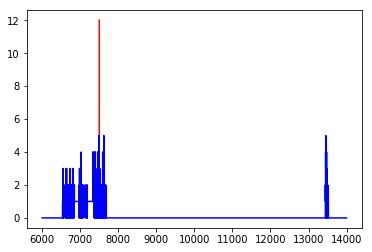

Distance between real kickoff time and estimated time: 10 


342it [00:00, 3409.23it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.1.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526738122432 | stop_ts: 1526738722232
[left] start_ts: 1526738122412 | stop_ts: 1526738722252


14996it [00:07, 2028.22it/s]


7540


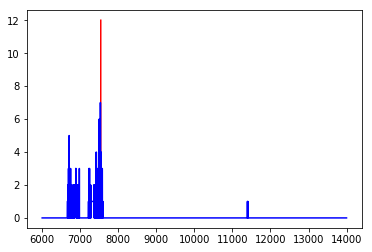

Distance between real kickoff time and estimated time: 10 


260it [00:00, 1306.18it/s]

Parsed ../kickoff-data-corrected/4501652f-d7e6-4e3e-9ad2-e01198278688.1.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526216102566 | stop_ts: 1526216702406
[left] start_ts: 1526216102558 | stop_ts: 1526216702398


14997it [00:10, 1493.96it/s]


7476


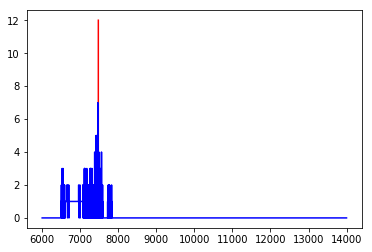

Distance between real kickoff time and estimated time: 13 


163it [00:00, 746.96it/s]

Parsed ../kickoff-data-corrected/4903143c-68be-45f0-9746-e29547b7fa94.1.kickoff.rdb in 4.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525528504685 | stop_ts: 1525529102525
[left] start_ts: 1525528504705 | stop_ts: 1525529102545


14947it [00:12, 1231.72it/s]


7516


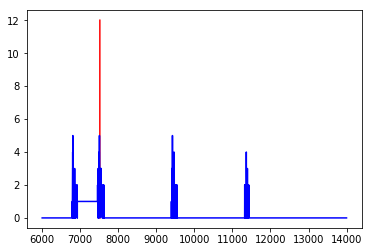

Distance between real kickoff time and estimated time: 710 


71it [00:00, 703.08it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 4.57 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
[left] start_ts: 1524318934512 | stop_ts: 1524319532312


14940it [00:12, 1230.26it/s]


7468


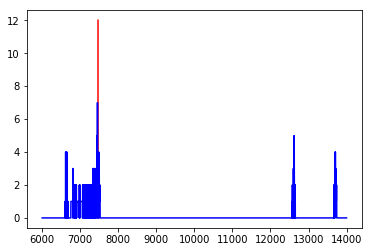

Distance between real kickoff time and estimated time: 15 


672it [00:00, 2977.95it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.1.kickoff.rdb in 1.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526829914293 | stop_ts: 1526830513133
[left] start_ts: 1526829914271 | stop_ts: 1526830513111


14971it [00:06, 2287.62it/s]


7535


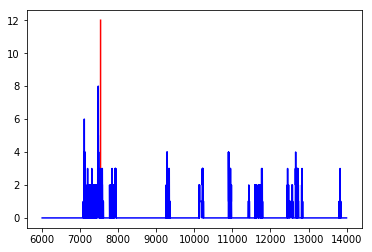

Distance between real kickoff time and estimated time: 61 


557it [00:00, 2897.68it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526921712730 | stop_ts: 1526922309650
[left] start_ts: 1526921712782 | stop_ts: 1526922309662


14922it [00:06, 2370.98it/s]


7452


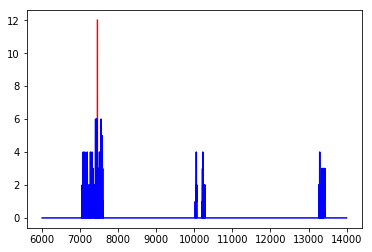

Distance between real kickoff time and estimated time: 49 


332it [00:00, 1555.55it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 2.92 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156948802 | stop_ts: 1524157546362
[left] start_ts: 1524156948162 | stop_ts: 1524157546082


14940it [00:09, 1610.71it/s]


7462


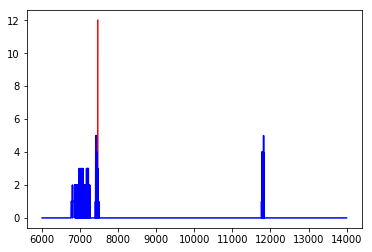

Distance between real kickoff time and estimated time: 53 


299it [00:00, 1484.61it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.1.kickoff.rdb in 1.99 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525712100409 | stop_ts: 1525712697249
[left] start_ts: 1525712100459 | stop_ts: 1525712697259


14922it [00:06, 2286.06it/s]


7469


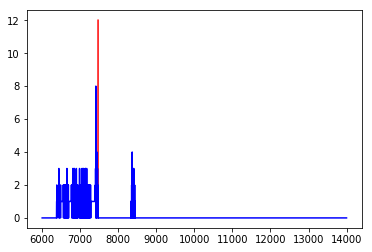

Distance between real kickoff time and estimated time: 58 


246it [00:00, 1192.73it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 3.47 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524923719612 | stop_ts: 1524924319452
[left] start_ts: 1524923719596 | stop_ts: 1524924319436


14997it [00:10, 1481.49it/s]


7540


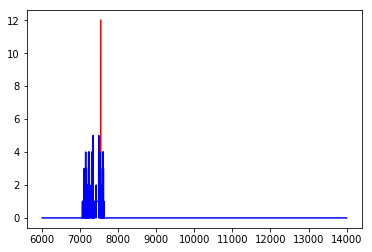

Distance between real kickoff time and estimated time: 203 


In [95]:
X=[]
Y=[]
for i in range(len(config_name)):
    tracks = parse_dump_file('../kickoff-data-corrected/'+tracks_name[i])
    config = json.load(open('../kickoff-data-corrected/'+config_name[i], 'r'))
    kickoff_1 = config['phase_events'][0]['ts']
    kickoff_time = int(parse(kickoff_1).timestamp()*1000)
    pitch_size=config['pitch_size']
    detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
    timestamps = set()
    for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
        fd_left = pickle.loads(fd_left)
        fd_right = pickle.loads(fd_right)
        if np.abs(ts_left - ts_right) < 100:
            ts_left = ts_right
        timestamps.update({ts_left, ts_right})

        detections['players']['left'][ts_left] = fd_left.top_view_player_positions
        detections['players']['right'][ts_right] = fd_right.top_view_player_positions
        detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
        detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    timestamps_list = sorted(list(timestamps))
    kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
    kickoff_time_matched = timestamps_list[kickoff_time_ind]    
    X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
    Y=labels_seq_regression(timestamps_list,detections,pitch_size,1,kickoff_time_matched)
    kickoff_indice=Y.index(1)
    l_classif=list()
    l_regr=list()
    l_regr1=list()
    inputs=list()
    outputs=list()
    kickoff_not_detected=True
    indices_classif_list=[0 for j in range(100)]
    #X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
    for j in range(len(X)):
        X_test=X[j]
        #Classification
        y_predict_classif=clf.predict([X_test])[0]
        if clf.predict([X_test])[0]>0:
            l_classif=l_classif+[j+i for i in range(100)]
        #Find kickoff_sequence
        if l_classif.count(j)>=50:
            l_regr1.append(j-50+int(regr1.predict([X[j-50]])[0]))
            #l_regr1.append(j-50+int(regr1.predict([X[j-50]])[0]))
    X=list()
    Y=list()
    x=[]
    y=[]
    y1=[]
    for j in range(6000,14000):
        x.append(j)
        y.append(l_regr1.count(j))
        #y1.append(l_regr1.count(j))
    print(kickoff_indice)
    #plt.subplot(211)
    plt.plot([kickoff_indice,kickoff_indice-1],[12,0],'r')
    plt.plot(x,y,'b')
    #plt.subplot(212)
    #plt.plot([kickoff_indice,kickoff_indice-1],[12,0],'r')
    #plt.plot(x,y1,'b')
    plt.show()
    max_x=search_kickoff_time(x,y)
    print("Distance between real kickoff time and estimated time: {0} ".format(kickoff_indice-max_x))

In [86]:
(60+19+34+48+20+1+78+12+55+63)/10

39.0

In [39]:
#Create inputs
dataset_classif='../kickoff-data-corrected/data.pickle.1.10.classif.1sym'
nbre_matches=200
X_classif=list()
Y_classif=list()
indices_classif=[0]
with open(dataset_classif, 'rb') as f:
    for i in range(nbre_matches):
        data = pickle.load(f)
        X_classif=X_classif+data[0]
        Y_classif=Y_classif+data[1]
#Training
print("Training classification")
#Shuffle data
X_classif1,Y_classif1=shuffle_data(X_classif,Y_classif)
#x_test,y_test=shuffle_data(x_test1,y_test1)
#Train classifier
clf=RandomForestClassifier(n_estimators=7,max_depth=7)
clf.fit(X_classif1,Y_classif1)
X_classif=list()
Y_classif=list()
X_classif1=list()
Y_classif1=list()



Training classification


In [80]:
dataset_regr='../kickoff-data-corrected/data.pickle.regression.1sym.class3'
X_regr=list()
Y_regr=list()
indices_regr=[0]
nbre_matches=200

with open(dataset_regr, 'rb') as f:
    for i in range(nbre_matches):
        data = pickle.load(f)
        #X_regr+=data[0]
        X_regr+=takeoff_ball_prob(data[0],0.3)
        #X_regr+=takeoff_players_prob(X_r,0.7)
        Y_regr+=data[1]


print("Training regression")
#Shuffle data
X_regr1,Y_regr1=shuffle_data(X_regr,Y_regr)
Y_regr1=change_data_regression(Y_regr1)
#x_test,y_test=shuffle_data(x_test1,y_test1)
                    
#Train regressor
regr=RandomForestRegressor(n_estimators=7,max_depth=7)
regr.fit(X_regr1,Y_regr1)

print(Y_regr1.count(50))
print(Y_regr1.count(-50))
X_regr=list()
Y_regr=list()
X_regr1=list()
Y_regr1=list()


Training regression
28942
15302


In [93]:
dataset_regr='../kickoff-data-corrected/data.pickle.regression.1sym.class3'
X_regr=list()
Y_regr=list()
indices_regr=[0]
nbre_matches=200

with open(dataset_regr, 'rb') as f:
    for i in range(nbre_matches):
        data = pickle.load(f)
        X_r=takeoff_ball_prob(data[0],0.22)
        X_regr+=takeoff_players_prob(X_r,0.66)
        Y_regr+=data[1]


print("Training regression")
#Shuffle data
X_regr1,Y_regr1=shuffle_data(X_regr,Y_regr)
Y_regr1=change_data_regression(Y_regr1)
#x_test,y_test=shuffle_data(x_test1,y_test1)
                    
#Train regressor
regr1=RandomForestRegressor(n_estimators=7,max_depth=7)
regr1.fit(X_regr1,Y_regr1)

print(Y_regr1.count(50))
print(Y_regr1.count(-50))
X_regr=list()
Y_regr=list()
X_regr1=list()
Y_regr1=list()


Training regression
28942
15302


In [ ]:
X=[]
Y=[]

In [66]:
X=[]
Y=[]
X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
Y=labels_seq_regression(timestamps_list,detections,pitch_size,1,kickoff_time_matched)
kickoff_indice=Y.index(1)

In [67]:
l_classif=list()
l_regr=list()
inputs=list()
outputs=list()
kickoff_not_detected=True
indices_classif_list=[0 for j in range(100)]
#X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
for j in range(len(X)):
    X_test=X[j]
    #Classification
    y_predict_classif=clf.predict([X_test])[0]
    if clf.predict([X_test])[0]>0:
        l_classif=l_classif+[j+i for i in range(100)]
    #Find kickoff_sequence
    if l_classif.count(j)>=50:
        l_regr.append(j-50+int(regr.predict([X[j-50]])[0]))


In [61]:
print(l_regr)

[6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6695, 6694, 6695, 6696, 6697, 6697, 6693, 6694, 6693, 6694, 6695, 6684, 6685, 6688, 6687, 6695, 6686, 6689, 6695, 6679, 6694, 6695, 6691, 6692, 6708, 6709, 6715, 6716, 6709, 6709, 6710, 6711, 6712, 6712, 6708, 6725, 6711, 6734, 6735, 6735, 6736, 6737, 6738, 6739, 6742, 6743, 6744, 6744, 6745, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 684

In [44]:
x=[]
z=[]
for j in range(7000,12000):
    x.append(j+50)
    z.append(regr.predict([X[j]]))

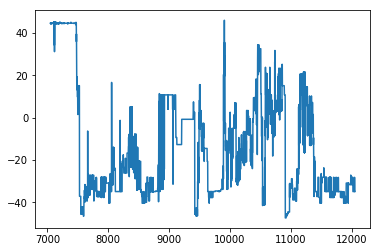

In [45]:
%matplotlib inline
plt.plot(x,z)
plt.show()

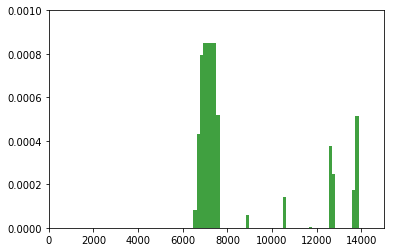

In [46]:
%matplotlib inline
n, bins, patches = plt.hist(l_classif, 50, density=True, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist([kickoff_indice], 3, density=True, facecolor='r', alpha=0.75)
plt.axis([0, 15000, 0, 0.001])
plt.show()

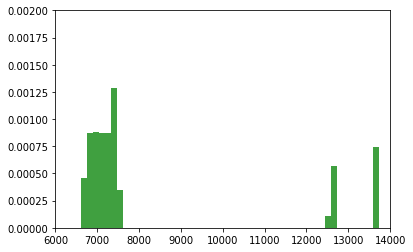

In [47]:
n, bins, patches = plt.hist(l_regr, 50, density=True, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist([kickoff_indice], 1, density=False, facecolor='r', alpha=0.75)
plt.axis([6000, 14000, 0, 0.002])
plt.show()

In [74]:
x=[]
y=[]
for j in range(7400,7600):
    x.append(j)
    y.append(l_regr.count(j))

52


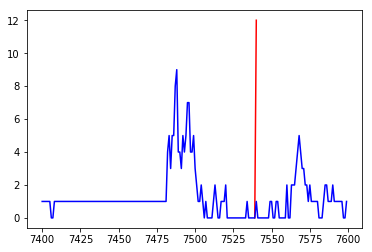

In [75]:
plt.plot([kickoff_indice,kickoff_indice-1],[12,0],'r')
plt.plot(x,y,'b')
print(kickoff_indice-search_kickoff_time(x,y))
plt.show()

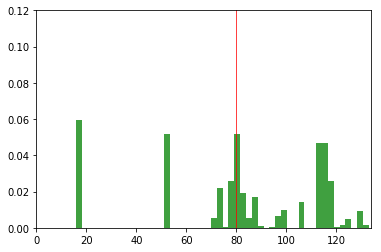

In [94]:
l=[0 for i in range(134)]
%matplotlib inline
for i in range(len(regr.feature_importances_.tolist())):
    l[i-134*int(i/134)]=regr1.feature_importances_[i]+l[i-134*int(i/134)]
l=np.array(l)*10**5
l=l.tolist()
x=list()
for i in range(len(l)):
    x=x+[i for j in range(int(l[i]))]
z=[80 for i in range(100)]
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist([80], 3, density=True, facecolor='r', alpha=0.75)
plt.axis([0, 134, 0, 0.12])
plt.show()

In [38]:
def signal_classification(inputs,clf):
    l=list()
    %matplotlib inline
    for j in range(len(inputs)):
        if clf.predict(np.array([inputs[j]]))[0]>0:
            l=l+[j+i for i in range(100)]
    n, bins, patches = plt.hist(l, 50, density=True, facecolor='g', alpha=0.75)
    plt.axis([0, 15000, 0, 0.001])
    plt.show()
    print(l.count(14400))

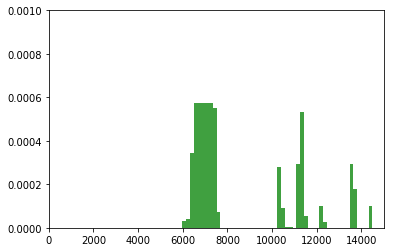

30


In [39]:
signal_classification(X,clf)


In [31]:
def create_dataset_regression(file_name,clf):
    compteur=0
    path_to_rdbs = '../kickoff-data-corrected/*.rdb'
    for rdb_file in glob.glob(path_to_rdbs):
        #Edit json file
        game_half = rdb_file.rstrip('.kickoff.rdb')
        phase = game_half.split('.')[-1]
        correct_json_files(game_half)
        
        #Import correct data
        tracks = parse_dump_file('{}.kickoff.rdb'.format(game_half))
        config = json.load(open('..{}.json'.format(game_half.split('.')[-2]), 'r'))
        print('..{}.json'.format(game_half.split('.')[-2]))
        print(config['phase_events'])
        kickoff_1 = [p_e['ts'] for p_e in config['phase_events'] if p_e['type'] == 'start_phase' and p_e['phase'] == int(phase)][0]
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        print(kickoff_time)
        if kickoff_time>0:
            pitch_size=config['pitch_size']
            detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
            timestamps = set()
            for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
                fd_left = pickle.loads(fd_left)
                fd_right = pickle.loads(fd_right)
                if np.abs(ts_left - ts_right) < 100:
                    ts_left = ts_right
                timestamps.update({ts_left, ts_right})
                detections['players']['left'][ts_left] = fd_left.top_view_player_positions
                detections['players']['right'][ts_right] = fd_right.top_view_player_positions
                detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
                detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
            timestamps_list = sorted(list(timestamps))
            kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
            kickoff_time_matched = timestamps_list[kickoff_time_ind]
            
            #Regression
            X=sequence_composition(timestamps_list,detections,pitch_size,200,1)
            Y=labels_seq_regression(timestamps_list,detections,pitch_size,1,kickoff_time_matched)
            kickoff_indice=Y.index(1)
            X,y=select_regression_data(X,clf,kickoff_indice)
            print(len(X),len(y))
            X,y=reduce_regression_data(X,y,10)
            print(len(X),len(y))
            print(y.count(50),y.count(-50))
            #Create file
            add_data=True
            if len(y)>0 and compteur==0:
                with open(file_name, 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    add_data=False
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([flip_sequences(X),y], f)
                    compteur+=1
            if len(y)>0 and add_data:
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    print(compteur)
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([flip_sequences(X),y], f)
                    compteur+=1

In [32]:
def select_regression_data(X,clf,kickoff_indice):
    l=list()
    new_X=list()
    new_Y=list()
    for j in range(len(X)):
        if clf.predict(np.array([X[j]]))[0]>0:
            l=l+[j+i for i in range(100)]
    for j in range(len(X)):
        if j>=50 and l.count(j)>=50:
            new_X.append(X[j-50])
            if kickoff_indice-j>50:
                new_Y.append(50)
            if j-kickoff_indice>50:
                new_Y.append(-50)
            if abs(j-kickoff_indice)<=50:
                new_Y.append(kickoff_indice-j)
    return new_X,new_Y

In [33]:
def reduce_regression_data(X,y,reduc_size):
    new_X=list()
    new_y=list()
    compteur=0
    for i in range(len(y)):
        if abs(y[i])>=50:
            compteur+=1
        if abs(y[i])<50:
            compteur=0
            new_y.append(y[i])
            new_X.append(X[i])
        if compteur>=reduc_size:
            compteur=0
            new_y.append(y[i])
            new_X.append(X[i])
    return new_X,new_y

In [34]:
def change_data_regression(Y):
    new_Y=list()
    for i in range(len(Y)):
        if Y[i]>50:
            new_Y.append(50)
        if Y[i]<-50:
            new_Y.append(-50)
        if Y[i]<=50 and Y[i]>=-50:
            new_Y.append(Y[i])
    return new_Y

In [35]:
def change_size_inputs(X,size):
    new_X=list()
    for j in range(len(X)-size):
        new_X.append(X[j:j+100]+X[j+100:j+100+size])
    return new_X 

In [37]:
import random
def takeoff_ball_prob(X,prob_ball):
    new_X=list()
    X1=[0 for i in range(70)]
    for i in range(len(X)):
        new_X2=list()
        for j in range(0,len(X[0]),134):
            if random.uniform(0,1)>prob_ball:
                new_X2=new_X2+X1+X[i][j+70:j+134]
            else:
                new_X2+=X[i][j:j+134]
        new_X.append(new_X2)
    return new_X

In [92]:
def takeoff_players_prob(X,prob_players):
    new_X=list()
    for i in range(len(X)):
        new_X2=list()
        for j in range(0,len(X[0]),134):
            if random.uniform(0,1)>prob_players:
                new_X2+=X[i][j:j+88]+[0,0,0,0]+X[i][j+92:j+120]+[0,0,0,0,0]+X[i][j+125:j+134]
            else:
                new_X2+=X[i][j:j+134]
        new_X.append(new_X2)
    return new_X

In [65]:
def search_kickoff_time(x,y):
    max_y=0
    indice_max=0
    for i in range(3000):
        if y[i]>max_y:
            max_y=y[i]
            indice_max=x[i]
    return indice_max

In [ ]:
create_dataset_regression('../kickoff-data-corrected/data.pickle.regression.1sym.8sec',clf)

Json file edited


748it [00:00, 3767.59it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.2.kickoff.rdb in 1.38 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527184568814 | stop_ts: 1527185164734
[right] start_ts: 1527184564976 | stop_ts: 1527185164816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'type': 'start_phase', 'ts': '2018-05-24T17:00:01.496000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:45:58.124Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-24T18:01:05.776000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T18:49:34.388Z', 'phase': 2}]
1527184865776


14898it [00:05, 2716.95it/s]


2850 2850
373 373
200 74
Json file edited


712it [00:00, 3500.60it/s]

Parsed ../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.2.kickoff.rdb in 1.42 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524414578448 | stop_ts: 1524415174608
[right] start_ts: 1524414577904 | stop_ts: 1524415174304
../kickoff-data-corrected/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'type': 'start_phase', 'ts': '2018-04-22T15:29:53.064000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-22T16:18:51.239Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-22T16:34:36.848000', 'kickoff_team_id': 10, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-22T17:22:35.491Z', 'phase': 2}]
1524414876848


14905it [00:06, 2384.14it/s]


1518 1518
240 240
11 130
3
Json file edited


749it [00:00, 3848.41it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.15 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'type': 'start_phase', 'ts': '2018-04-17T17:00:48.769000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-17T17:45:52.314Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-17T18:00:54.313000', 'kickoff_team_id': 3, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-17T18:51:00.072Z', 'phase': 2}]
1523984448769


14964it [00:07, 1964.92it/s]


1605 1605
248 248
78 71
5
Json file edited
Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 2.45 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:22.241Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:01:28.841000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:29.553Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/aadecf3a-0d92-4ace-b643-ced44474e157.2.kickoff.rdb in 1.77 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524160591139 | stop_ts: 1524161189179
[right] start_ts: 1524160591665 | stop_ts: 1524161189465
../kickoff-data-corrected/aadecf3a-0d92-4ace

466it [00:00, 2400.88it/s]

Parsed ../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.1.kickoff.rdb in 2.32 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527180904814 | stop_ts: 1527181500734
[right] start_ts: 1527180900976 | stop_ts: 1527181500816
../kickoff-data-corrected/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'type': 'start_phase', 'ts': '2018-05-24T17:00:01.496000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:45:58.124Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-24T18:01:05.776000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T18:49:34.388Z', 'phase': 2}]
1527181201496


14898it [00:07, 2003.08it/s]


2529 2529
341 341
204 38
7
Json file edited


438it [00:00, 2163.65it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'type': 'start_phase', 'ts': '2018-04-02T13:00:04.376000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T13:47:02.983Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T14:02:02.696000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T14:50:07.639Z', 'phase': 2}]
1522674004376


14996it [00:08, 1822.44it/s]


1893 1893
278 278
110 69
9
Json file edited


210it [00:00, 1036.34it/s]

Parsed ../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.1.kickoff.rdb in 4.35 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527350105211 | stop_ts: 1527350703091
[right] start_ts: 1527350105245 | stop_ts: 1527350703085
../kickoff-data-corrected/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'type': 'start_phase', 'ts': '2018-05-26T16:00:04.565000', 'kickoff_team_id': 5, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-26T16:46:00.357Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-26T17:01:27.885000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-26T17:49:27.835Z', 'phase': 2}]
1527350404565


14947it [00:10, 1374.36it/s]


3107 3107
399 399
123 177
11
Json file edited
Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620373398 | stop_ts: 1525620970238
[right] start_ts: 1525620373530 | stop_ts: 1525620970290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:18.200Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:07.130000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:20:08.236Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
../kickoff-data-corrected/6e26f66b-a921-

339it [00:00, 1692.35it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 2.35 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'type': 'start_phase', 'ts': '2018-04-15T13:00:59.341000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T13:46:01.064Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-15T14:01:55.381000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T14:50:42.654Z', 'phase': 2}]
1523800915381


14983it [00:07, 2028.70it/s]



2215 2215
310 310
128 83
15
Json file edited


173it [00:00, 1727.81it/s]

Parsed ../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.2.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526833546311 | stop_ts: 1526834143111
[right] start_ts: 1526833546293 | stop_ts: 1526834143133
../kickoff-data-corrected/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'type': 'start_phase', 'ts': '2018-05-20T15:30:15.853000', 'kickoff_team_id': 8, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-20T16:15:14.598Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-20T16:30:45.173000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-20T17:19:46.634Z', 'phase': 2}]
1526833845173


14921it [00:06, 2340.11it/s]


1949 1949
283 283
45 139
17


470it [00:00, 4690.50it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'type': 'start_phase', 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T12:45:30.997Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T13:50:58.493Z', 'phase': 2}]
1523707203074


14966it [00:05, 2532.20it/s]


3592 3592
447 447
140 208
19
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.1.kickoff.rdb in 0.88 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527181308818 | stop_ts: 1527181905738
[right] start_ts: 1527181308926 | stop_ts: 1527181905806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:52:47.009Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T19:02:55.588Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/456910d1-b523-4ff2-b60c-fcd1f016b96d.2.kickoff.rdb in 1.64 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524506251416 | stop_ts: 1524506851016
[right] start_ts: 1524506250924 | stop_ts: 1524506850764
../kickoff-data-corrected/456910d1-b523-4ff2-b6

282it [00:00, 2809.94it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.45 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:47:27.898Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:51:34.402Z', 'phase': 2}]
1523192430151


14966it [00:08, 1774.29it/s]


2110 2110
299 299
125 75
21
Json file edited
Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.70 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'type': 'start_phase', 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T12:45:30.997Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T13:50:58.493Z', 'phase': 2}]
0
Json file edited


306it [00:00, 1532.18it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1.kickoff.rdb in 3.12 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526576105405 | stop_ts: 1526576702165
[right] start_ts: 1526576105219 | stop_ts: 1526576702099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'type': 'start_phase', 'ts': '2018-05-17T17:00:04.205000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-17T17:47:07.092Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-17T18:04:04.725000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-17T18:52:06.565Z', 'phase': 2}]
1526576404205


14921it [00:09, 1543.16it/s]


1413 1413
229 229
45 85
23
Json file edited


354it [00:00, 3534.46it/s]

Parsed ../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526229880539 | stop_ts: 1526230477379
[right] start_ts: 1526229880495 | stop_ts: 1526230477335
../kickoff-data-corrected/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:45:36.695000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:33:39.123Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:49:39.615000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:39:37.349Z', 'phase': 2}]
1526230179615


14922it [00:06, 2266.89it/s]


1405 1405
229 229
81 49
25
Json file edited
Parsed ../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.2.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527098333205 | stop_ts: 1527098931045
[right] start_ts: 1527098333133 | stop_ts: 1527098931013
../kickoff-data-corrected/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-23T17:48:32.142Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-23T18:54:13.202Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 2.02 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd

833it [00:00, 4064.18it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2.kickoff.rdb in 1.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624022661 | stop_ts: 1525624619501
[right] start_ts: 1525624022583 | stop_ts: 1525624619463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'type': 'start_phase', 'ts': '2018-05-06T15:30:56.823000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:55.775Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:03.343000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:19:59.649Z', 'phase': 2}]
1525624323343


14923it [00:06, 2389.83it/s]


3590 3590
448 448
209 140
27
Json file edited


416it [00:00, 2049.95it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2.kickoff.rdb in 2.27 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524322642512 | stop_ts: 1524323242312
[right] start_ts: 1524322643076 | stop_ts: 1524323242636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'type': 'start_phase', 'ts': '2018-04-21T14:00:33.996000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-21T14:45:33.074Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-21T15:02:23.876000', 'kickoff_team_id': 12, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-21T15:50:24.649Z', 'phase': 2}]
1524322943876


14989it [00:07, 1889.65it/s]


3027 3027
391 391
211 81
29
Json file edited


264it [00:00, 1349.56it/s]

Parsed ../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.1.kickoff.rdb in 2.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525521349217 | stop_ts: 1525521946057
[right] start_ts: 1525521349195 | stop_ts: 1525521946035
../kickoff-data-corrected/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'type': 'start_phase', 'ts': '2018-05-05T12:00:48.555000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-05T12:47:24.013Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-05T13:03:50.875000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-05T13:51:49.753Z', 'phase': 2}]
1525521648555


14921it [00:08, 1804.53it/s]


1530 1530
241 241
89 53
31
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.48 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'type': 'start_phase', 'ts': '2018-05-13T15:30:01.862000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-13T16:16:59.553Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-13T16:32:03.932000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-13T17:20:33.812Z', 'phase': 2}]
1526225401862


14972it [00:07, 1967.91it/s]


1684 1684
256 256
107 50
33
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525611301214 | stop_ts: 1525611898494
[right] start_ts: 1525611300264 | stop_ts: 1525611897984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T13:45:00.746Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T14:48:47.422Z', 'phase': 2}]
0
Json file edited


187it [00:00, 1867.10it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.15 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:46:35.647Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:52:04.739Z', 'phase': 2}]
1524074585473


14914it [00:07, 1954.50it/s]


3079 3079
396 396
114 183
35
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.03 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'type': 'start_phase', 'ts': '2018-04-14T14:00:21.598000', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T14:46:37.899Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-14T15:02:38.518000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T15:51:35.702Z', 'phase': 2}]
1523714421598


14991it [00:08, 1831.28it/s]


1287 1287
217 217
9 109
37
Json file edited


249it [00:00, 2489.85it/s]

Parsed ../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525624025358 | stop_ts: 1525624625238
[right] start_ts: 1525624025530 | stop_ts: 1525624625290
../kickoff-data-corrected/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:18.200Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:07.130000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:20:08.236Z', 'phase': 2}]
1525624327130


14996it [00:06, 2423.03it/s]


2819 2819
371 371
74 198
39
Json file edited
Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 2.32 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
[right] start_ts: 1523638586979 | stop_ts: 1523639185819
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-13T17:48:25.115Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-13T18:52:23.632Z', 'phase': 2}]
0
Json file edited


113it [00:00, 1127.57it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:46:35.647Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:52:04.739Z', 'phase': 2}]
1524070829775


14939it [00:09, 1596.77it/s]


2197 2197
308 308
31 178
41
Json file edited


591it [00:00, 3078.64it/s]

Parsed ../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 2.11 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526921712782 | stop_ts: 1526922309662
[right] start_ts: 1526921712730 | stop_ts: 1526922309650
../kickoff-data-corrected/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'type': 'start_phase', 'ts': '2018-05-21T17:00:10.970000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-21T17:46:11.855Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-21T18:01:54.690000', 'kickoff_team_id': 7, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-21T18:51:25.546Z', 'phase': 2}]
1526922010970


14922it [00:06, 2389.35it/s]


1587 1587
247 247
62 86
43
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T16:17:54.242Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T16:34:22.301000', 'kickoff_team_id': 16, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T17:23:20.816Z', 'phase': 2}]
1523205262301


14949it [00:08, 1823.77it/s]


3388 3388
427 427
271 57
45
Json file edited


770it [00:00, 3725.59it/s]

Parsed ../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526133303595 | stop_ts: 1526133902435
[right] start_ts: 1526133303581 | stop_ts: 1526133902461
../kickoff-data-corrected/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'type': 'start_phase', 'ts': '2018-05-12T14:00:04.221000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-12T14:46:02.666Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-12T15:01:24.821000', 'kickoff_team_id': 15, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-12T15:48:40.504Z', 'phase': 2}]
1526133604221


14971it [00:05, 2517.23it/s]


1788 1788
267 267
102 66
47
Json file edited


381it [00:00, 1832.57it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'type': 'start_phase', 'ts': '2018-04-18T17:00:11.969000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:47:10.874Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-18T18:02:20.169000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:49:19.022Z', 'phase': 2}]
1524070811969


14996it [00:09, 1559.81it/s]


1463 1463
235 235
8 128
49
Json file edited


336it [00:00, 1608.68it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 3.25 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524156948162 | stop_ts: 1524157546082
[right] start_ts: 1524156948802 | stop_ts: 1524157546362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'type': 'start_phase', 'ts': '2018-04-19T17:00:47.522000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-19T17:45:47.791Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-19T18:01:37.282000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-19T18:51:07.597Z', 'phase': 2}]
1524157247522


14940it [00:09, 1633.24it/s]


1633 1633
251 251
47 105
51
Json file edited


119it [00:00, 1185.91it/s]

Parsed ../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 2.17 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
[right] start_ts: 1525006796888 | stop_ts: 1525007393688
../kickoff-data-corrected/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'type': 'start_phase', 'ts': '2018-04-29T13:04:55.088000', 'kickoff_team_id': 2, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-29T13:51:58.173Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-29T14:09:37.368000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-29T14:57:43.997Z', 'phase': 2}]
1525007095088


14921it [00:08, 1832.17it/s]


1959 1959
284 284
140 45
53
Json file edited


221it [00:00, 2203.67it/s]

Parsed ../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.2.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527346602172 | stop_ts: 1527347199012
[right] start_ts: 1527346602142 | stop_ts: 1527347199022
../kickoff-data-corrected/d092d84a-bfe1-4638-bd6e-7f516a90553a.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-26T14:46:31.767Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-26T15:01:41.702000', 'kickoff_team_id': 4, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-26T15:49:43.350Z', 'phase': 2}]
1527346901702


14922it [00:07, 2055.66it/s]


1823 1823
271 271
32 140
55
Json file edited


248it [00:00, 1277.22it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.13 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'type': 'start_phase', 'ts': '2018-04-01T13:00:57.284000', 'kickoff_team_id': 9, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:08.486Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:50:51.103Z', 'phase': 2}]
1522587657284


14908it [00:07, 1904.76it/s]


1613 1613
249 249
113 37
57
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'type': 'start_phase', 'ts': '2018-05-20T13:10:06.054Z', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-20T13:55:08.940Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-20T14:12:36.446000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-20T15:02:18.183Z', 'phase': 2}]
1526825556446


14948it [00:07, 2132.18it/s]


1229 1229
211 211
40 72
59
Json file edited


739it [00:00, 7388.46it/s]

Parsed ../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524160596162 | stop_ts: 1524161195082
[right] start_ts: 1524160596802 | stop_ts: 1524161195362
../kickoff-data-corrected/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'type': 'start_phase', 'ts': '2018-04-19T17:00:47.522000', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-19T17:45:47.791Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-19T18:01:37.282000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-19T18:51:07.597Z', 'phase': 2}]
1524160897282


14965it [00:06, 2259.89it/s]


2210 2210
309 309
110 100
61
Json file edited
Parsed ../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320594327 | stop_ts: 1526321192167
[right] start_ts: 1526320594243 | stop_ts: 1526321192163
../kickoff-data-corrected/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:28.806Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:37.209Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.1.kickoff.rdb in 2.37 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526745302179 | stop_ts: 1526745901059
[right] start_ts: 1526745302339 | stop_ts: 1526745901139
../kickoff-data-corrected/916abbb2-57b9-4700-8

80it [00:00, 797.47it/s]

Parsed ../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.89 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
[right] start_ts: 1522596366671 | stop_ts: 1522596965511
../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json
[{'type': 'start_phase', 'ts': '2018-04-01T15:31:02.151000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T16:16:08.759Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T17:20:20.880Z', 'phase': 2}]
1522596662151


14972it [00:06, 2209.67it/s]


1150 1150
203 203
40 64
63
Json file edited
Parsed ../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525614945214 | stop_ts: 1525615542494
[right] start_ts: 1525614944224 | stop_ts: 1525615541984
../kickoff-data-corrected/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 16, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T13:45:00.746Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T14:48:47.422Z', 'phase': 2}]
0
Json file edited


298it [00:00, 2979.89it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.53 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-09T17:47:46.113Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-09T18:04:20.408000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-09T18:53:12.188Z', 'phase': 2}]
1523297060408


14906it [00:06, 2427.14it/s]


3169 3169
405 405
153 153
65
Json file edited


77it [00:00, 764.34it/s]

Parsed ../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 2.70 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524318934512 | stop_ts: 1524319532312
[right] start_ts: 1524318935116 | stop_ts: 1524319532636
../kickoff-data-corrected/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'type': 'start_phase', 'ts': '2018-04-21T14:00:33.996000', 'kickoff_team_id': 13, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-21T14:45:33.074Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-21T15:02:23.876000', 'kickoff_team_id': 12, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-21T15:50:24.649Z', 'phase': 2}]
1524319233996


14940it [00:12, 1174.24it/s]


1593 1593
247 247
75 73
67
Json file edited


97it [00:00, 966.64it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.45 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'type': 'start_phase', 'ts': '2018-04-16T17:01:37.097000', 'kickoff_team_id': 15, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-16T17:46:39.313Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-16T18:02:51.643000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-16T18:49:49.424Z', 'phase': 2}]
1523898097097


14991it [00:10, 1394.73it/s]


3857 3857
474 474
190 185
69
Json file edited


378it [00:00, 1792.31it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-10T17:47:16.674Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-10T18:03:05.406000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-10T18:51:05.058Z', 'phase': 2}]
1523383385406


14982it [00:07, 2003.38it/s]


1735 1735
261 261
118 44
71
Json file edited
Parsed ../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527185280818 | stop_ts: 1527185876738
[right] start_ts: 1527185276926 | stop_ts: 1527185876806
../kickoff-data-corrected/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-24T17:52:47.009Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-24T19:02:55.588Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.06 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
../kickoff-data-corrected/3382a9d0-02ff-4f23-974

145it [00:00, 1442.86it/s]

Parsed ../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525715936459 | stop_ts: 1525716534259
[right] start_ts: 1525715936409 | stop_ts: 1525716534249
../kickoff-data-corrected/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'type': 'start_phase', 'ts': '2018-05-07T16:59:59.329000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-07T17:45:00.886Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-07T18:03:56.609000', 'kickoff_team_id': 6, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-07T18:53:43.859Z', 'phase': 2}]
1525716236609


14946it [00:07, 1992.88it/s]


4390 4390
527 527
415 13
73
Json file edited
Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 2.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:53.692Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:53:51.954Z', 'phase': 2}]
0
Json file edited
Parsed ../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.2.kickoff.rdb in 1.92 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522600030721 | stop_ts: 1522600628521
[right] start_ts: 1522600030671 | stop_ts: 1522600628511
../kickoff-data-corrected/ba34fc2e-bdba-40

255it [00:00, 1217.49it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:03:52.775000', 'kickoff_team_id': 11, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:48:52.077Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:05:16.815000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:53:40.200Z', 'phase': 2}]
1523192632775


14925it [00:08, 1662.29it/s]


6277 6277
716 716
480 137
75
Json file edited
Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.99 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-15T16:16:00.459Z', 'phase': 1}, {'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-15T17:19:35.565Z', 'phase': 2}]
0
Json file edited


559it [00:00, 2901.97it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.24 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'type': 'start_phase', 'ts': '2018-04-13T17:00:01.059000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-13T17:45:38.365Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-13T18:00:41.739000', 'kickoff_team_id': 14, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-13T18:47:41.972Z', 'phase': 2}]
1523638801059


14940it [00:07, 1992.50it/s]


2147 2147
303 303
173 31
77
Json file edited


215it [00:00, 2143.96it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'type': 'start_phase', 'ts': '2018-04-02T15:32:26.973000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-02T16:17:34.362Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-02T16:33:32.893000', 'kickoff_team_id': 8, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-02T17:22:39.373Z', 'phase': 2}]
1522686812893


14946it [00:06, 2260.52it/s]


4619 4619
551 551
244 208
79
Json file edited
Parsed ../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.1.kickoff.rdb in 2.67 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524502497320 | stop_ts: 1524503096600
[right] start_ts: 1524502496828 | stop_ts: 1524503096348
../kickoff-data-corrected/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-23T17:45:26.980Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-23T18:01:18.280000', 'kickoff_team_id': 1, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-23T18:51:18.989Z', 'phase': 2}]
0
Json file edited


266it [00:00, 2652.26it/s]

Parsed ../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526741990412 | stop_ts: 1526742590252
[right] start_ts: 1526741990392 | stop_ts: 1526742590232
../kickoff-data-corrected/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'type': 'start_phase', 'ts': '2018-05-19T14:00:24.152000', 'kickoff_team_id': 3, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-19T14:48:34.080Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-19T15:04:52.912000', 'kickoff_team_id': 13, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-19T15:53:26.441Z', 'phase': 2}]
1526742292912


14996it [00:06, 2356.01it/s]


1192 1192
207 207
77 31
81
Json file edited


505it [00:00, 2489.69it/s]

Parsed ../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526320642105 | stop_ts: 1526321241985
[right] start_ts: 1526320642055 | stop_ts: 1526321241935
../kickoff-data-corrected/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'type': 'start_phase', 'ts': '2018-05-14T17:00:31.615000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-14T17:46:31.340Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-14T18:02:22.775000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-14T18:49:16.627Z', 'phase': 2}]
1526320942775


14997it [00:06, 2456.25it/s]


3032 3032
392 392
147 146
83
Json file edited


278it [00:00, 2778.09it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'type': 'start_phase', 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-08T13:47:27.898Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-08T14:51:34.402Z', 'phase': 2}]
1523196155117


14992it [00:07, 1903.21it/s]


1169 1169
205 205
51 55
85
Json file edited


202it [00:00, 2015.26it/s]

Parsed ../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.2.kickoff.rdb in 2.20 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524927395556 | stop_ts: 1524927994436
[right] start_ts: 1524927395612 | stop_ts: 1524927994452
../kickoff-data-corrected/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'type': 'start_phase', 'ts': '2018-04-28T14:00:21.412000', 'kickoff_team_id': 6, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-28T14:45:26.494Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-28T15:01:35.852000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-28T15:49:36.913Z', 'phase': 2}]
1524927695852


14973it [00:07, 1982.90it/s]


1260 1260
214 214
78 37
87
Json file edited


141it [00:00, 1402.75it/s]

Parsed ../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1.kickoff.rdb in 2.33 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525620358621 | stop_ts: 1525620955501
[right] start_ts: 1525620358583 | stop_ts: 1525620955463
../kickoff-data-corrected/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'type': 'start_phase', 'ts': '2018-05-06T15:30:56.823000', 'kickoff_team_id': 14, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-06T16:16:55.775Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-06T16:32:03.343000', 'kickoff_team_id': 5, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-06T17:19:59.649Z', 'phase': 2}]
1525620656823


14922it [00:07, 2130.36it/s]


1553 1553
244 244
123 22
89
Json file edited


248it [00:00, 2475.32it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-01T13:47:53.692Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-01T14:53:51.954Z', 'phase': 2}]
1522591530455


14913it [00:06, 2256.84it/s]


2062 2062
294 294
106 89
91
Json file edited


286it [00:00, 2856.14it/s]

Parsed ../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2.kickoff.rdb in 2.03 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526579945405 | stop_ts: 1526580542165
[right] start_ts: 1526579945259 | stop_ts: 1526580542099
../kickoff-data-corrected/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'type': 'start_phase', 'ts': '2018-05-17T17:00:04.205000', 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': '2018-05-17T17:47:07.092Z', 'phase': 1}, {'type': 'start_phase', 'ts': '2018-05-17T18:04:04.725000', 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': '2018-05-17T18:52:06.565Z', 'phase': 2}]
1526580244725


14906it [00:07, 1788.11it/s]

In [47]:
X=sequence_composition(timestamps_list,detections,pitch_size,100,1)
Y=labels_seq_regression(timestamps_list,detections,pitch_size,1,kickoff_time_matched)
kickoff_indice=Y.index(1)

In [48]:
print(kickoff_indice)
X,y=select_regression_data(X,clf,kickoff_indice)
print(len(y),print(len(X)))

7462
1696
1696 None


In [53]:
X,y=reduce_regression_data(X,y,10)
print(len(X),len(y))
print(y)

337 337
[-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 1